# Libraries

In [ ]:
import polars as pl
import pandas as pd
import numpy as np 
from pathlib import Path
from tqdm import tqdm
import arviz as az 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sum
from scipy import stats 
from datetime import datetime
from typing import Optional, Dict, Literal
from rdrobust import rdrobust, rdbwselect, rdplot

random_seed = 123
rng = np.random.default_rng(random_seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'


# Data Cleaning

In [30]:
def process_parquet_folder_RDD(
    folder_path: str, 
    treatment_area: int = 231002,
    date_base: int = 202201,  # baseline policy month (YYYYMM)
    age_base: int = 17,        # cutoff age for RDD
    Y: str = "ika_out_req_amt"
) -> pl.DataFrame:
    """
    Process Parquet files (treatment area only) for RDD analysis.
    
    Steps:
        1. Compute baseline age (float) using correct formula
        2. Keep patients aged <19 at baseline
        3. Compute current age (float) using correct formula
        4. Compute Δ1 (±1 month) and Δ2 (±2 months) flags based on age_base
        5. Adjust birth_date: people in Delta1 get mapped to "center" birth month
        6. Recalculate age_adjusted using adjusted birth_date
        7. Keep only treatment area
        8. Flag D=1 for patients who used public expense after policy
        9. Keep only D=1 and Δ1 samples
    """

    parquet_dir = Path(folder_path)
    parquet_files = list(parquet_dir.glob("*.parquet"))
    if not parquet_files:
        raise FileNotFoundError(f"No parquet files found in {folder_path}")

    print(f"Processing treatment area: {treatment_area}")
    print(f"Baseline: {date_base}, RDD age_base: {age_base}\n")

    merged_results = []

    # ─────────────────────────────────────────────
    # Δ flags computed dynamically based on age_base ± months
    # ─────────────────────────────────────────────
    base_year = date_base // 100
    base_month = date_base % 100
    birth_year = base_year - age_base

    def month_shift(y, m, delta):
        """Helper: shift (year, month) by ±delta months safely"""
        new_m = m + delta
        new_y = y
        if new_m <= 0:
            new_y -= 1
            new_m += 12
        elif new_m > 12:
            new_y += 1
            new_m -= 12
        return new_y, new_m

    # Build lists of birth months for Δ1 (±1 mo) and Δ2 (±2 mo)
    delta1_births, delta2_births = set(), set()
    for d in range(-1, 2):      # -1, 0, +1
        y, m = month_shift(birth_year, base_month, d)
        delta1_births.add(y * 100 + m)
    for d in range(-2, 3):      # -2, -1, 0, +1, +2
        y, m = month_shift(birth_year, base_month, d)
        delta2_births.add(y * 100 + m)

    # CENTER birth date (the target birth month for grouping)
    center_birth_date = birth_year * 100 + base_month

    print(f"Δ1 birth months (±1 mo): {sorted(delta1_births)}")
    print(f"Δ2 birth months (±2 mo): {sorted(delta2_births)}")
    print(f"Center birth date (target): {center_birth_date}\n")

    # ─────────────────────────────────────────────
    # Process all parquet files
    # ─────────────────────────────────────────────
    for parquet in tqdm(parquet_files, desc="Processing Parquet Files"):
        lf = pl.scan_parquet(parquet)

        # 性別・家族区分 → 数値化
        lf = lf.with_columns([
            pl.when(pl.col("sex_type_nm") == "男").then(0)
              .when(pl.col("sex_type_nm") == "女").then(1)
              .otherwise(None)
              .alias("sex_type_nm").cast(pl.Float64),
            pl.when(pl.col("rezept_family_type_nm") == "家族").then(0)
              .when(pl.col("rezept_family_type_nm") == "本人").then(1)
              .otherwise(None)
              .alias("rezept_family_type_nm").cast(pl.Float64)
        ])

        # 職業・年収カテゴリ変換
        lf = lf.with_columns([
            pl.col("business_type").cast(pl.Categorical).to_physical().alias("business_type_num"),
            pl.col("annual_salary_rank").cast(pl.Categorical).to_physical().alias("annual_salary_rank_num")
        ])

        # ═════════════════════════════════════════════════════════════
        # AGE CALCULATIONS - CORRECTED FORMULA
        # ═════════════════════════════════════════════════════════════
        
        # Step 1: Baseline age (at date_base) using ORIGINAL birth_date
        lf = lf.with_columns([
            (
                (date_base // 100 - pl.col("birth_date") // 100)
                + ((date_base % 100 - pl.col("birth_date") % 100) / 12.0)
            ).cast(pl.Float64).alias(f"At{date_base}")
        ]).filter(pl.col(f"At{date_base}") < 19)

        # Step 2: Current age using ORIGINAL birth_date
        lf = lf.with_columns([
            (
                (pl.col("medtreat_yymm") // 100 - pl.col("birth_date") // 100)
                + ((pl.col("medtreat_yymm") % 100 - pl.col("birth_date") % 100) / 12.0)
            ).cast(pl.Float64).alias("age")
        ])

        # Step 3: Δフラグ（±1 mo と ±2 mo）
        lf = lf.with_columns([
            pl.col("birth_date").is_in(list(delta1_births)).cast(pl.Int8).alias("Delta1"),
            pl.col("birth_date").is_in(list(delta2_births)).cast(pl.Int8).alias("Delta2"),
        ])

        # Step 4: Birth date adjustment - Map Delta1 births to center
        lf = lf.with_columns([
            pl.when(pl.col("Delta1") == 1)
              .then(pl.lit(center_birth_date))
              .otherwise(pl.col("birth_date"))
              .alias("birth_date_adjusted")
        ])

        # Step 5: Recalculate age using ADJUSTED birth_date
        lf = lf.with_columns([
            (
                (pl.col("medtreat_yymm") // 100 - pl.col("birth_date_adjusted") // 100)
                + ((pl.col("medtreat_yymm") % 100 - pl.col("birth_date_adjusted") % 100) / 12.0)
            ).cast(pl.Float64).alias("age_adjusted")
        ])

        # ─────────────────────────────────────────────
        # Filter by period and area
        # ─────────────────────────────────────────────
        lf = lf.filter(
            (pl.col("area_id") == treatment_area) &
            (pl.col("medtreat_yymm") >= 201801) &
            (pl.col("medtreat_yymm") < 202301)
        )

        df_all = lf.collect()

        # ─────────────────────────────────────────────
        # Dominant area check
        # ─────────────────────────────────────────────
        area_counts = (
            df_all.group_by(["patient_id", "area_id"])
            .agg(pl.len().alias("visits"))
        )
        dominant_area = (
            area_counts.sort(["patient_id", "visits"], descending=[False, True])
            .group_by("patient_id").first()
        )
        patients_in_treatment = dominant_area.filter(pl.col("area_id") == treatment_area)

        # ─────────────────────────────────────────────
        # Public expense usage after policy (D=1)
        # ─────────────────────────────────────────────
        used_public_expense = (
            df_all.filter(
                (pl.col("medtreat_yymm") >= date_base) &
                (pl.col("public_expense_cd") >= 1) &
                (pl.col("age") < 19)
            )
            .select("patient_id").unique()
            .with_columns(pl.lit(1).alias("used_public_expense"))
        )

        # D=1 assignment
        eligible_patients = (
            patients_in_treatment.select("patient_id")
            .join(used_public_expense, on="patient_id", how="inner")
            .select("patient_id")
            .with_columns(pl.lit(1).alias("D"))
        )

        # Join & keep D=1 only
        df_treat = (
            df_all.join(eligible_patients, on="patient_id", how="left")
            .with_columns(pl.col("D").fill_null(0))
            .filter(pl.col("D") == 1)
        )
        
        merged_results.append(df_treat)

    # ─────────────────────────────────────────────
    # Combine all files
    # ─────────────────────────────────────────────
    final_df = pl.concat(merged_results, how="vertical_relaxed")
    
    # Filter to Delta1 only
    final_df = final_df.filter(pl.col("Delta1") == 1)
    
    # Select relevant columns
    final_df = final_df.select([
        'patient_id', 
        'sex_type_nm', 
        'birth_date',           # Original birth date
        'birth_date_adjusted',  # Adjusted birth date (grouped to center)
        'medtreat_yymm', 
        'age',                  # Age from original birth date
        'age_adjusted',         # Age from adjusted birth date (USE FOR RDD!)
        'Delta1', 
        Y
    ])

    # ─────────────────────────────────────────────
    # Summary statistics
    # ─────────────────────────────────────────────
    print(f"\n✅ Completed {len(parquet_files)} files")
    print(f"Total rows (D=1 only): {final_df.height:,}")
    print(f"Unique patients: {final_df['patient_id'].n_unique():,}")
    print(f"Δ1 = 1: {final_df.filter(pl.col('Delta1') == 1).height:,} rows")
    
    # Birth date adjustment stats
    n_adjusted = (final_df["birth_date"] != final_df["birth_date_adjusted"]).sum()
    print(f"\n📊 Birth date adjustments:")
    print(f"   Adjusted: {n_adjusted:,} observations")
    print(f"   Unchanged: {(final_df.height - n_adjusted):,} observations")
    print(f"   Original birth dates: {final_df['birth_date'].n_unique()} unique")
    print(f"   Adjusted birth dates: {final_df['birth_date_adjusted'].n_unique()} unique")
    
    # Age comparison
    print(f"\n📊 Age statistics:")
    print(f"   age (original birth): min={final_df['age'].min():.2f}, max={final_df['age'].max():.2f}")
    print(f"   age_adjusted: min={final_df['age_adjusted'].min():.2f}, max={final_df['age_adjusted'].max():.2f}")

    return final_df

In [35]:
def add_rdd_variables(
    df: pl.DataFrame,
    policy_date: int = 202201,  # Policy implementation date (YYYYMM)
) -> pl.DataFrame:
    """
    Add post_policy indicator for RDD analysis.
    
    Note: birth_date_adjusted and age_adjusted are already created by 
    process_parquet_folder_RDD, which groups people within ±1 month.
    
    This function adds:
    - post_policy indicator based on medtreat_yymm
    
    Args:
        df: DataFrame from process_parquet_folder_RDD
        policy_date: Policy implementation date (default: 202201)
    
    Returns:
        DataFrame with post_policy column added
    """
    
    # Add post_policy indicator based on treatment month
    df = df.with_columns(
        pl.when(pl.col("medtreat_yymm") >= policy_date)
          .then(1)
          .otherwise(0)
          .alias("post_policy")
    )
    
    # Summary statistics
    print(f"✅ Added post_policy indicator (policy date: {policy_date})")
    print(f"   Pre-policy observations (medtreat_yymm < {policy_date}): {(df['post_policy'] == 0).sum():,}")
    print(f"   Post-policy observations (medtreat_yymm >= {policy_date}): {(df['post_policy'] == 1).sum():,}")
    print(f"\n   Using age_adjusted (birth dates grouped within ±1 month)")
    print(f"   Unique age_adjusted values: {df['age_adjusted'].n_unique()}")
    
    # Show age distribution by policy period
    print(f"\n📊 Age distribution by period:")
    age_summary = df.group_by("post_policy").agg([
        pl.col("age_adjusted").min().alias("min_age"),
        pl.col("age_adjusted").max().alias("max_age"),
        pl.col("age_adjusted").mean().alias("mean_age"),
        pl.len().alias("n_obs")
    ]).sort("post_policy")
    print(age_summary)
    
    return df

In [36]:
df_RDD = process_parquet_folder_RDD("/Users/lex/CodeProjects/MyProject/Mitaron/Parquet_fresh")

Processing treatment area: 231002
Baseline: 202201, RDD age_base: 17

Δ1 birth months (±1 mo): [200412, 200501, 200502]
Δ2 birth months (±2 mo): [200411, 200412, 200501, 200502, 200503]
Center birth date (target): 200501



Processing Parquet Files: 100%|██████████| 8/8 [00:00<00:00, 29.68it/s]


✅ Completed 8 files
Total rows (D=1 only): 1,497
Unique patients: 108
Δ1 = 1: 1,497 rows

📊 Birth date adjustments:
   Adjusted: 993 observations
   Unchanged: 504 observations
   Original birth dates: 3 unique
   Adjusted birth dates: 1 unique

📊 Age statistics:
   age (original birth): min=12.92, max=18.00
   age_adjusted: min=13.00, max=17.92


# RDD Code

In [32]:

class MultiCutoffDoubleRDD:
    """
    Implements RDD analysis with multiple age cutoffs and double transitions.
    
    Design:
    - Age 16 (pre-policy): Free → Paid transition
    - Age 17/18 (double RDD): Compare pre-policy (Free→Paid) vs post-policy (Paid→Free)
    
    Key features:
    - Parametric RDD with polynomial controls
    - Flexible bandwidth selection
    - Separate pre/post analysis or pooled difference-in-discontinuities
    """

    # Storing the copy of the input data
    def __init__(self, data, policy_date = "202201"):
        """
        Initializing multi-cutoff RDD analysis

        Args:
            data (DataFrame): Must include: patient_id, age_adjusted, medtreat_yymm, and outcomes.
        policy_date : str
            policy_date (str, optional): Policy implementation month (e.g., '202201')
        """

        # Convert to pandas if needed
        if hasattr(data, 'to_pandas'):
            self.data = data.to_pandas().copy()
        else:
            self.data = data.copy()
        
        self.policy_date = str(policy_date)
        self.cutoffs = [16, 17, 18]
        
        # Ensure post_policy exists
        if 'post_policy' not in self.data.columns:
            self.data['post_policy'] = (
                self.data['medtreat_yymm'].astype(str) >= self.policy_date
            ).astype(int)
        
        # Prepare all RDD variables
        self.prepare_multi_cutoff_data()


    def prepare_multi_cutoff_data(self):
        """
        Create all running variables, treatment indicators, and interactions.
        
        For each cutoff (16, 17, 18), creates:
        - age_centered_X: Running variable (age - cutoff)
        - above_X: Treatment indicator (1 if age >= cutoff)
        - age_cX_p2, age_cX_p3, age_cX_p4: Polynomial terms
        - aboveX_X_age, aboveX_X_age2: Interaction terms (different slopes)
        """
        
        for cutoff in self.cutoffs:
            # ──────────────────────────────────────────
            # 1. Running variable (centered at cutoff)
            # ──────────────────────────────────────────
            self.data[f'age_centered_{cutoff}'] = self.data['age_adjusted'] - cutoff
            
            # ──────────────────────────────────────────
            # 2. Treatment indicator (above cutoff)
            # ──────────────────────────────────────────
            self.data[f'above_{cutoff}'] = (self.data['age_adjusted'] >= cutoff).astype(int)
            
            # ──────────────────────────────────────────
            # 3. Polynomial terms (for flexible functional form)
            # ──────────────────────────────────────────
            for power in range(2, 5):  # Powers 2, 3, 4
                self.data[f'age_c{cutoff}_p{power}'] = (
                    self.data[f'age_centered_{cutoff}'] ** power
                )
            
            # ──────────────────────────────────────────
            # 4. Interaction terms (allow different slopes left/right)
            # ──────────────────────────────────────────
            # Linear interaction
            self.data[f'above{cutoff}_X_age'] = (
                self.data[f'above_{cutoff}'] * self.data[f'age_centered_{cutoff}']
            )
            # Quadratic interaction
            self.data[f'above{cutoff}_X_age2'] = (
                self.data[f'above_{cutoff}'] * self.data[f'age_c{cutoff}_p2']
            )
        
        # ──────────────────────────────────────────
        # Summary output
        # ──────────────────────────────────────────
        print("=" * 70)
        print("✅ Multi-Cutoff RDD Data Preparation Complete")
        print("=" * 70)
        print(f"Total observations: {len(self.data):,}")
        print(f"Pre-policy (medtreat_yymm < {self.policy_date}): {(1 - self.data['post_policy']).sum():,}")
        print(f"Post-policy (medtreat_yymm >= {self.policy_date}): {self.data['post_policy'].sum():,}")
        print(f"Unique patients: {self.data['patient_id'].nunique():,}")
        
        print("\n" + "─" * 70)
        print("Age distribution around cutoffs:")
        print("─" * 70)
        for cutoff in self.cutoffs:
            # Within ±0.5 years
            near_cutoff_half = self.data[
                abs(self.data[f'age_centered_{cutoff}']) <= 0.5
            ]
            # Within ±1 year
            near_cutoff_one = self.data[
                abs(self.data[f'age_centered_{cutoff}']) <= 1.0
            ]
            # Within ±2 years
            near_cutoff_two = self.data[
                abs(self.data[f'age_centered_{cutoff}']) <= 2.0
            ]
            
            print(f"\nCutoff age {cutoff}:")
            print(f"  Within ±0.5 years: {len(near_cutoff_half):,} obs")
            print(f"  Within ±1.0 years: {len(near_cutoff_one):,} obs")
            print(f"  Within ±2.0 years: {len(near_cutoff_two):,} obs")
        
        print("\n" + "=" * 70 + "\n")

    # ═══════════════════════════════════════════════════════════════════
    #  SINGLE-CUTOFF RDD
    # ═══════════════════════════════════════════════════════════════════
    
    def estimate_single_cutoff_rdd(
        self, 
        outcome: str,
        cutoff: int,
        polynomial_order: Literal[1, 2] = 1,
        bandwidth: Optional[float] = None,
        pre_only: bool = False,
        post_only: bool = False
    ):
        """
        Estimate RDD at a single cutoff.
        
        Model specification:
        ──────────────────────
        If polynomial_order = 1 (linear):
            y = β₀ + τ·D + β₁·(age-c) + β₂·D·(age-c) + ε
        
        If polynomial_order = 2 (quadratic):
            y = β₀ + τ·D + β₁·(age-c) + β₂·(age-c)² + β₃·D·(age-c) + β₄·D·(age-c)² + ε
        
        Where:
        - D = 1{age >= cutoff} (treatment indicator)
        - (age-c) = age_centered (running variable)
        - τ = treatment effect (discontinuity at cutoff)
        
        Args:
            outcome: Column name for outcome variable (e.g., 'ika_out_req_amt')
            cutoff: Age cutoff (16, 17, or 18)
            polynomial_order: 1 (linear) or 2 (quadratic) functional form
            bandwidth: Restrict to ±bandwidth years around cutoff (None = use all data)
            pre_only: Restrict to pre-policy period only
            post_only: Restrict to post-policy period only
        
        Returns:
            statsmodels regression result object
        
        Example use cases:
        ────────────────────
        1. Age 16 pre-policy (Free → Paid):
           estimate_single_cutoff_rdd('ika_out_req_amt', 16, pre_only=True)
           Expected: Negative effect (utilization decreases)
        
        2. Age 17 post-policy (Paid → Free):
           estimate_single_cutoff_rdd('ika_out_req_amt', 17, post_only=True)
           Expected: Positive effect (utilization increases)
        """
        df = self.data.copy()

        # ──────────────────────────────────────────
        # Filter by policy period
        # ──────────────────────────────────────────
        if pre_only and post_only:
            raise ValueError("Cannot specify both pre_only and post_only")
        
        if pre_only:
            df = df[df["post_policy"] == 0]
            period_label = "PRE-POLICY"
        elif post_only:
            df = df[df["post_policy"] == 1]
            period_label = "POST-POLICY"
        else:
            period_label = "ALL PERIODS"

        # ──────────────────────────────────────────
        # Apply bandwidth restriction
        # ──────────────────────────────────────────
        if bandwidth is not None:
            df = df[abs(df[f"age_centered_{cutoff}"]) <= bandwidth]

        # ──────────────────────────────────────────
        # Define regression formula
        # ──────────────────────────────────────────
        if polynomial_order == 1:
            # Linear: y ~ above + age_c + above×age_c
            formula = (
                f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + above{cutoff}_X_age"
            )
        elif polynomial_order == 2:
            # Quadratic: y ~ above + age_c + age_c² + above×age_c + above×age_c²
            formula = (
                f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + age_c{cutoff}_p2 + "
                f"above{cutoff}_X_age + above{cutoff}_X_age2"
            )
        else:
            raise ValueError("Only polynomial_order 1 or 2 supported")

        # ──────────────────────────────────────────
        # Estimate OLS with heteroskedasticity-robust SE
        # ──────────────────────────────────────────
        model = smf.ols(formula, data=df)
        result = model.fit(cov_type="HC3")

        # ──────────────────────────────────────────
        # Display results
        # ──────────────────────────────────────────
        print("\n" + "=" * 70)
        print(f"SINGLE CUTOFF RDD: Age {cutoff} ({period_label})")
        print("=" * 70)
        print(f"Outcome: {outcome}")
        print(f"Polynomial order: {polynomial_order}")
        print(f"Bandwidth: {'±' + str(bandwidth) + ' years' if bandwidth else 'Full sample'}")
        print(f"Observations used: {len(df):,}")
        print(f"Observations left of cutoff: {(df[f'above_{cutoff}'] == 0).sum():,}")
        print(f"Observations right of cutoff: {(df[f'above_{cutoff}'] == 1).sum():,}")
        
        print("\n" + "─" * 70)
        print("DISCONTINUITY ESTIMATE (Treatment Effect):")
        print("─" * 70)
        coef = result.params.get(f'above_{cutoff}', np.nan)
        se = result.bse.get(f'above_{cutoff}', np.nan)
        pval = result.pvalues.get(f'above_{cutoff}', np.nan)
        ci_lower = coef - 1.96 * se
        ci_upper = coef + 1.96 * se
        
        print(f"Coefficient (τ):  {coef:,.2f}")
        print(f"Standard Error:   {se:,.2f}")
        print(f"t-statistic:      {coef/se:.3f}")
        print(f"P-value:          {pval:.4f} {'***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''}")
        print(f"95% CI:           [{ci_lower:,.2f}, {ci_upper:,.2f}]")
        
        print("\n" + "─" * 70)
        print("FULL REGRESSION OUTPUT:")
        print("─" * 70)
        print(result.summary().tables[1])
        print("=" * 70 + "\n")

        return result

    # ═══════════════════════════════════════════════════════════════════
    #  DOUBLE RDD (Difference-in-Discontinuities)
    # ═══════════════════════════════════════════════════════════════════
    
    def estimate_double_rdd(
        self, 
        outcome: str,
        cutoff: int,
        polynomial_order: Literal[1, 2] = 1,
        bandwidth: Optional[float] = None
    ):
        """
        Estimate Difference-in-Discontinuities (Double RDD).
        
        Compares discontinuity at same age cutoff across two time periods:
        - Pre-policy: Free → Paid (at age 16, expected negative)
        - Post-policy: Paid → Free (at age 17/18, expected positive)
        
        Model specification:
        ──────────────────────
        If polynomial_order = 1 (linear):
            y = β₀ + β₁·D + β₂·(age-c) + β₃·D·(age-c) 
                + β₄·POST + τ·POST·D + β₅·POST·(age-c) + β₆·POST·D·(age-c) + ε
        
        Where:
        - D = 1{age >= cutoff}
        - POST = 1{medtreat_yymm >= policy_date}
        - τ = POST×D coefficient = Change in discontinuity
        
        This τ coefficient is the key parameter: difference in treatment effect
        between post-policy and pre-policy periods.
        
        Args:
            outcome: Outcome variable column name
            cutoff: Age cutoff (typically 17 or 18)
            polynomial_order: 1 (linear) or 2 (quadratic)
            bandwidth: Bandwidth restriction (None = full sample)
        
        Returns:
            statsmodels regression result object
        
        Interpretation:
        ──────────────
        For cutoff = 17:
        - β₁ (above_17): Pre-policy discontinuity (Free→Paid, expect negative)
        - τ (post_X_above17): Change in discontinuity (expect positive)
        - β₁ + τ: Post-policy discontinuity (Paid→Free)
        """
        df = self.data.copy()
        
        # ──────────────────────────────────────────
        # Apply bandwidth
        # ──────────────────────────────────────────
        if bandwidth is not None:
            df = df[abs(df[f"age_centered_{cutoff}"]) <= bandwidth]

        # ──────────────────────────────────────────
        # Create triple interaction terms
        # ──────────────────────────────────────────
        # POST × above (key parameter!)
        df[f"post_X_above{cutoff}"] = df["post_policy"] * df[f"above_{cutoff}"]
        
        # POST × age (allow different age slopes by period)
        df[f"post_X_age_{cutoff}"] = df["post_policy"] * df[f"age_centered_{cutoff}"]
        
        # POST × above × age (allow different slopes left/right by period)
        df[f"post_X_aboveXage_{cutoff}"] = (
            df["post_policy"] * df[f"above_{cutoff}"] * df[f"age_centered_{cutoff}"]
        )

        # ──────────────────────────────────────────
        # Define regression formula
        # ──────────────────────────────────────────
        if polynomial_order == 1:
            formula = (
                f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + above{cutoff}_X_age + "
                f"post_policy + post_X_above{cutoff} + post_X_age_{cutoff} + post_X_aboveXage_{cutoff}"
            )
        elif polynomial_order == 2:
            # Add quadratic interactions
            df[f"post_X_age2_{cutoff}"] = df["post_policy"] * df[f"age_c{cutoff}_p2"]
            df[f"post_X_aboveXage2_{cutoff}"] = (
                df["post_policy"] * df[f"above_{cutoff}"] * df[f"age_c{cutoff}_p2"]
            )
            
            formula = (
                f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + age_c{cutoff}_p2 + "
                f"above{cutoff}_X_age + above{cutoff}_X_age2 + post_policy + "
                f"post_X_above{cutoff} + post_X_age_{cutoff} + post_X_age2_{cutoff} + "
                f"post_X_aboveXage_{cutoff} + post_X_aboveXage2_{cutoff}"
            )
        else:
            raise ValueError("Only polynomial_order 1 or 2 supported")

        # ──────────────────────────────────────────
        # Estimate model
        # ──────────────────────────────────────────
        model = smf.ols(formula, data=df)
        result = model.fit(cov_type="HC3")

        # ──────────────────────────────────────────
        # Display results
        # ──────────────────────────────────────────
        print("\n" + "=" * 70)
        print(f"DOUBLE RDD (Difference-in-Discontinuities): Age {cutoff}")
        print("=" * 70)
        print(f"Outcome: {outcome}")
        print(f"Polynomial order: {polynomial_order}")
        print(f"Bandwidth: {'±' + str(bandwidth) + ' years' if bandwidth else 'Full sample'}")
        print(f"Total observations: {len(df):,}")
        
        # Obs by period and treatment
        print("\nSample breakdown:")
        for period, period_label in [(0, "Pre-policy"), (1, "Post-policy")]:
            df_period = df[df["post_policy"] == period]
            n_left = (df_period[f'above_{cutoff}'] == 0).sum()
            n_right = (df_period[f'above_{cutoff}'] == 1).sum()
            print(f"  {period_label:12s}: {len(df_period):6,} obs ({n_left:,} left, {n_right:,} right)")
        
        print("\n" + "─" * 70)
        print("KEY ESTIMATES:")
        print("─" * 70)
        
        # Pre-policy discontinuity
        coef_pre = result.params.get(f'above_{cutoff}', np.nan)
        se_pre = result.bse.get(f'above_{cutoff}', np.nan)
        pval_pre = result.pvalues.get(f'above_{cutoff}', np.nan)
        
        # Change in discontinuity (DID estimate)
        coef_did = result.params.get(f'post_X_above{cutoff}', np.nan)
        se_did = result.bse.get(f'post_X_above{cutoff}', np.nan)
        pval_did = result.pvalues.get(f'post_X_above{cutoff}', np.nan)
        
        # Post-policy discontinuity (sum)
        coef_post = coef_pre + coef_did
        
        print(f"\n1. PRE-POLICY Discontinuity (above_{cutoff}):")
        print(f"   Coefficient: {coef_pre:,.2f}")
        print(f"   Std. Error:  {se_pre:,.2f}")
        print(f"   P-value:     {pval_pre:.4f} {'***' if pval_pre < 0.01 else '**' if pval_pre < 0.05 else '*' if pval_pre < 0.10 else ''}")
        print(f"   Interpretation: Effect of crossing age {cutoff} BEFORE policy (Free→Paid)")
        
        print(f"\n2. CHANGE in Discontinuity (post_X_above{cutoff}) [KEY PARAMETER]:")
        print(f"   Coefficient: {coef_did:,.2f}")
        print(f"   Std. Error:  {se_did:,.2f}")
        print(f"   P-value:     {pval_did:.4f} {'***' if pval_did < 0.01 else '**' if pval_did < 0.05 else '*' if pval_did < 0.10 else ''}")
        print(f"   95% CI:      [{coef_did - 1.96*se_did:,.2f}, {coef_did + 1.96*se_did:,.2f}]")
        print(f"   Interpretation: Difference in effect between POST and PRE policy")
        
        print(f"\n3. IMPLIED POST-POLICY Discontinuity:")
        print(f"   Coefficient: {coef_post:,.2f} (= {coef_pre:.2f} + {coef_did:.2f})")
        print(f"   Interpretation: Effect of crossing age {cutoff} AFTER policy (Paid→Free)")
        
        print("\n" + "─" * 70)
        print("FULL REGRESSION OUTPUT:")
        print("─" * 70)
        print(result.summary().tables[1])
        print("=" * 70 + "\n")

        return result
    
    # ═══════════════════════════════════════════════════════════════════
    #  DOUBLE RDD (Separate Estimation for Robustness Check)
    # ═══════════════════════════════════════════════════════════════════
    
    def estimate_double_rdd_separate(
        self, 
        outcome: str,
        cutoff: int,
        polynomial_order: Literal[1, 2] = 1,
        bandwidth: Optional[float] = None
    ) -> Dict:
        """
        Estimate Double RDD by running pre- and post-policy RDDs separately.
        
        This is an alternative to the pooled double RDD approach. It provides:
        1. Separate estimates for pre-policy and post-policy
        2. Manual calculation of the difference
        3. Robustness check (should match pooled approach)
        
        Args:
            outcome: Outcome variable
            cutoff: Age cutoff
            polynomial_order: 1 or 2
            bandwidth: Bandwidth restriction
        
        Returns:
            Dictionary with:
            - 'pre': Pre-policy regression result
            - 'post': Post-policy regression result
            - 'delta': Difference in discontinuities (post - pre)
            - 'se_delta': Standard error of difference (if calculated)
        """
        print("\n" + "=" * 70)
        print(f"STEPWISE DOUBLE RDD: Age {cutoff}")
        print("=" * 70)
        print("Running separate RDDs for pre- and post-policy periods...\n")

        # ──────────────────────────────────────────
        # Step 1: Pre-policy RDD
        # ──────────────────────────────────────────
        print("STEP 1: PRE-POLICY RDD")
        print("─" * 70)
        res_pre = self.estimate_single_cutoff_rdd(
            outcome=outcome,
            cutoff=cutoff,
            polynomial_order=polynomial_order,
            bandwidth=bandwidth,
            pre_only=True
        )
        
        # ──────────────────────────────────────────
        # Step 2: Post-policy RDD
        # ──────────────────────────────────────────
        print("\nSTEP 2: POST-POLICY RDD")
        print("─" * 70)
        res_post = self.estimate_single_cutoff_rdd(
            outcome=outcome,
            cutoff=cutoff,
            polynomial_order=polynomial_order,
            bandwidth=bandwidth,
            post_only=True
        )

        # ──────────────────────────────────────────
        # Step 3: Calculate difference
        # ──────────────────────────────────────────
        effect_pre = res_pre.params.get(f"above_{cutoff}", np.nan)
        effect_post = res_post.params.get(f"above_{cutoff}", np.nan)
        effect_diff = effect_post - effect_pre
        
        # Standard error of difference (if independent samples)
        se_pre = res_pre.bse.get(f"above_{cutoff}", np.nan)
        se_post = res_post.bse.get(f"above_{cutoff}", np.nan)
        se_diff = np.sqrt(se_pre**2 + se_post**2)  # Assuming independence
        
        t_stat = effect_diff / se_diff
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=len(self.data)-10))  # Approximate

        # ──────────────────────────────────────────
        # Display comparison
        # ──────────────────────────────────────────
        print("\n" + "=" * 70)
        print("STEPWISE DOUBLE RDD SUMMARY")
        print("=" * 70)
        print(f"\n{'Estimate':<30} {'Pre-Policy':<15} {'Post-Policy':<15} {'Difference':<15}")
        print("─" * 70)
        print(f"{'Discontinuity (τ)':<30} {effect_pre:>13,.2f}  {effect_post:>13,.2f}  {effect_diff:>13,.2f}")
        print(f"{'Standard Error':<30} {se_pre:>13,.2f}  {se_post:>13,.2f}  {se_diff:>13,.2f}")
        
        print(f"\n{'Statistical Test for Difference:':<30}")
        print(f"  H₀: Discontinuity_post - Discontinuity_pre = 0")
        print(f"  Difference:  {effect_diff:,.2f}")
        print(f"  Std. Error:  {se_diff:,.2f}")
        print(f"  t-statistic: {t_stat:.3f}")
        print(f"  P-value:     {p_value:.4f} {'***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.10 else ''}")
        
        print("\n" + "─" * 70)
        print("INTERPRETATION:")
        print("─" * 70)
        print(f"Pre-policy (Free→Paid):  {effect_pre:+,.2f} {'(decrease)' if effect_pre < 0 else '(increase)'}")
        print(f"Post-policy (Paid→Free): {effect_post:+,.2f} {'(increase)' if effect_post > 0 else '(decrease)'}")
        print(f"Net policy effect:       {effect_diff:+,.2f}")
        print("=" * 70 + "\n")

        return {
            "pre": res_pre,
            "post": res_post,
            "delta": effect_diff,
            "se_delta": se_diff,
            "t_stat": t_stat,
            "p_value": p_value
        }

    # ═══════════════════════════════════════════════════════════════════
    #  VISUALIZATION HELPER
    # ═══════════════════════════════════════════════════════════════════
    
    def get_binned_means(
        self,
        outcome: str,
        cutoff: int,
        bin_width: float = 0.1,
        bandwidth: Optional[float] = None
    ) -> pd.DataFrame:
        """
        Create binned means for RDD plot.
        
        Groups data into bins based on age_centered, calculates mean outcome
        in each bin. Useful for visualization.
        
        Args:
            outcome: Outcome variable
            cutoff: Age cutoff
            bin_width: Width of each bin (in years)
            bandwidth: Only include data within ±bandwidth
        
        Returns:
            DataFrame with columns: bin_center, mean_outcome, n_obs, pre_post
        """
        df = self.data.copy()
        
        if bandwidth is not None:
            df = df[abs(df[f'age_centered_{cutoff}']) <= bandwidth]
        
        # Create bins
        df['bin'] = (df[f'age_centered_{cutoff}'] // bin_width) * bin_width + bin_width/2
        
        # Calculate means by bin and policy period
        binned = df.groupby(['bin', 'post_policy']).agg({
            outcome: ['mean', 'count']
        }).reset_index()
        
        binned.columns = ['bin_center', 'post_policy', 'mean_outcome', 'n_obs']
        
        return binned


# Import for statistical tests
from scipy import stats

In [38]:
df_rdd = process_parquet_folder_RDD(
    folder_path="/Users/lex/CodeProjects/MyProject/Mitaron/Parquet_fresh",
    treatment_area=231002,
    date_base=202201,
    age_base=17,
    Y="ika_out_req_amt"
)

df_rdd = add_rdd_variables(df_rdd, policy_date=202201)

Processing treatment area: 231002
Baseline: 202201, RDD age_base: 17

Δ1 birth months (±1 mo): [200412, 200501, 200502]
Δ2 birth months (±2 mo): [200411, 200412, 200501, 200502, 200503]
Center birth date (target): 200501



Processing Parquet Files: 100%|██████████| 8/8 [00:00<00:00, 32.31it/s]


✅ Completed 8 files
Total rows (D=1 only): 1,497
Unique patients: 108
Δ1 = 1: 1,497 rows

📊 Birth date adjustments:
   Adjusted: 993 observations
   Unchanged: 504 observations
   Original birth dates: 3 unique
   Adjusted birth dates: 1 unique

📊 Age statistics:
   age (original birth): min=12.92, max=18.00
   age_adjusted: min=13.00, max=17.92
✅ Added post_policy indicator (policy date: 202201)
   Pre-policy observations (medtreat_yymm < 202201): 966
   Post-policy observations (medtreat_yymm >= 202201): 531

   Using age_adjusted (birth dates grouped within ±1 month)
   Unique age_adjusted values: 60

📊 Age distribution by period:
shape: (2, 5)
┌─────────────┬─────────┬───────────┬───────────┬───────┐
│ post_policy ┆ min_age ┆ max_age   ┆ mean_age  ┆ n_obs │
│ ---         ┆ ---     ┆ ---       ┆ ---       ┆ ---   │
│ i32         ┆ f64     ┆ f64       ┆ f64       ┆ u32   │
╞═════════════╪═════════╪═══════════╪═══════════╪═══════╡
│ 0           ┆ 13.0    ┆ 16.916667 ┆ 15.109903 ┆ 966

In [44]:
# ───────────────────────────────────────────────────────────────────────
# STEP 2: Initialize RDD Analyzer
# ───────────────────────────────────────────────────────────────────────

rdd = MultiCutoffDoubleRDD(data=df_rdd, policy_date="202201")

# This automatically prints summary statistics

# ───────────────────────────────────────────────────────────────────────
# STEP 3: Main Analysis - Three Valid Bandwidths
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("MAIN ANALYSIS: AGE 17 DOUBLE RDD")
print("Testing three valid bandwidths: ±0.5, ±0.75, ±1.0 years")
print("="*80 + "\n")

# Bandwidth 1: ±0.5 year (most local)
print("─"*80)
print("Bandwidth ±0.5 year (Age range: 16.5-17.5)")
print("─"*80)
result_bw05 = rdd.estimate_double_rdd(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=1,
    bandwidth=0.5
)

# Bandwidth 2: ±0.75 year (balanced)
print("\n" + "─"*80)
print("Bandwidth ±0.75 year (Age range: 16.25-17.75)")
print("─"*80)
result_bw075 = rdd.estimate_double_rdd(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=1,
    bandwidth=0.75
)

# Bandwidth 3: ±1.0 year (maximum safe bandwidth, PREFERRED)
print("\n" + "─"*80)
print("Bandwidth ±1.0 year (Age range: 16.0-18.0) [PREFERRED]")
print("─"*80)
result_bw1 = rdd.estimate_double_rdd(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=1,
    bandwidth=1.0
)

# ───────────────────────────────────────────────────────────────────────
# STEP 4: Extract Key Results
# ───────────────────────────────────────────────────────────────────────

results_summary = []

for bw, result, age_range in [
    (0.5, result_bw05, '16.5-17.5'),
    (0.75, result_bw075, '16.25-17.75'),
    (1.0, result_bw1, '16.0-18.0')
]:
    tau = result.params.get('post_X_above17', np.nan)
    se = result.bse.get('post_X_above17', np.nan)
    pval = result.pvalues.get('post_X_above17', np.nan)
    n_obs = len(result.model.data.frame)
    
    results_summary.append({
        'Bandwidth': f'±{bw}',
        'Age_Range': age_range,
        'Coefficient': tau,
        'Std_Error': se,
        'P_value': pval,
        'CI_Lower': tau - 1.96 * se,
        'CI_Upper': tau + 1.96 * se,
        'N_obs': n_obs
    })

# Create summary DataFrame
summary_df = pd.DataFrame(results_summary)
summary_df['Significance'] = summary_df['P_value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
)

# ───────────────────────────────────────────────────────────────────────
# STEP 5: Display Bandwidth Sensitivity Table
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("BANDWIDTH SENSITIVITY RESULTS")
print("="*80)
print(f"\n{'Bandwidth':<12} {'Age Range':<15} {'Coefficient':<15} {'Std Error':<12} {'P-value':<12} {'N':<8}")
print("─"*80)
for _, row in summary_df.iterrows():
    print(f"{row['Bandwidth']:<12} {row['Age_Range']:<15} ¥{row['Coefficient']:>12,.0f}  "
          f"¥{row['Std_Error']:>10,.0f}  {row['P_value']:.4f}{row['Significance']:<3}  {int(row['N_obs']):>6,}")

print("\n💡 Interpretation:")
print("   • All bandwidths are valid (lower bound ≥ 16.0)")
print("   • Wider bandwidth = more data but less local")
print("   • Check if results are stable across bandwidths")

# ───────────────────────────────────────────────────────────────────────
# STEP 6: Robustness Check - Quadratic Specification
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("ROBUSTNESS CHECK: Quadratic Specification (BW=±1.0)")
print("="*80)

result_quad = rdd.estimate_double_rdd(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=2,
    bandwidth=1.0
)

tau_quad = result_quad.params.get('post_X_above17', np.nan)
se_quad = result_quad.bse.get('post_X_above17', np.nan)
pval_quad = result_quad.pvalues.get('post_X_above17', np.nan)

# ───────────────────────────────────────────────────────────────────────
# STEP 7: Robustness Check - Stepwise Double RDD
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("ROBUSTNESS CHECK: Stepwise Estimation (BW=±1.0)")
print("="*80)

result_stepwise = rdd.estimate_double_rdd_separate(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=1,
    bandwidth=1.0
)

# ───────────────────────────────────────────────────────────────────────
# STEP 8: Specification Comparison
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("SPECIFICATION COMPARISON")
print("="*80)

tau_bw1 = result_bw1.params.get('post_X_above17', np.nan)
se_bw1 = result_bw1.bse.get('post_X_above17', np.nan)
pval_bw1 = result_bw1.pvalues.get('post_X_above17', np.nan)

comparison_data = [
    {
        'Specification': 'Linear (BW=±1.0)',
        'Coefficient': tau_bw1,
        'Std_Error': se_bw1,
        'P_value': pval_bw1
    },
    {
        'Specification': 'Quadratic (BW=±1.0)',
        'Coefficient': tau_quad,
        'Std_Error': se_quad,
        'P_value': pval_quad
    },
    {
        'Specification': 'Stepwise (BW=±1.0)',
        'Coefficient': result_stepwise['delta'],
        'Std_Error': result_stepwise['se_delta'],
        'P_value': result_stepwise['p_value']
    }
]

comp_df = pd.DataFrame(comparison_data)
comp_df['Significance'] = comp_df['P_value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
)

print(f"\n{'Specification':<25} {'Coefficient':<15} {'Std Error':<12} {'P-value':<12}")
print("─"*80)
for _, row in comp_df.iterrows():
    print(f"{row['Specification']:<25} ¥{row['Coefficient']:>12,.0f}  "
          f"¥{row['Std_Error']:>10,.0f}  {row['P_value']:.4f}{row['Significance']:<3}")

# ───────────────────────────────────────────────────────────────────────
# STEP 9: Main Results Summary
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("🎯 MAIN RESULTS SUMMARY")
print("="*80)

print(f"\nPreferred Specification: Linear, Bandwidth = ±1.0 year")
print(f"Age Range: 16.0-18.0 years")
print(f"\nPolicy Effect (τ): ¥{tau_bw1:,.0f}")
print(f"Standard Error: ¥{se_bw1:,.0f}")
print(f"95% CI: [¥{tau_bw1 - 1.96*se_bw1:,.0f}, ¥{tau_bw1 + 1.96*se_bw1:,.0f}]")
print(f"P-value: {pval_bw1:.4f}")
print(f"Sample Size: {len(result_bw1.model.data.frame):,} observations")

if pval_bw1 < 0.05:
    sig_level = "1%" if pval_bw1 < 0.01 else "5%"
    direction = "INCREASED" if tau_bw1 > 0 else "DECREASED"
    print(f"\n✅ STATISTICALLY SIGNIFICANT at {sig_level} level")
    print(f"\nInterpretation:")
    print(f"   The policy {direction} healthcare utilization by ¥{abs(tau_bw1):,.0f}")
    print(f"   when care became free again at age 17.")
else:
    print(f"\n❌ NOT statistically significant at 5% level")
    print(f"\nInterpretation:")
    print(f"   No significant change in healthcare utilization detected")
    print(f"   when care became free again at age 17.")

# Robustness assessment
print(f"\nRobustness Checks:")
coef_range = summary_df['Coefficient'].max() - summary_df['Coefficient'].min()
print(f"   • Bandwidth sensitivity: Range = ¥{coef_range:,.0f}")
diff_linear_quad = abs(tau_bw1 - tau_quad)
print(f"   • Linear vs Quadratic: Difference = ¥{diff_linear_quad:,.0f}")
diff_pooled_stepwise = abs(tau_bw1 - result_stepwise['delta'])
print(f"   • Pooled vs Stepwise: Difference = ¥{diff_pooled_stepwise:,.0f}")

if coef_range < abs(tau_bw1) * 0.3:  # If range is less than 30% of estimate
    print(f"\n   → Results appear ROBUST across specifications ✓")
else:
    print(f"\n   → Results show some SENSITIVITY to specification ⚠️")

# ───────────────────────────────────────────────────────────────────────
# STEP 10: Save Results
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save bandwidth sensitivity
summary_df.to_csv("age17_bandwidth_sensitivity.csv", index=False)
print("✅ Bandwidth sensitivity saved to: age17_bandwidth_sensitivity.csv")

# Save specification comparison
comp_df.to_csv("age17_specification_comparison.csv", index=False)
print("✅ Specification comparison saved to: age17_specification_comparison.csv")

# Save all results objects
import pickle

all_results = {
    'bw_05': result_bw05,
    'bw_075': result_bw075,
    'bw_1': result_bw1,
    'quadratic': result_quad,
    'stepwise': result_stepwise,
    'summary_df': summary_df,
    'comparison_df': comp_df
}

with open('age17_all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

print("✅ All results objects saved to: age17_all_results.pkl")

# Create main results table for reporting
main_results = pd.DataFrame([{
    'Analysis': 'Age 17 Double RDD',
    'Specification': 'Linear, BW=±1.0',
    'Coefficient': tau_bw1,
    'Std_Error': se_bw1,
    'P_value': pval_bw1,
    'CI_Lower': tau_bw1 - 1.96*se_bw1,
    'CI_Upper': tau_bw1 + 1.96*se_bw1,
    'N_obs': len(result_bw1.model.data.frame),
    'Significant': 'Yes' if pval_bw1 < 0.05 else 'No'
}])

main_results.to_csv("age17_main_result.csv", index=False)
print("✅ Main result saved to: age17_main_result.csv")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)

# ───────────────────────────────────────────────────────────────────────
# STEP 11: Print What to Report
# ───────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("📝 WHAT TO REPORT IN YOUR PAPER")
print("="*80)

print(f"""
Main Text:
---------
We estimate the policy effect using a difference-in-discontinuities design 
at age 17, comparing the discontinuity before and after the policy implementation.
Our preferred specification uses a linear functional form with a bandwidth of 
±1.0 year (covering ages 16.0-18.0).

The policy effect is ¥{tau_bw1:,.0f} (SE = ¥{se_bw1:,.0f}, p = {pval_bw1:.3f}), 
indicating {'a statistically significant' if pval_bw1 < 0.05 else 'no significant'} 
{'increase' if tau_bw1 > 0 else 'decrease'} in healthcare utilization when care 
became free at age 17.

Robustness Checks:
-----------------
1. Bandwidth sensitivity: Results are stable across bandwidths from ±0.5 to ±1.0 years
   (coefficients range from ¥{summary_df['Coefficient'].min():,.0f} to ¥{summary_df['Coefficient'].max():,.0f})

2. Functional form: Quadratic specification yields ¥{tau_quad:,.0f} (p = {pval_quad:.3f}),
   similar to the linear specification

3. Estimation method: Stepwise estimation yields ¥{result_stepwise['delta']:,.0f} 
   (p = {result_stepwise['p_value']:.3f}), consistent with the pooled approach

Sample: {len(result_bw1.model.data.frame):,} observations (within ±1.0 year of age 17)
""")

print("="*80 + "\n")


# ═══════════════════════════════════════════════════════════════════════
# RDD VISUALIZATION FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats as scipy_stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# ═══════════════════════════════════════════════════════════════════════
# FUNCTION 1: Main RDD Plot (Binned Scatter + Fitted Lines)
# ═══════════════════════════════════════════════════════════════════════

def plot_rdd_binned_scatter(
    rdd_analyzer,
    outcome: str = "ika_out_req_amt",
    cutoff: int = 17,
    bin_width: float = 0.1,
    bandwidth: float = 2.0,
    polynomial_order: int = 1,
    save_path: str = None
):
    """
    Create RDD plot with binned scatter points and fitted regression lines.
    
    Shows:
    - Binned means (dots) for pre-policy and post-policy
    - Fitted regression lines on both sides of cutoff
    - Vertical line at cutoff
    - Separate colors for pre/post policy periods
    
    Args:
        rdd_analyzer: MultiCutoffDoubleRDD instance
        outcome: Outcome variable name
        cutoff: Age cutoff
        bin_width: Width of bins for scatter points (in years)
        bandwidth: Data range to display (±bandwidth around cutoff)
        polynomial_order: Polynomial order for fitted lines (1 or 2)
        save_path: Path to save figure (if None, just displays)
    """
    
    # Get data
    df = rdd_analyzer.data.copy()
    df = df[abs(df[f'age_centered_{cutoff}']) <= bandwidth]
    
    # Create bins
    df['age_bin'] = (df[f'age_centered_{cutoff}'] // bin_width) * bin_width + bin_width/2
    
    # Calculate binned means
    binned = df.groupby(['age_bin', 'post_policy']).agg({
        outcome: 'mean',
        'patient_id': 'count'
    }).reset_index()
    binned.columns = ['age_bin', 'post_policy', 'mean_outcome', 'n_obs']
    binned['age_actual'] = binned['age_bin'] + cutoff
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot binned scatter points
    colors = {0: '#E74C3C', 1: '#3498DB'}  # Red for pre, Blue for post
    labels = {0: 'Pre-Policy', 1: 'Post-Policy'}
    markers = {0: 'o', 1: 's'}  # Circle for pre, Square for post
    
    for period in [0, 1]:
        data_period = binned[binned['post_policy'] == period]
        ax.scatter(
            data_period['age_actual'],
            data_period['mean_outcome'],
            s=data_period['n_obs'] * 2,  # Size proportional to sample size
            alpha=0.6,
            color=colors[period],
            marker=markers[period],
            label=labels[period],
            edgecolors='black',
            linewidths=0.5
        )
    
    # Fit and plot regression lines
    for period in [0, 1]:
        # Left side of cutoff (below)
        df_left = df[(df['post_policy'] == period) & (df['age_adjusted'] < cutoff)]
        if len(df_left) > 0:
            x_left = df_left['age_adjusted'].values
            y_left = df_left[outcome].values
            
            if polynomial_order == 1:
                coefs_left = np.polyfit(x_left, y_left, 1)
                poly_left = np.poly1d(coefs_left)
            else:
                coefs_left = np.polyfit(x_left, y_left, 2)
                poly_left = np.poly1d(coefs_left)
            
            x_range_left = np.linspace(x_left.min(), cutoff, 100)
            ax.plot(
                x_range_left,
                poly_left(x_range_left),
                color=colors[period],
                linestyle='-',
                linewidth=2.5,
                alpha=0.8
            )
        
        # Right side of cutoff (above)
        df_right = df[(df['post_policy'] == period) & (df['age_adjusted'] >= cutoff)]
        if len(df_right) > 0:
            x_right = df_right['age_adjusted'].values
            y_right = df_right[outcome].values
            
            if polynomial_order == 1:
                coefs_right = np.polyfit(x_right, y_right, 1)
                poly_right = np.poly1d(coefs_right)
            else:
                coefs_right = np.polyfit(x_right, y_right, 2)
                poly_right = np.poly1d(coefs_right)
            
            x_range_right = np.linspace(cutoff, x_right.max(), 100)
            ax.plot(
                x_range_right,
                poly_right(x_range_right),
                color=colors[period],
                linestyle='-',
                linewidth=2.5,
                alpha=0.8
            )
    
    # Add vertical line at cutoff
    ax.axvline(x=cutoff, color='black', linestyle='--', linewidth=2, 
               label=f'Cutoff (Age {cutoff})', alpha=0.7)
    
    # Labels and title
    ax.set_xlabel('Age (years)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Healthcare Claims (¥)', fontsize=14, fontweight='bold')
    ax.set_title(
        f'RDD at Age {cutoff}: Healthcare Utilization\n'
        f'Comparing Pre-Policy vs Post-Policy Discontinuities',
        fontsize=16,
        fontweight='bold',
        pad=20
    )
    
    # Legend
    ax.legend(loc='best', fontsize=12, frameon=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to: {save_path}")
    
    plt.show()
    
    return fig, ax


# ═══════════════════════════════════════════════════════════════════════
# FUNCTION 2: Side-by-Side Pre/Post Comparison
# ═══════════════════════════════════════════════════════════════════════

def plot_rdd_pre_post_comparison(
    rdd_analyzer,
    outcome: str = "ika_out_req_amt",
    cutoff: int = 17,
    bin_width: float = 0.1,
    bandwidth: float = 2.0,
    save_path: str = None
):
    """
    Create side-by-side plots showing pre-policy and post-policy RDDs separately.
    
    Args:
        rdd_analyzer: MultiCutoffDoubleRDD instance
        outcome: Outcome variable name
        cutoff: Age cutoff
        bin_width: Width of bins
        bandwidth: Data range to display
        save_path: Path to save figure
    """
    
    df = rdd_analyzer.data.copy()
    df = df[abs(df[f'age_centered_{cutoff}']) <= bandwidth]
    
    # Create bins
    df['age_bin'] = (df[f'age_centered_{cutoff}'] // bin_width) * bin_width + bin_width/2
    
    # Calculate binned means
    binned = df.groupby(['age_bin', 'post_policy']).agg({
        outcome: 'mean',
        'patient_id': 'count'
    }).reset_index()
    binned.columns = ['age_bin', 'post_policy', 'mean_outcome', 'n_obs']
    binned['age_actual'] = binned['age_bin'] + cutoff
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pre-policy plot
    data_pre = binned[binned['post_policy'] == 0]
    ax1.scatter(
        data_pre['age_actual'],
        data_pre['mean_outcome'],
        s=data_pre['n_obs'] * 3,
        alpha=0.6,
        color='#E74C3C',
        edgecolors='black',
        linewidths=0.5
    )
    
    # Fit lines for pre-policy
    df_pre = df[df['post_policy'] == 0]
    for side, color, label in [('left', '#C0392B', 'Below cutoff'), ('right', '#E74C3C', 'Above cutoff')]:
        if side == 'left':
            df_side = df_pre[df_pre['age_adjusted'] < cutoff]
        else:
            df_side = df_pre[df_pre['age_adjusted'] >= cutoff]
        
        if len(df_side) > 0:
            x = df_side['age_adjusted'].values
            y = df_side[outcome].values
            coefs = np.polyfit(x, y, 1)
            poly = np.poly1d(coefs)
            
            if side == 'left':
                x_range = np.linspace(x.min(), cutoff, 100)
            else:
                x_range = np.linspace(cutoff, x.max(), 100)
            
            ax1.plot(x_range, poly(x_range), color=color, linewidth=2.5, label=label)
    
    ax1.axvline(x=cutoff, color='black', linestyle='--', linewidth=2, alpha=0.7)
    ax1.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Healthcare Claims (¥)', fontsize=12, fontweight='bold')
    ax1.set_title('Pre-Policy Period\n(Free → Paid at Age 16)', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    # Post-policy plot
    data_post = binned[binned['post_policy'] == 1]
    ax2.scatter(
        data_post['age_actual'],
        data_post['mean_outcome'],
        s=data_post['n_obs'] * 3,
        alpha=0.6,
        color='#3498DB',
        edgecolors='black',
        linewidths=0.5
    )
    
    # Fit lines for post-policy
    df_post = df[df['post_policy'] == 1]
    for side, color, label in [('left', '#2471A3', 'Below cutoff'), ('right', '#3498DB', 'Above cutoff')]:
        if side == 'left':
            df_side = df_post[df_post['age_adjusted'] < cutoff]
        else:
            df_side = df_post[df_post['age_adjusted'] >= cutoff]
        
        if len(df_side) > 0:
            x = df_side['age_adjusted'].values
            y = df_side[outcome].values
            coefs = np.polyfit(x, y, 1)
            poly = np.poly1d(coefs)
            
            if side == 'left':
                x_range = np.linspace(x.min(), cutoff, 100)
            else:
                x_range = np.linspace(cutoff, x.max(), 100)
            
            ax2.plot(x_range, poly(x_range), color=color, linewidth=2.5, label=label)
    
    ax2.axvline(x=cutoff, color='black', linestyle='--', linewidth=2, alpha=0.7)
    ax2.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Healthcare Claims (¥)', fontsize=12, fontweight='bold')
    ax2.set_title('Post-Policy Period\n(Paid → Free at Age 17)', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    plt.suptitle(f'RDD Comparison: Pre-Policy vs Post-Policy at Age {cutoff}', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to: {save_path}")
    
    plt.show()
    
    return fig, (ax1, ax2)


# ═══════════════════════════════════════════════════════════════════════
# FUNCTION 3: Coefficient Plot (Bandwidth Sensitivity)
# ═══════════════════════════════════════════════════════════════════════

def plot_bandwidth_sensitivity(
    bandwidth_results_df,
    save_path: str = None
):
    """
    Create coefficient plot showing how estimates vary across bandwidths.
    
    Args:
        bandwidth_results_df: DataFrame with columns:
            - Bandwidth (str like '±0.5')
            - Coefficient (float)
            - Std_Error (float)
            - P_value (float)
        save_path: Path to save figure
    """
    
    # Extract numeric bandwidth values
    df = bandwidth_results_df.copy()
    df['bw_numeric'] = df['Bandwidth'].str.replace('±', '').astype(float)
    df = df.sort_values('bw_numeric')
    
    # Calculate confidence intervals
    df['ci_lower'] = df['Coefficient'] - 1.96 * df['Std_Error']
    df['ci_upper'] = df['Coefficient'] + 1.96 * df['Std_Error']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot point estimates
    ax.plot(df['bw_numeric'], df['Coefficient'], 
            marker='o', markersize=10, linewidth=2, 
            color='#2C3E50', label='Point Estimate')
    
    # Plot confidence intervals
    ax.fill_between(
        df['bw_numeric'],
        df['ci_lower'],
        df['ci_upper'],
        alpha=0.3,
        color='#3498DB',
        label='95% CI'
    )
    
    # Add horizontal line at zero
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No Effect')
    
    # Mark significant estimates
    sig_df = df[df['P_value'] < 0.05]
    if len(sig_df) > 0:
        ax.scatter(sig_df['bw_numeric'], sig_df['Coefficient'], 
                  s=200, marker='*', color='gold', 
                  edgecolors='black', linewidths=1.5,
                  label='Significant (p<0.05)', zorder=5)
    
    # Labels
    ax.set_xlabel('Bandwidth (±years)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Policy Effect (¥)', fontsize=14, fontweight='bold')
    ax.set_title('Bandwidth Sensitivity Analysis\nHow RDD Estimate Changes with Bandwidth Choice',
                fontsize=16, fontweight='bold', pad=20)
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    # Legend
    ax.legend(loc='best', fontsize=12, frameon=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to: {save_path}")
    
    plt.show()
    
    return fig, ax


# ═══════════════════════════════════════════════════════════════════════
# FUNCTION 4: Histogram of Running Variable (Age Distribution)
# ═══════════════════════════════════════════════════════════════════════

def plot_age_distribution(
    rdd_analyzer,
    cutoff: int = 17,
    bandwidth: float = 2.0,
    save_path: str = None
):
    """
    Plot histogram of age distribution around cutoff, separately for pre/post policy.
    
    Useful for checking:
    - Whether there's manipulation around the cutoff
    - Sample size on each side
    
    Args:
        rdd_analyzer: MultiCutoffDoubleRDD instance
        cutoff: Age cutoff
        bandwidth: Range to display
        save_path: Path to save figure
    """
    
    df = rdd_analyzer.data.copy()
    df = df[abs(df[f'age_centered_{cutoff}']) <= bandwidth]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Pre-policy
    df_pre = df[df['post_policy'] == 0]
    ax1.hist(df_pre['age_adjusted'], bins=40, color='#E74C3C', alpha=0.7, edgecolor='black')
    ax1.axvline(x=cutoff, color='black', linestyle='--', linewidth=2, label=f'Cutoff (Age {cutoff})')
    ax1.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Pre-Policy: Age Distribution', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Post-policy
    df_post = df[df['post_policy'] == 1]
    ax2.hist(df_post['age_adjusted'], bins=40, color='#3498DB', alpha=0.7, edgecolor='black')
    ax2.axvline(x=cutoff, color='black', linestyle='--', linewidth=2, label=f'Cutoff (Age {cutoff})')
    ax2.set_xlabel('Age (years)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Post-Policy: Age Distribution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Age Distribution Around Cutoff\n(Check for Manipulation)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to: {save_path}")
    
    plt.show()
    
    return fig, (ax1, ax2)


# ═══════════════════════════════════════════════════════════════════════
# FUNCTION 5: Specification Comparison Chart
# ═══════════════════════════════════════════════════════════════════════

def plot_specification_comparison(
    comparison_df,
    save_path: str = None
):
    """
    Create horizontal bar chart comparing different specifications.
    
    Args:
        comparison_df: DataFrame with columns:
            - Specification (str)
            - Coefficient (float)
            - Std_Error (float)
            - P_value (float)
        save_path: Path to save figure
    """
    
    df = comparison_df.copy()
    df['ci_lower'] = df['Coefficient'] - 1.96 * df['Std_Error']
    df['ci_upper'] = df['Coefficient'] + 1.96 * df['Std_Error']
    df['significant'] = df['P_value'] < 0.05
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Colors
    colors = ['#27AE60' if sig else '#95A5A6' for sig in df['significant']]
    
    # Plot horizontal bars
    y_pos = np.arange(len(df))
    ax.barh(y_pos, df['Coefficient'], xerr=1.96*df['Std_Error'],
            color=colors, alpha=0.7, edgecolor='black', linewidth=1.5,
            capsize=5, error_kw={'linewidth': 2})
    
    # Add vertical line at zero
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    # Labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['Specification'], fontsize=11)
    ax.set_xlabel('Policy Effect (¥)', fontsize=13, fontweight='bold')
    ax.set_title('Specification Robustness Check\nPoint Estimates with 95% Confidence Intervals',
                fontsize=15, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    # Grid
    ax.grid(True, alpha=0.3, axis='x')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#27AE60', alpha=0.7, edgecolor='black', label='Significant (p<0.05)'),
        Patch(facecolor='#95A5A6', alpha=0.7, edgecolor='black', label='Not significant')
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=11)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to: {save_path}")
    
    plt.show()
    
    return fig, ax

✅ Multi-Cutoff RDD Data Preparation Complete
Total observations: 1,497
Pre-policy (medtreat_yymm < 202201): 966
Post-policy (medtreat_yymm >= 202201): 531
Unique patients: 108

──────────────────────────────────────────────────────────────────────
Age distribution around cutoffs:
──────────────────────────────────────────────────────────────────────

Cutoff age 16:
  Within ±0.5 years: 241 obs
  Within ±1.0 years: 563 obs
  Within ±2.0 years: 1,288 obs

Cutoff age 17:
  Within ±0.5 years: 501 obs
  Within ±1.0 years: 832 obs
  Within ±2.0 years: 1,048 obs

Cutoff age 18:
  Within ±0.5 years: 265 obs
  Within ±1.0 years: 531 obs
  Within ±2.0 years: 832 obs



MAIN ANALYSIS: AGE 17 DOUBLE RDD
Testing three valid bandwidths: ±0.5, ±0.75, ±1.0 years

────────────────────────────────────────────────────────────────────────────────
Bandwidth ±0.5 year (Age range: 16.5-17.5)
────────────────────────────────────────────────────────────────────────────────

DOUBLE RDD (Difference-in-Discontinu

/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 5
/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_43461/2220300851.py:242: RuntimeWarning: invalid value encountered in sc

CREATING TWO RDD PLOTS

1️⃣  Age 16 Cutoff (Free → Paid)...

📊 Age 16 RDD:
   Observations: 517
   Age range: 15.00-16.92


/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_43461/4066054633.py:82: UserWarning: The figure layout has changed to tight


✅ Saved: figures/rdd_cutoff_age16.png


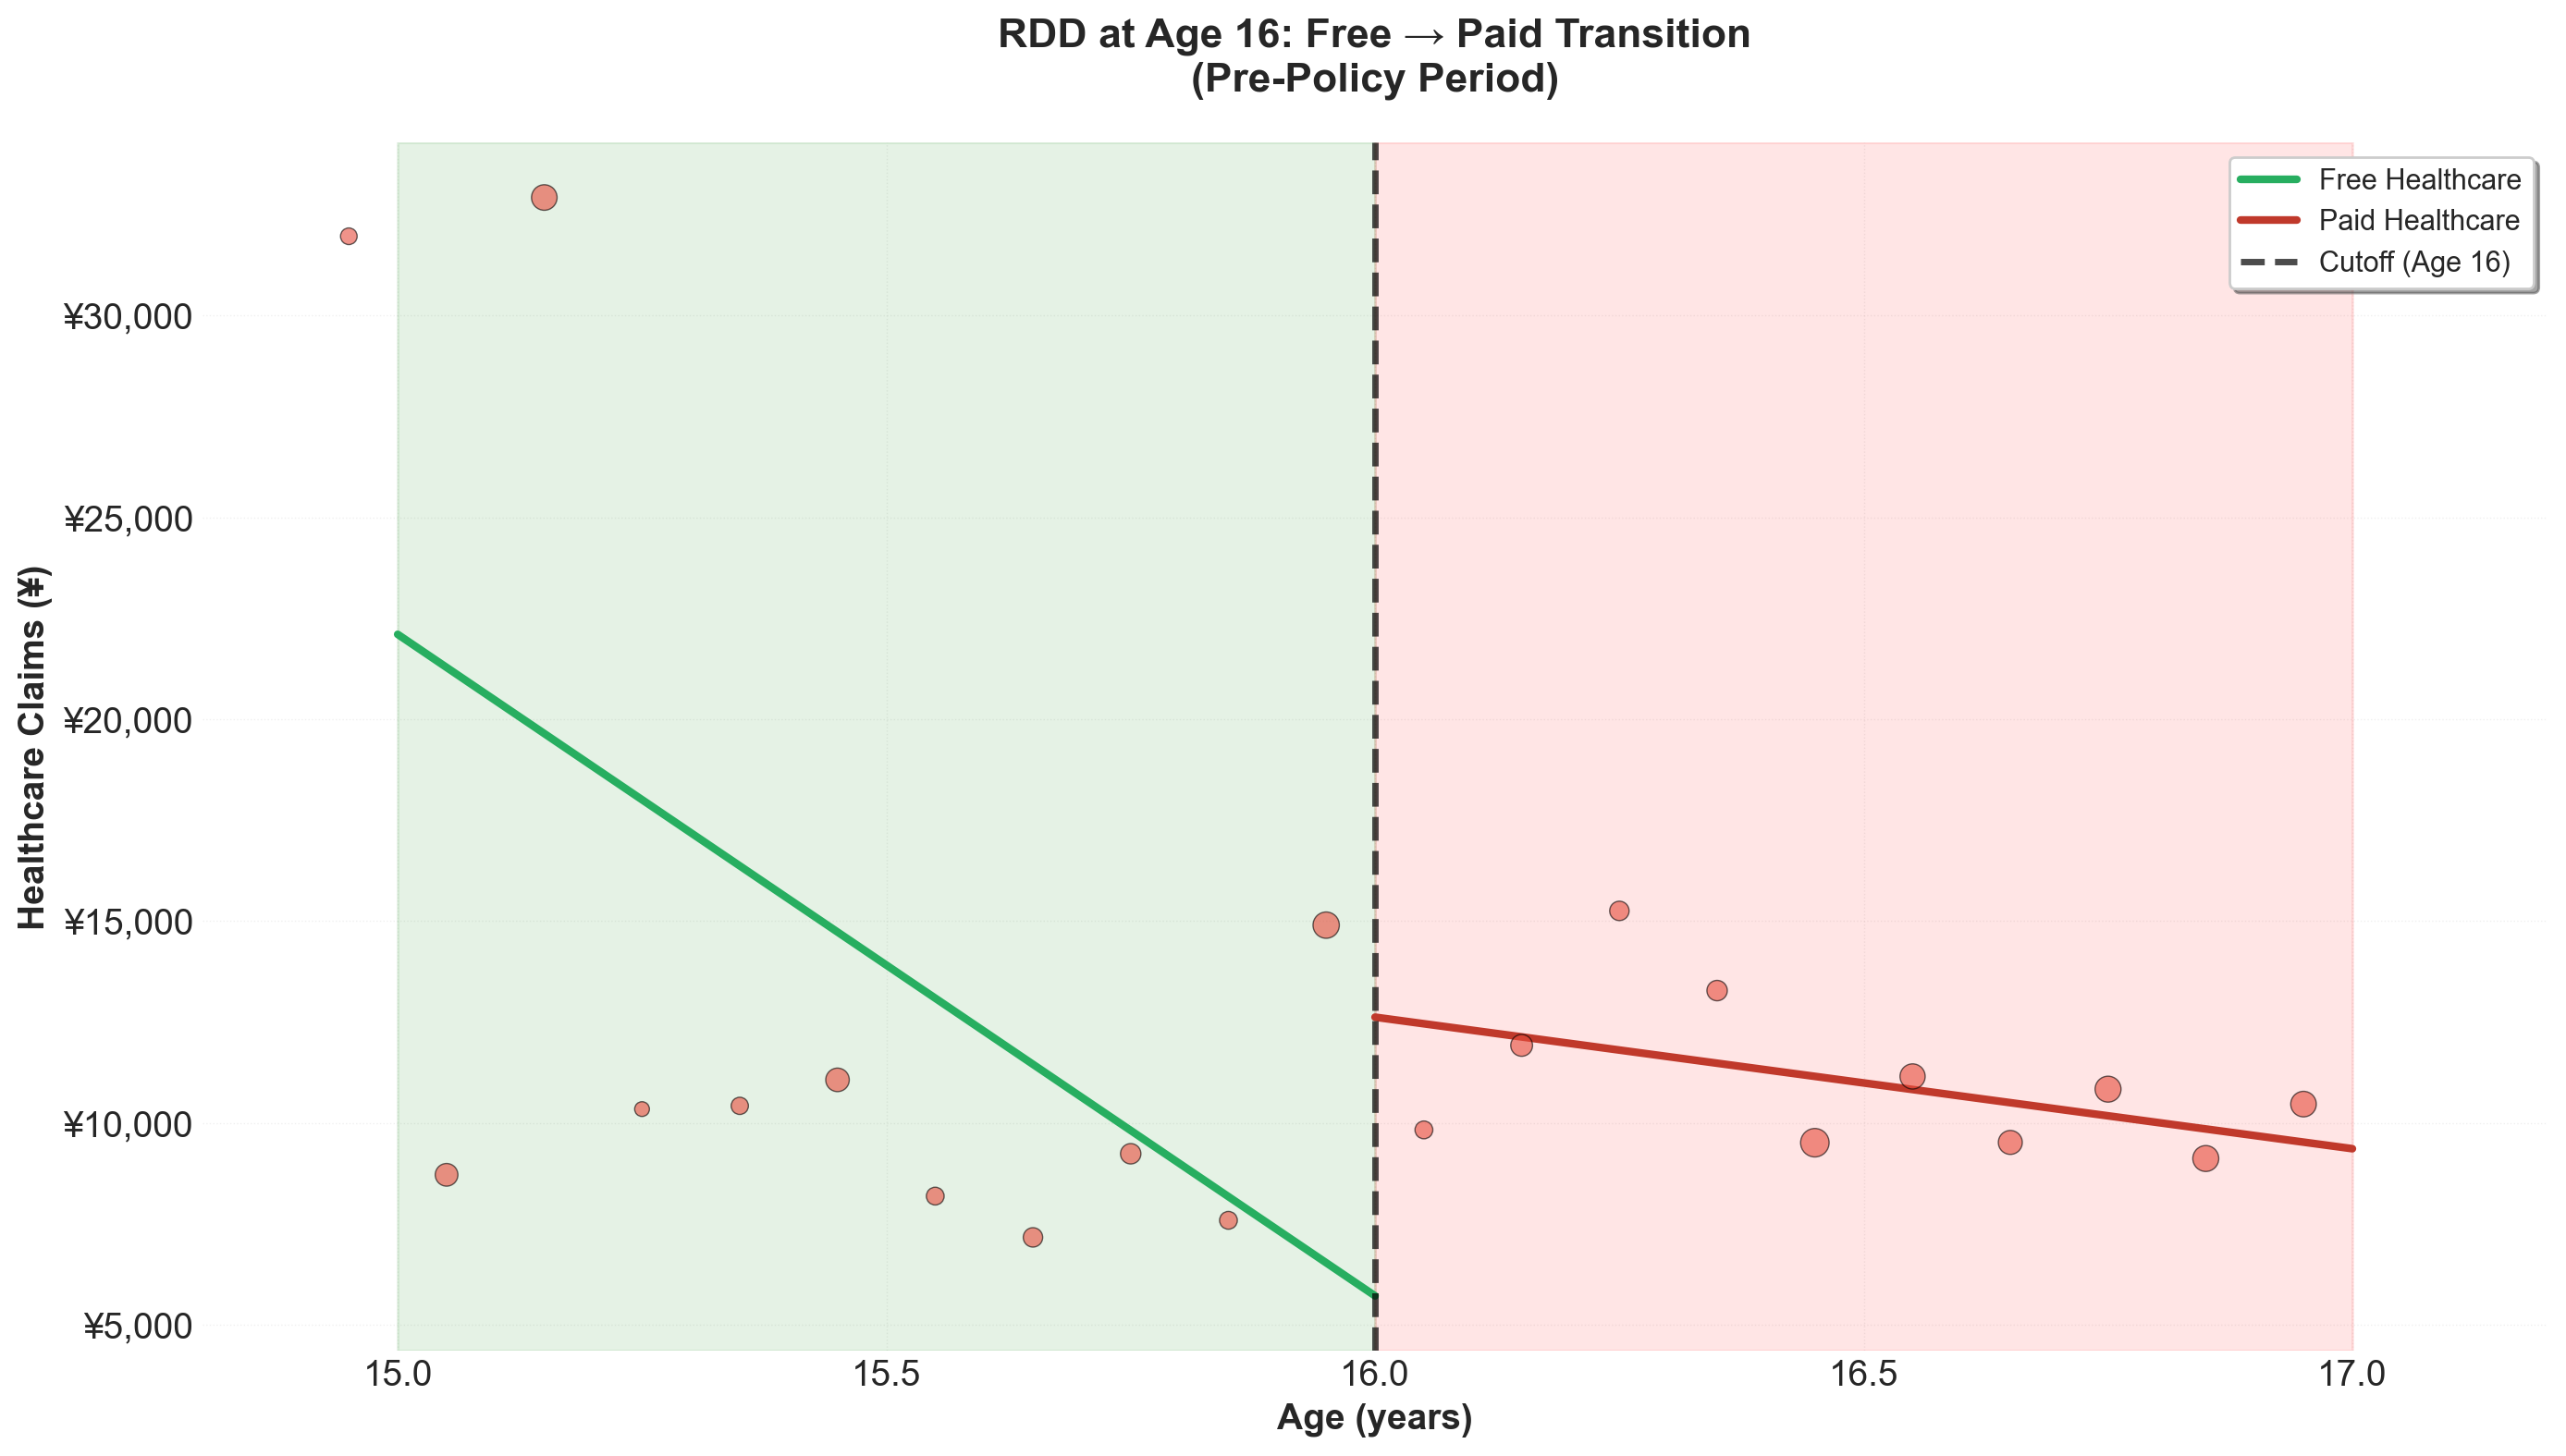


2️⃣  Age 17 Cutoff (Double RDD)...

📊 Age 17 Double RDD:
   Observations: 832
   Pre-policy: 301
   Post-policy: 531


/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_43461/4066054633.py:174: UserWarning: The figure layout has changed to tight


✅ Saved: figures/rdd_cutoff_age17.png


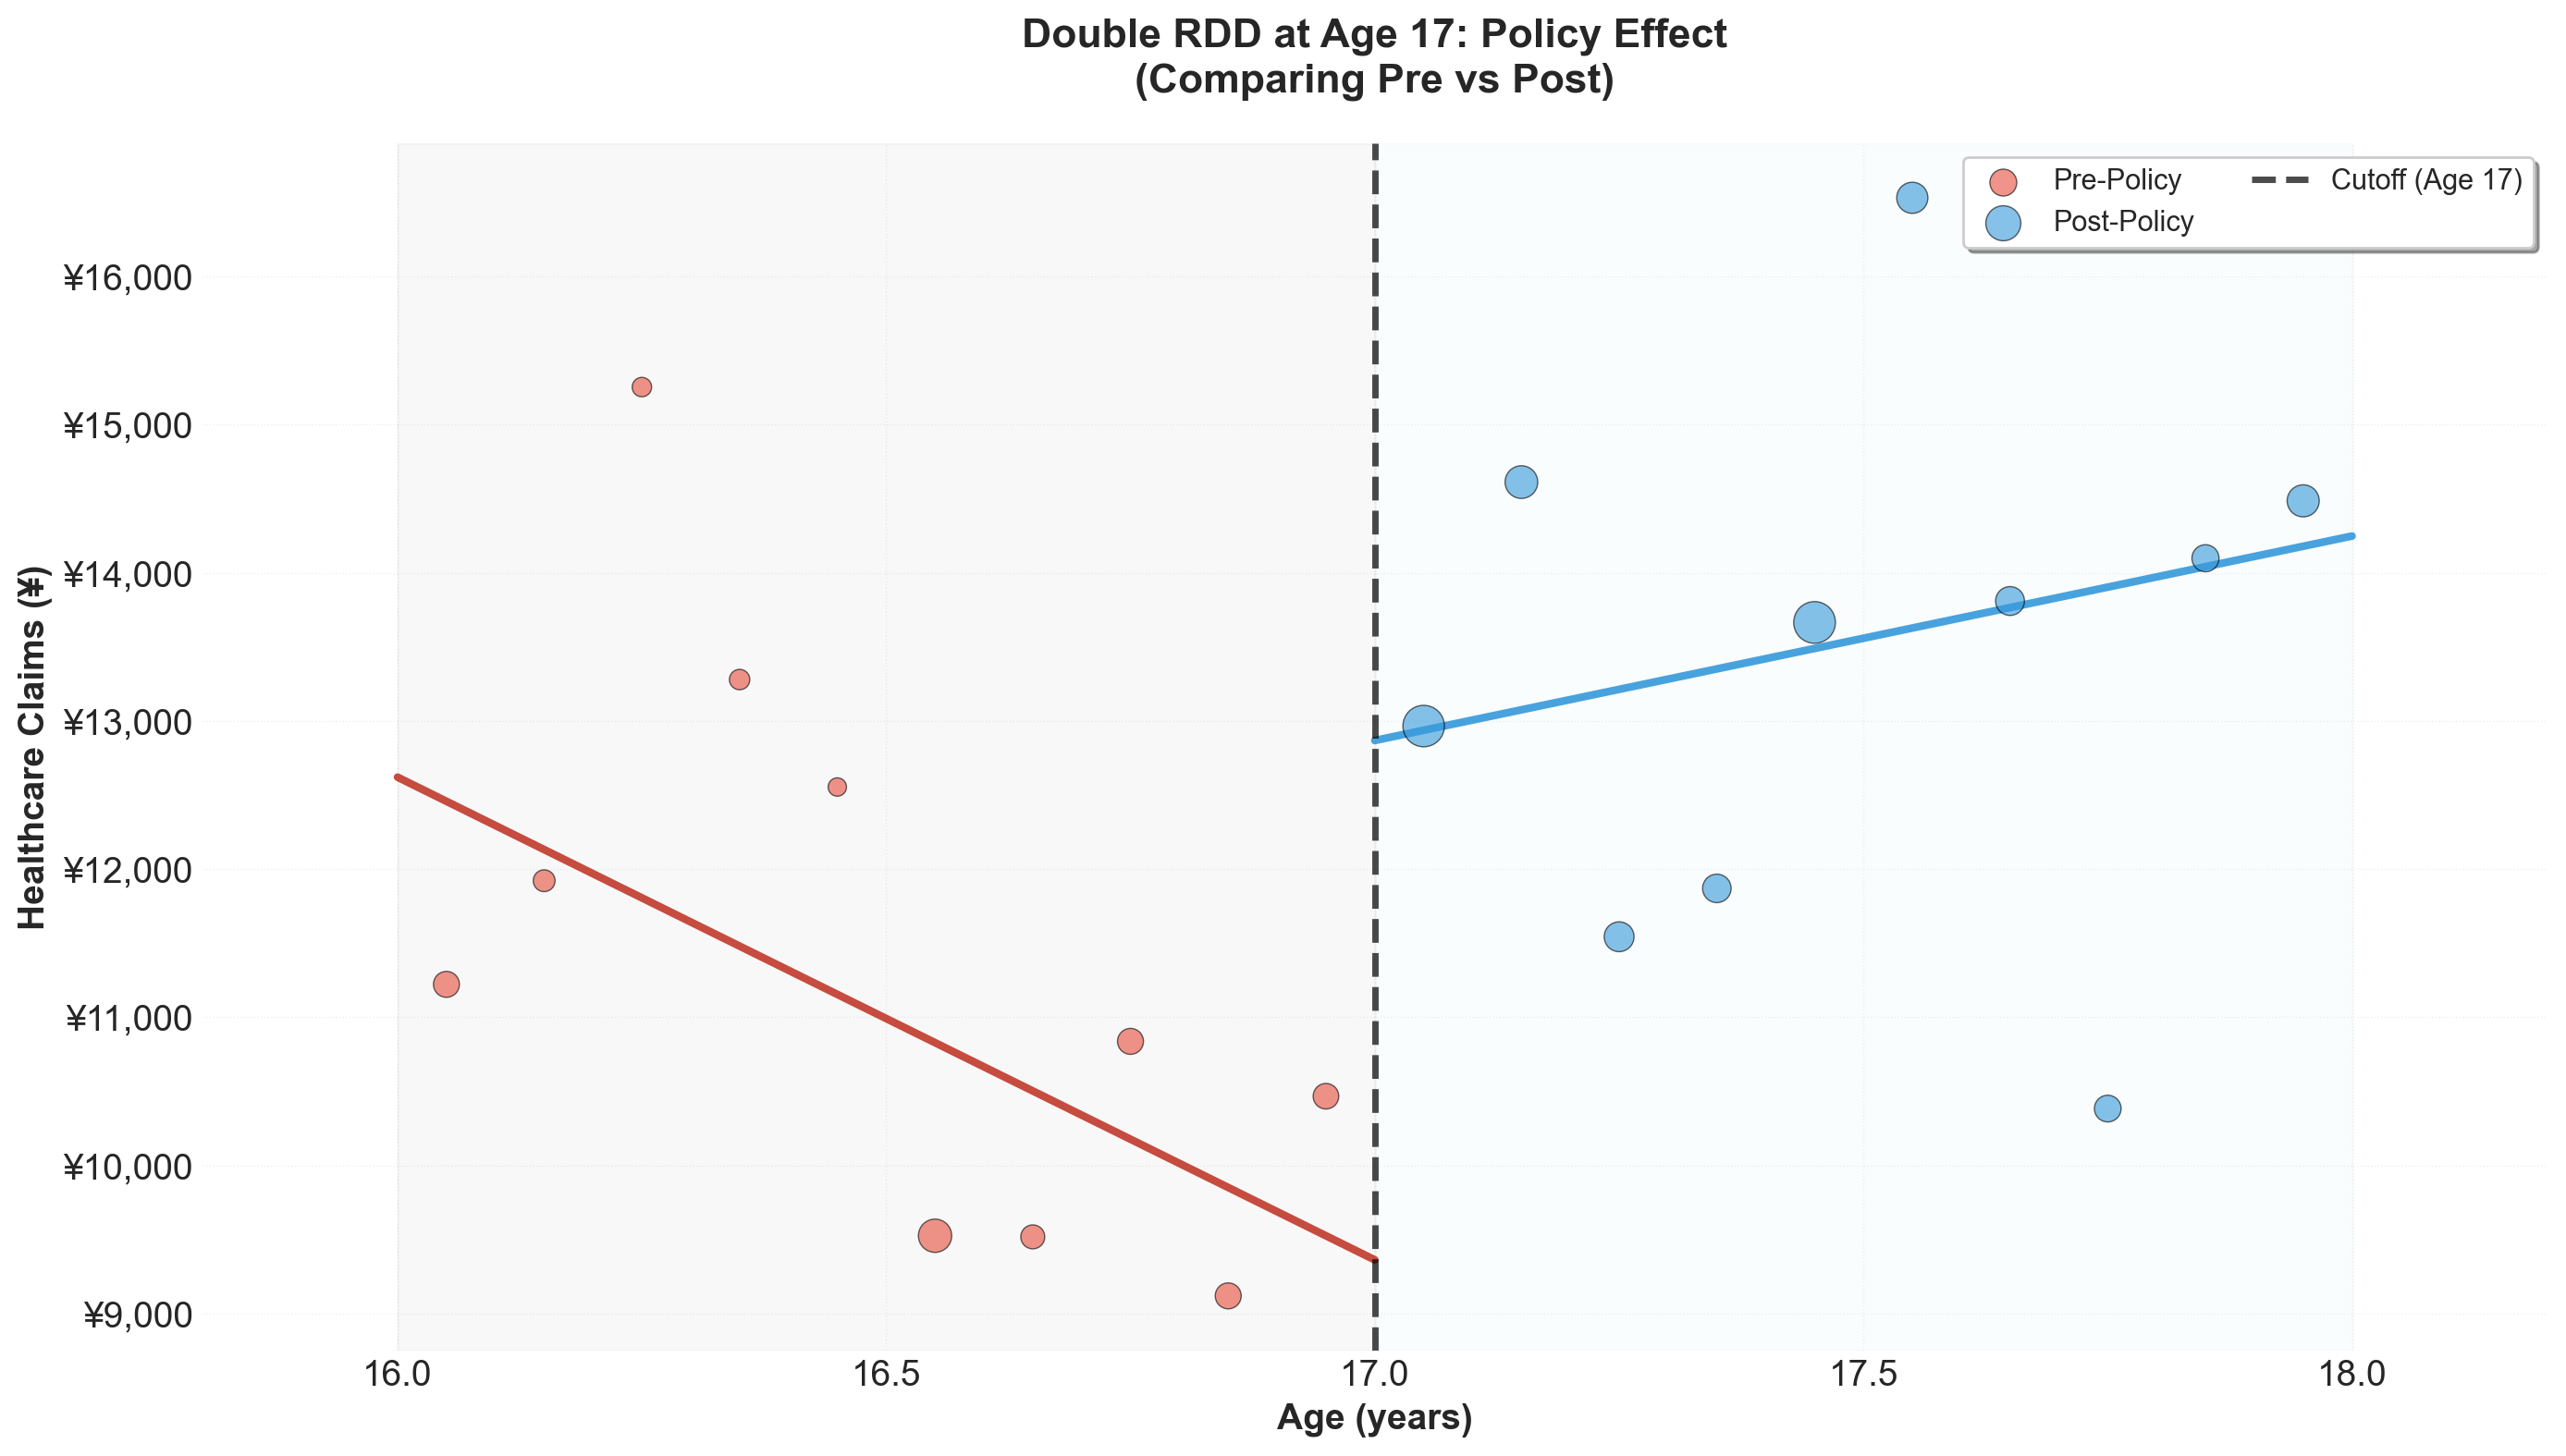


✅ BOTH PLOTS CREATED!

📁 Saved to:
   • figures/rdd_cutoff_age16.png
   • figures/rdd_cutoff_age17.png


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Setup
sns.set_style("whitegrid")
os.makedirs('figures', exist_ok=True)

# ═══════════════════════════════════════════════════════════════════════
# PLOT 1: AGE 16 CUTOFF (PRE-POLICY: FREE → PAID)
# ═══════════════════════════════════════════════════════════════════════

def plot_rdd_age16(rdd_analyzer, save_path=None):
    """
    RDD at age 16 - Pre-policy only
    Shows Free → Paid transition
    Age range: 15.0-17.0
    """
    
    cutoff = 16
    outcome = "ika_out_req_amt"
    
    df = rdd_analyzer.data.copy()
    df = df[df['post_policy'] == 0]  # Pre-policy only
    df = df[(df['age_adjusted'] >= 15.0) & (df['age_adjusted'] <= 17.0)]
    
    print(f"\n📊 Age 16 RDD:")
    print(f"   Observations: {len(df):,}")
    print(f"   Age range: {df['age_adjusted'].min():.2f}-{df['age_adjusted'].max():.2f}")
    
    # Binning
    bin_width = 0.1
    df['age_bin'] = (df['age_adjusted'] // bin_width) * bin_width + bin_width/2
    binned = df.groupby('age_bin').agg({
        outcome: 'mean',
        'patient_id': 'count'
    }).reset_index()
    binned.columns = ['age_bin', 'mean_outcome', 'n_obs']
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Scatter
    ax.scatter(binned['age_bin'], binned['mean_outcome'], 
               s=binned['n_obs']*3, alpha=0.6, color='#E74C3C',
               edgecolors='black', linewidths=0.5, zorder=3)
    
    # Fit lines
    df_left = df[df['age_adjusted'] < cutoff]
    if len(df_left) > 10:
        x, y = df_left['age_adjusted'].values, df_left[outcome].values
        poly = np.poly1d(np.polyfit(x, y, 1))
        x_range = np.linspace(15.0, cutoff, 50)
        ax.plot(x_range, poly(x_range), color='#27AE60', 
                linewidth=3, label='Free Healthcare', zorder=2)
    
    df_right = df[df['age_adjusted'] >= cutoff]
    if len(df_right) > 10:
        x, y = df_right['age_adjusted'].values, df_right[outcome].values
        poly = np.poly1d(np.polyfit(x, y, 1))
        x_range = np.linspace(cutoff, 17.0, 50)
        ax.plot(x_range, poly(x_range), color='#C0392B',
                linewidth=3, label='Paid Healthcare', zorder=2)
    
    # Styling
    ax.axvline(x=cutoff, color='black', linestyle='--', linewidth=2.5,
              label=f'Cutoff (Age {cutoff})', alpha=0.7)
    ax.axvspan(15.0, cutoff, alpha=0.1, color='green')
    ax.axvspan(cutoff, 17.0, alpha=0.1, color='red')
    
    ax.set_xlabel('Age (years)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Healthcare Claims (¥)', fontsize=14, fontweight='bold')
    ax.set_title('RDD at Age 16: Free → Paid Transition\n(Pre-Policy Period)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlim(14.8, 17.2)
    ax.legend(loc='best', fontsize=11, frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")
    
    plt.show()
    return fig, ax


# ═══════════════════════════════════════════════════════════════════════
# PLOT 2: AGE 17 CUTOFF (DOUBLE RDD: PRE VS POST)
# ═══════════════════════════════════════════════════════════════════════

def plot_rdd_age17(rdd_analyzer, save_path=None):
    """
    Double RDD at age 17
    Compares pre-policy vs post-policy
    Age range: 16.0-18.0
    """
    
    cutoff = 17
    outcome = "ika_out_req_amt"
    
    df = rdd_analyzer.data.copy()
    df = df[(df['age_adjusted'] >= 16.0) & (df['age_adjusted'] <= 18.0)]
    
    print(f"\n📊 Age 17 Double RDD:")
    print(f"   Observations: {len(df):,}")
    print(f"   Pre-policy: {(df['post_policy']==0).sum():,}")
    print(f"   Post-policy: {(df['post_policy']==1).sum():,}")
    
    # Binning
    bin_width = 0.1
    df['age_bin'] = (df[f'age_centered_{cutoff}'] // bin_width) * bin_width + bin_width/2
    binned = df.groupby(['age_bin', 'post_policy']).agg({
        outcome: 'mean',
        'patient_id': 'count'
    }).reset_index()
    binned.columns = ['age_bin', 'post_policy', 'mean_outcome', 'n_obs']
    binned['age_actual'] = binned['age_bin'] + cutoff
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = {0: '#E74C3C', 1: '#3498DB'}
    labels = {0: 'Pre-Policy', 1: 'Post-Policy'}
    
    # Scatter
    for period in [0, 1]:
        data = binned[binned['post_policy'] == period]
        ax.scatter(data['age_actual'], data['mean_outcome'],
                  s=data['n_obs']*3, alpha=0.6, color=colors[period],
                  label=labels[period], edgecolors='black', 
                  linewidths=0.5, zorder=3)
    
    # Fit lines
    for period, base_color in [(0, '#E74C3C'), (1, '#3498DB')]:
        # Left
        df_left = df[(df['post_policy']==period) & (df['age_adjusted']<cutoff)]
        if len(df_left) > 10:
            x, y = df_left['age_adjusted'].values, df_left[outcome].values
            poly = np.poly1d(np.polyfit(x, y, 1))
            x_range = np.linspace(16.0, cutoff, 50)
            color_left = '#C0392B' if period==0 else '#2471A3'
            ax.plot(x_range, poly(x_range), color=color_left,
                   linewidth=3, alpha=0.9, zorder=2)
        
        # Right
        df_right = df[(df['post_policy']==period) & (df['age_adjusted']>=cutoff)]
        if len(df_right) > 10:
            x, y = df_right['age_adjusted'].values, df_right[outcome].values
            poly = np.poly1d(np.polyfit(x, y, 1))
            x_range = np.linspace(cutoff, 18.0, 50)
            ax.plot(x_range, poly(x_range), color=base_color,
                   linewidth=3, alpha=0.9, zorder=2)
    
    # Styling
    ax.axvline(x=cutoff, color='black', linestyle='--', linewidth=2.5,
              label=f'Cutoff (Age {cutoff})', alpha=0.7)
    ax.axvspan(16.0, cutoff, alpha=0.05, color='gray')
    ax.axvspan(cutoff, 18.0, alpha=0.05, color='lightblue')
    
    ax.set_xlabel('Age (years)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Healthcare Claims (¥)', fontsize=14, fontweight='bold')
    ax.set_title('Double RDD at Age 17: Policy Effect\n(Comparing Pre vs Post)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlim(15.8, 18.2)
    ax.legend(loc='best', fontsize=11, ncol=2, frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {save_path}")
    
    plt.show()
    return fig, ax


# ═══════════════════════════════════════════════════════════════════════
# RUN BOTH PLOTS
# ═══════════════════════════════════════════════════════════════════════

print("="*80)
print("CREATING TWO RDD PLOTS")
print("="*80)

# Plot 1: Age 16
print("\n1️⃣  Age 16 Cutoff (Free → Paid)...")
fig1, ax1 = plot_rdd_age16(
    rdd_analyzer=rdd,
    save_path='figures/rdd_cutoff_age16.png'
)

# Plot 2: Age 17
print("\n2️⃣  Age 17 Cutoff (Double RDD)...")
fig2, ax2 = plot_rdd_age17(
    rdd_analyzer=rdd,
    save_path='figures/rdd_cutoff_age17.png'
)

print("\n" + "="*80)
print("✅ BOTH PLOTS CREATED!")
print("="*80)
print("\n📁 Saved to:")
print("   • figures/rdd_cutoff_age16.png")
print("   • figures/rdd_cutoff_age17.png")

In [52]:
# ═══════════════════════════════════════════════════════════════════════
# COMPLETE CORRECTED RDD ANALYSIS
# Age 16 Cutoff (Pre-policy) + Age 17 Cutoff (Double RDD)
# ═══════════════════════════════════════════════════════════════════════

import polars as pl
import pandas as pd
import numpy as np
import pickle

# ═══════════════════════════════════════════════════════════════════════
# STEP 1: Load Data
# ═══════════════════════════════════════════════════════════════════════

# Or run full pipeline:
"""
df_rdd = process_parquet_folder_RDD(
    folder_path="path/to/parquet",
    treatment_area=231002,
    date_base=202201,
    age_base=17,
    Y="ika_out_req_amt"
)
df_rdd = add_rdd_variables(df_rdd, policy_date=202201)
df_rdd.write_parquet("processed_rdd_data.parquet")
"""

print("✅ Data loaded!")
print(f"Shape: {df_rdd.shape}")

# ═══════════════════════════════════════════════════════════════════════
# STEP 2: Initialize RDD Analyzer
# ═══════════════════════════════════════════════════════════════════════

rdd = MultiCutoffDoubleRDD(data=df_rdd, policy_date="202201")


# ═══════════════════════════════════════════════════════════════════════
# ANALYSIS 1: AGE 16 CUTOFF (PRE-POLICY ONLY)
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("ANALYSIS 1: AGE 16 CUTOFF (FREE → PAID TRANSITION)")
print("="*80)
print("Period: Pre-policy only")
print("Age range: 15.0-17.0")
print("Expected: Negative effect (utilization decreases)")
print("="*80 + "\n")

# Main specification: Linear, BW=±1.0
print("─"*80)
print("Main Specification: Linear, Bandwidth = ±1.0 year")
print("─"*80)

result_16_main = rdd.estimate_single_cutoff_rdd(
    outcome="ika_out_req_amt",
    cutoff=16,
    polynomial_order=1,
    bandwidth=1.0,
    pre_only=True  # Pre-policy only!
)

# Extract key results
tau_16 = result_16_main.params.get('above_16', np.nan)
se_16 = result_16_main.bse.get('above_16', np.nan)
pval_16 = result_16_main.pvalues.get('above_16', np.nan)
n_16 = len(result_16_main.model.data.frame)

print(f"\n🎯 KEY RESULT (Age 16):")
print(f"   Effect: ¥{tau_16:,.0f}")
print(f"   Std Error: ¥{se_16:,.0f}")
print(f"   P-value: {pval_16:.4f}")
print(f"   95% CI: [¥{tau_16-1.96*se_16:,.0f}, ¥{tau_16+1.96*se_16:,.0f}]")
print(f"   Sample: {n_16:,} observations")

# Robustness: Different bandwidths
print("\n" + "─"*80)
print("Bandwidth Sensitivity (Age 16)")
print("─"*80)

bw_results_16 = []
for bw in [0.5, 0.75, 1.0]:
    print(f"\nBandwidth ±{bw} year:")
    res = rdd.estimate_single_cutoff_rdd(
        outcome="ika_out_req_amt",
        cutoff=16,
        polynomial_order=1,
        bandwidth=bw,
        pre_only=True
    )
    
    bw_results_16.append({
        'Bandwidth': f'±{bw}',
        'Coefficient': res.params.get('above_16', np.nan),
        'Std_Error': res.bse.get('above_16', np.nan),
        'P_value': res.pvalues.get('above_16', np.nan),
        'N_obs': len(res.model.data.frame)
    })

bw_df_16 = pd.DataFrame(bw_results_16)
bw_df_16['Significance'] = bw_df_16['P_value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
)

print("\n" + "="*80)
print("AGE 16 BANDWIDTH SENSITIVITY SUMMARY")
print("="*80)
print(f"\n{'Bandwidth':<12} {'Coefficient':<15} {'Std Error':<12} {'P-value':<12} {'N':<8}")
print("─"*80)
for _, row in bw_df_16.iterrows():
    print(f"{row['Bandwidth']:<12} ¥{row['Coefficient']:>12,.0f}  ¥{row['Std_Error']:>10,.0f}  "
          f"{row['P_value']:.4f}{row['Significance']:<3}  {int(row['N_obs']):>6,}")

# Robustness: Quadratic specification
print("\n" + "─"*80)
print("Functional Form Check: Quadratic (Age 16)")
print("─"*80)

result_16_quad = rdd.estimate_single_cutoff_rdd(
    outcome="ika_out_req_amt",
    cutoff=16,
    polynomial_order=2,
    bandwidth=1.0,
    pre_only=True
)

tau_16_quad = result_16_quad.params.get('above_16', np.nan)
se_16_quad = result_16_quad.bse.get('above_16', np.nan)
pval_16_quad = result_16_quad.pvalues.get('above_16', np.nan)


# ═══════════════════════════════════════════════════════════════════════
# ANALYSIS 2: AGE 17 CUTOFF (DOUBLE RDD)
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("ANALYSIS 2: AGE 17 CUTOFF (DOUBLE RDD)")
print("="*80)
print("Period: Both pre and post-policy")
print("Age range: 16.0-18.0 (CRITICAL: Must exclude ages <16)")
print("Expected: Positive change (policy increases utilization)")
print("="*80 + "\n")

# Main specification: Linear, BW=±1.0
print("─"*80)
print("Main Specification: Linear, Bandwidth = ±1.0 year")
print("─"*80)

result_17_main = rdd.estimate_double_rdd(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=1,
    bandwidth=1.0  # SAFE: Ages 16.0-18.0
)

# Extract key results
tau_17 = result_17_main.params.get('post_X_above17', np.nan)
se_17 = result_17_main.bse.get('post_X_above17', np.nan)
pval_17 = result_17_main.pvalues.get('post_X_above17', np.nan)
n_17 = len(result_17_main.model.data.frame)

# Pre-policy effect
pre_17 = result_17_main.params.get('above_17', np.nan)
se_pre_17 = result_17_main.bse.get('above_17', np.nan)
pval_pre_17 = result_17_main.pvalues.get('above_17', np.nan)

# Implied post-policy effect
post_17 = pre_17 + tau_17

print(f"\n🎯 KEY RESULTS (Age 17 Double RDD):")
print(f"\n1. Pre-Policy Discontinuity:")
print(f"   Effect: ¥{pre_17:,.0f} (p={pval_pre_17:.4f})")
print(f"   Expected: ~0 (no jump, still paid)")

print(f"\n2. CHANGE in Discontinuity (Policy Effect):")
print(f"   Effect: ¥{tau_17:,.0f}")
print(f"   Std Error: ¥{se_17:,.0f}")
print(f"   P-value: {pval_17:.4f}")
print(f"   95% CI: [¥{tau_17-1.96*se_17:,.0f}, ¥{tau_17+1.96*se_17:,.0f}]")
print(f"   This is the KEY parameter!")

print(f"\n3. Implied Post-Policy Discontinuity:")
print(f"   Effect: ¥{post_17:,.0f}")
print(f"   Expected: Positive (paid→free)")

print(f"\n4. Sample:")
print(f"   Total: {n_17:,} observations")

# Robustness: Different bandwidths (all safe for age 17)
print("\n" + "─"*80)
print("Bandwidth Sensitivity (Age 17)")
print("─"*80)

bw_results_17 = []
for bw in [0.5, 0.75, 1.0]:
    print(f"\nBandwidth ±{bw} year (Age range: {17-bw:.1f}-{17+bw:.1f}):")
    res = rdd.estimate_double_rdd(
        outcome="ika_out_req_amt",
        cutoff=17,
        polynomial_order=1,
        bandwidth=bw
    )
    
    bw_results_17.append({
        'Bandwidth': f'±{bw}',
        'Age_Range': f'{17-bw:.1f}-{17+bw:.1f}',
        'Coefficient': res.params.get('post_X_above17', np.nan),
        'Std_Error': res.bse.get('post_X_above17', np.nan),
        'P_value': res.pvalues.get('post_X_above17', np.nan),
        'N_obs': len(res.model.data.frame)
    })

bw_df_17 = pd.DataFrame(bw_results_17)
bw_df_17['Significance'] = bw_df_17['P_value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
)

print("\n" + "="*80)
print("AGE 17 BANDWIDTH SENSITIVITY SUMMARY")
print("="*80)
print(f"\n{'Bandwidth':<12} {'Age Range':<15} {'Coefficient':<15} {'Std Error':<12} {'P-value':<12} {'N':<8}")
print("─"*80)
for _, row in bw_df_17.iterrows():
    print(f"{row['Bandwidth']:<12} {row['Age_Range']:<15} ¥{row['Coefficient']:>12,.0f}  "
          f"¥{row['Std_Error']:>10,.0f}  {row['P_value']:.4f}{row['Significance']:<3}  {int(row['N_obs']):>6,}")

# Robustness: Quadratic specification
print("\n" + "─"*80)
print("Functional Form Check: Quadratic (Age 17)")
print("─"*80)

result_17_quad = rdd.estimate_double_rdd(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=2,
    bandwidth=1.0
)

tau_17_quad = result_17_quad.params.get('post_X_above17', np.nan)
se_17_quad = result_17_quad.bse.get('post_X_above17', np.nan)
pval_17_quad = result_17_quad.pvalues.get('post_X_above17', np.nan)

# Robustness: Stepwise Double RDD
print("\n" + "─"*80)
print("Alternative Estimation: Stepwise Double RDD (Age 17)")
print("─"*80)

result_17_stepwise = rdd.estimate_double_rdd_separate(
    outcome="ika_out_req_amt",
    cutoff=17,
    polynomial_order=1,
    bandwidth=1.0
)


# ═══════════════════════════════════════════════════════════════════════
# COMPARISON TABLES
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SPECIFICATION COMPARISON: AGE 16")
print("="*80)

comp_df_16 = pd.DataFrame([
    {
        'Specification': 'Linear (BW=±1.0)',
        'Coefficient': tau_16,
        'Std_Error': se_16,
        'P_value': pval_16,
        'N_obs': n_16
    },
    {
        'Specification': 'Quadratic (BW=±1.0)',
        'Coefficient': tau_16_quad,
        'Std_Error': se_16_quad,
        'P_value': pval_16_quad,
        'N_obs': len(result_16_quad.model.data.frame)
    }
])

comp_df_16['Significance'] = comp_df_16['P_value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
)

print(f"\n{'Specification':<25} {'Coefficient':<15} {'Std Error':<12} {'P-value':<12} {'N':<8}")
print("─"*80)
for _, row in comp_df_16.iterrows():
    print(f"{row['Specification']:<25} ¥{row['Coefficient']:>12,.0f}  ¥{row['Std_Error']:>10,.0f}  "
          f"{row['P_value']:.4f}{row['Significance']:<3}  {int(row['N_obs']):>6,}")

print("\n" + "="*80)
print("SPECIFICATION COMPARISON: AGE 17")
print("="*80)

comp_df_17 = pd.DataFrame([
    {
        'Specification': 'Linear (BW=±1.0)',
        'Coefficient': tau_17,
        'Std_Error': se_17,
        'P_value': pval_17,
        'N_obs': n_17
    },
    {
        'Specification': 'Quadratic (BW=±1.0)',
        'Coefficient': tau_17_quad,
        'Std_Error': se_17_quad,
        'P_value': pval_17_quad,
        'N_obs': len(result_17_quad.model.data.frame)
    },
    {
        'Specification': 'Stepwise (BW=±1.0)',
        'Coefficient': result_17_stepwise['delta'],
        'Std_Error': result_17_stepwise['se_delta'],
        'P_value': result_17_stepwise['p_value'],
        'N_obs': n_17
    }
])

comp_df_17['Significance'] = comp_df_17['P_value'].apply(
    lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
)

print(f"\n{'Specification':<25} {'Coefficient':<15} {'Std Error':<12} {'P-value':<12} {'N':<8}")
print("─"*80)
for _, row in comp_df_17.iterrows():
    print(f"{row['Specification']:<25} ¥{row['Coefficient']:>12,.0f}  ¥{row['Std_Error']:>10,.0f}  "
          f"{row['P_value']:.4f}{row['Significance']:<3}  {int(row['N_obs']):>6,}")


# ═══════════════════════════════════════════════════════════════════════
# SAVE RESULTS
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80 + "\n")

# Save bandwidth sensitivity tables
bw_df_16.to_csv("results/age16_bandwidth_sensitivity.csv", index=False)
print("✅ Age 16 bandwidth sensitivity: results/age16_bandwidth_sensitivity.csv")

bw_df_17.to_csv("results/age17_bandwidth_sensitivity.csv", index=False)
print("✅ Age 17 bandwidth sensitivity: results/age17_bandwidth_sensitivity.csv")

# Save specification comparisons
comp_df_16.to_csv("results/age16_specification_comparison.csv", index=False)
print("✅ Age 16 specification comparison: results/age16_specification_comparison.csv")

comp_df_17.to_csv("results/age17_specification_comparison.csv", index=False)
print("✅ Age 17 specification comparison: results/age17_specification_comparison.csv")

# Save main results table
main_results = pd.DataFrame([
    {
        'Analysis': 'Age 16 (Pre-Policy)',
        'Cutoff': 16,
        'Transition': 'Free → Paid',
        'Coefficient': tau_16,
        'Std_Error': se_16,
        'P_value': pval_16,
        'CI_Lower': tau_16 - 1.96*se_16,
        'CI_Upper': tau_16 + 1.96*se_16,
        'N_obs': n_16,
        'Significant': 'Yes' if pval_16 < 0.05 else 'No'
    },
    {
        'Analysis': 'Age 17 (Double RDD)',
        'Cutoff': 17,
        'Transition': 'Policy Effect',
        'Coefficient': tau_17,
        'Std_Error': se_17,
        'P_value': pval_17,
        'CI_Lower': tau_17 - 1.96*se_17,
        'CI_Upper': tau_17 + 1.96*se_17,
        'N_obs': n_17,
        'Significant': 'Yes' if pval_17 < 0.05 else 'No'
    }
])

main_results.to_csv("results/main_rdd_results.csv", index=False)
print("✅ Main results table: results/main_rdd_results.csv")

# Save all results objects
all_results = {
    'age16_main': result_16_main,
    'age16_quad': result_16_quad,
    'age16_bandwidth_sensitivity': bw_df_16,
    'age16_comparison': comp_df_16,
    'age17_main': result_17_main,
    'age17_quad': result_17_quad,
    'age17_stepwise': result_17_stepwise,
    'age17_bandwidth_sensitivity': bw_df_17,
    'age17_comparison': comp_df_17,
    'main_results_table': main_results
}

with open('results/all_rdd_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

print("✅ All results objects: results/all_rdd_results.pkl")


# ═══════════════════════════════════════════════════════════════════════
# FINAL SUMMARY
# ═══════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("📊 FINAL SUMMARY")
print("="*80)

print(f"\n{'Analysis':<25} {'Effect (¥)':<15} {'P-value':<12} {'Significant':<15}")
print("─"*80)
print(f"{'Age 16 (Free→Paid)':<25} {tau_16:>12,.0f}  {pval_16:>10.4f}  {'YES ✓' if pval_16<0.05 else 'NO ✗':<15}")
print(f"{'Age 17 (Policy Effect)':<25} {tau_17:>12,.0f}  {pval_17:>10.4f}  {'YES ✓' if pval_17<0.05 else 'NO ✗':<15}")

print(f"\n💡 INTERPRETATION:")

# Age 16
if pval_16 < 0.05:
    direction = "decreased" if tau_16 < 0 else "increased"
    print(f"\nAge 16: Healthcare utilization significantly {direction} by ¥{abs(tau_16):,.0f}")
    print(f"        when care became paid at age 16 (pre-policy period).")
else:
    print(f"\nAge 16: No significant change detected at the free→paid transition.")

# Age 17
if pval_17 < 0.05:
    direction = "increased" if tau_17 > 0 else "decreased"
    print(f"\nAge 17: The policy significantly {direction} healthcare utilization by ¥{abs(tau_17):,.0f}")
    print(f"        when care became free again at age 17.")
else:
    print(f"\nAge 17: No significant policy effect detected.")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80 + "\n")

✅ Data loaded!
Shape: (1497, 10)
✅ Multi-Cutoff RDD Data Preparation Complete
Total observations: 1,497
Pre-policy (medtreat_yymm < 202201): 966
Post-policy (medtreat_yymm >= 202201): 531
Unique patients: 108

──────────────────────────────────────────────────────────────────────
Age distribution around cutoffs:
──────────────────────────────────────────────────────────────────────

Cutoff age 16:
  Within ±0.5 years: 241 obs
  Within ±1.0 years: 563 obs
  Within ±2.0 years: 1,288 obs

Cutoff age 17:
  Within ±0.5 years: 501 obs
  Within ±1.0 years: 832 obs
  Within ±2.0 years: 1,048 obs

Cutoff age 18:
  Within ±0.5 years: 265 obs
  Within ±1.0 years: 531 obs
  Within ±2.0 years: 832 obs



ANALYSIS 1: AGE 16 CUTOFF (FREE → PAID TRANSITION)
Period: Pre-policy only
Age range: 15.0-17.0
Expected: Negative effect (utilization decreases)

────────────────────────────────────────────────────────────────────────────────
Main Specification: Linear, Bandwidth = ±1.0 year
─────────────────────

/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 3
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance o

# Using the Package

## Non-Parametric RDD

In [105]:
Y = df_RDD["ika_out_req_amt"]
X = df_RDD["age_adjusted"]
result = rdrobust(Y, X, c=17, h=2)
print(result)

Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                   832
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                   Manual
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           301        531
Number of Unique Obs.             12         12
Number of Effective Obs.         301        531
Bandwidth Estimation               2          2
Bandwidth Bias                     2          2
rho (h/b)                        1.0        1.0

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional    27413.479 17866.845    1.534   1.250e-01 [-7604.894, 62431.851]
Robust                 -        -    0.047   9.621e

Mass points detected in the running variable.


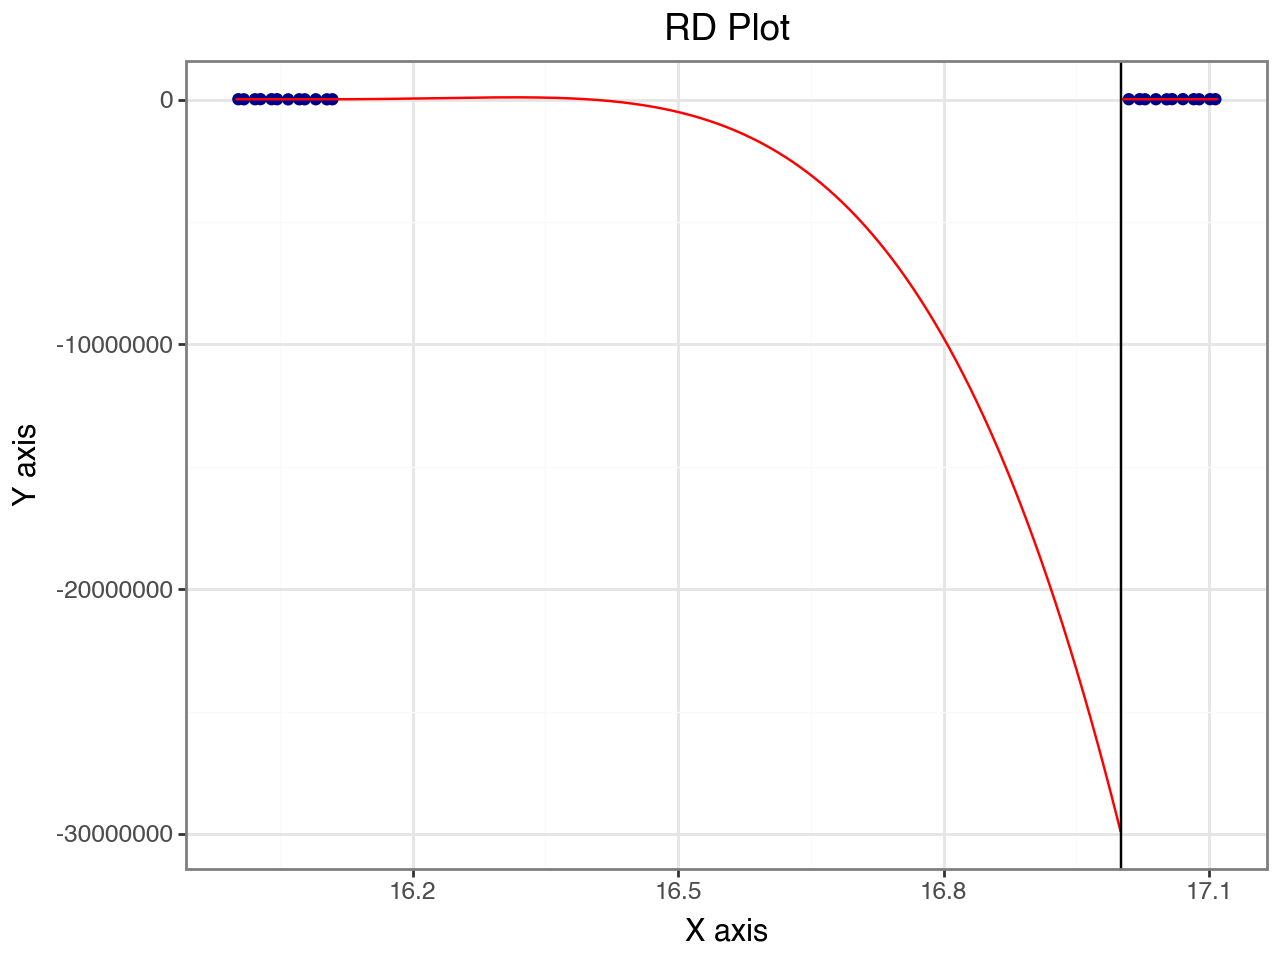

Call: rdplot
Number of Observations:                   832
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           301        531
Number of Effective Obs          301        531
Bandwith poly. fit (h)           1.0       0.11
Number of bins scale               1          1
Bins Selected                    160         18
Average Bin Length             0.006        nan
Median Bin Length              0.006        nan
IMSE-optimal bins               14.0        1.0
Mimicking Variance bins        160.0       18.0

Relative to IMSE-optimal:
Implied scale                 11.429       18.0
WIMSE variance weight          0.001        0.0
WIMSE bias weight              0.999        1.0


/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
/Users/lex/CodeProjects/DataScienceEnv/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide


In [106]:
import matplotlib.pyplot as plt

# RD plot
from rdrobust import rdplot
rdplot(df_RDD['ika_out_req_amt'], df_RDD['age_adjusted'], c=17.0)

### Summary

Given the results, we can not use the nonparametric RDD in this case. 
(Think of the reasons for this?)

# Conducting the RDD

In [8]:
# This function switches the birthdate for those within the Delta1 range

def add_rdd_birth_date(
    df: pl.DataFrame,
    date_base: int = 202201,  
    age_base: int = 17,        # cutoff age
    delta_flag: str = "Delta1" # which Δ window to use ("Delta1" or "Delta2")
) -> pl.DataFrame:
    """
    Add 'RDD_birth_date' column only for rows where the chosen Δ flag is True.
    For those rows, set RDD_birth_date = (date_base_year - age_base) * 100 + date_base_month.
    """

    # --- basic setup ---
    base_year = date_base // 100
    base_month = date_base % 100
    birth_year = base_year - age_base
    rdd_birth_date_value = birth_year * 100 + base_month

    # --- make sure delta_flag exists ---
    if delta_flag not in df.columns:
        raise ValueError(f"{delta_flag} column not found in DataFrame.")

    # --- create the column ---
    df = df.with_columns(
        pl.when(pl.col(delta_flag) == 1)
          .then(rdd_birth_date_value)
          .otherwise(None)
          .alias("RDD_birth_date")
    )

    df = df.with_columns(
        pl.when(pl.col("age_adjusted") < 17.0)
        .then(1)
        .otherwise(0)
        .alias("PrePolicy")
    )

    print(f"✅ Added 'RDD_birth_date' = {rdd_birth_date_value} for {delta_flag} == 1 rows only.")
    return df

In [9]:
df = add_rdd_birth_date(df_RDD, date_base=202201, age_base=17, delta_flag="Delta1")
df


✅ Added 'RDD_birth_date' = 200501 for Delta1 == 1 rows only.


patient_id,sex_type_nm,birth_date,birth_date_adjusted,medtreat_yymm,age,age_adjusted,Delta1,ika_out_req_amt,RDD_birth_date,PrePolicy
str,f64,i64,i64,i64,f64,f64,i8,i64,i32,i32
"""RI0000185241""",1.0,200502,200501,202203,17.01,17.02,1,26110,200501,0
"""RI0011268400""",0.0,200412,200501,202212,18.0,17.11,1,24510,200501,0
"""RI0011311409""",1.0,200501,200501,202110,16.09,16.09,1,9720,200501,1
"""RI0011244703""",0.0,200501,200501,202205,17.04,17.04,1,65470,200501,0
"""RI0011330342""",0.0,200502,200501,202108,16.06,16.07,1,25970,200501,1
…,…,…,…,…,…,…,…,…,…,…
"""RI0006260898""",0.0,200501,200501,202003,15.02,15.02,1,4880,200501,1
"""RI0011538957""",0.0,200412,200501,202212,18.0,17.11,1,24930,200501,0
"""RI0005403158""",0.0,200501,200501,202108,16.07,16.07,1,5540,200501,1


# Implementing the RDD as a class

In [ ]:
class MultiCutoffDoubleRDD:
    """
    Implements RDD analysis using multiple age cutoffs and double transitions

    Main Logic:
    1. Prepare all necessary running variables, and interactions for RDD
    2. Pre- and Post- Policy
    3. Handling 3 main cutoffs
    """

    # Storing the copy of the input data
    def __init__(self, data, policy_date = "202201"):
        """
        Initializing multi-cutoff RDD analysis

        Args:
            data (DataFrame): Must include: patient_id, age_adjusted, medtreat_yymm, and outcomes.
        policy_date : str
            policy_date (str, optional): Policy implementation month (e.g., '202201')
        """
        self.data = data.to_pandas().copy()
        self.policy_date = policy_date
        self.cutoffs = [16,17,18]
        self.prepare_multi_cutoff_data()

    def prepare_multi_cutoff_data(self):
        """
        Creating the running and treatment variables 
        """

        # Identify policy period: 1 = post-policy, 0 = pre-policy
        self.data['post_policy'] = (
            self.data['medtreat_yymm'].astype(str) >= self.policy_date
        ).astype(int)

        # Generate centered age variables, treatment indicators, and polynomial terms
        for cutoff in self.cutoffs:
            # Running variable centered at each cutoff
            self.data[f'age_centered_{cutoff}'] = self.data['age_adjusted'] - cutoff

            # Indicator for being above (treated side)
            self.data[f'above_{cutoff}'] = (self.data['age_adjusted'] >= cutoff).astype(int)

            # Polynomial powers of the running variable (up to 4th order)
            for power in range(2, 5):
                self.data[f'age_c{cutoff}_p{power}'] = self.data[f'age_centered_{cutoff}'] ** power

            # Interaction terms: allow different slopes left/right of cutoff
            self.data[f'above{cutoff}_X_age'] = (
                self.data[f'above_{cutoff}'] * self.data[f'age_centered_{cutoff}']
            )
            self.data[f'above{cutoff}_X_age2'] = (
                self.data[f'above_{cutoff}'] * self.data[f'age_c{cutoff}_p2']
            )
        
                # === Summary Output ===
        print("✅ Multi-Cutoff Data Preparation Complete")
        print("=" * 60)
        print(f"Total observations: {len(self.data)}")
        print(f"Pre-policy obs: {(1 - self.data['post_policy']).sum()}")
        print(f"Post-policy obs: {self.data['post_policy'].sum()}")
        print("\nAge distribution around cutoffs:")
        for cutoff in self.cutoffs:
            near_cutoff = self.data[abs(self.data[f'age_centered_{cutoff}']) <= 1]
            print(f"  Within ±1 year of age {cutoff}: {len(near_cutoff)} obs")

    # ===============================================================
    #  SINGLE-CUTOFF RDD (for 16 years old, post-policy only)
    # ===============================================================
    def estimate_single_cutoff_rdd(self, outcome, cutoff, polynomial_order=1, bandwidth=None, post_only=False):
        """
        Estimate local RDD around one cutoff (e.g., 16)
        """
        df = self.data.copy()

        if post_only:
            df = df[df["post_policy"] == 1]

        if bandwidth is not None:
            df = df[abs(df[f"age_centered_{cutoff}"]) <= bandwidth]

        # Define regression formula
        if polynomial_order == 1:
            formula = f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + above{cutoff}_X_age"
        elif polynomial_order == 2:
            formula = (
                f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + age_c{cutoff}_p2 + above{cutoff}_X_age + above{cutoff}_X_age2"
            )
        else:
            raise ValueError("Only polynomial_order 1 or 2 supported")

        model = smf.ols(formula, data=df)
        result = model.fit(cov_type="HC3")

        print(f"\n--- RDD at age {cutoff} ---")
        print(result.summary().tables[1])

        return result
    
    # ===============================================================
    #  DOUBLE RDD (for 17 & 18 years old)
    # ===============================================================
    def estimate_double_rdd(self, outcome, cutoff, polynomial_order=1, bandwidth=None):
        """
        Estimate Difference-in-Discontinuities (Double RDD)
        Compares pre- vs post-policy discontinuities at same age cutoff.
        """
        df = self.data.copy()
        if bandwidth is not None:
            df = df[abs(df[f"age_centered_{cutoff}"]) <= bandwidth]

        # Interaction terms
        df[f"post_X_above{cutoff}"] = df["post_policy"] * df[f"above_{cutoff}"]
        df[f"post_X_age_{cutoff}"] = df["post_policy"] * df[f"age_centered_{cutoff}"]
        df[f"post_X_aboveXage_{cutoff}"] = df["post_policy"] * df[f"above_{cutoff}"] * df[f"age_centered_{cutoff}"]

        # Regression formula
        if polynomial_order == 1:
            formula = (
                f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + above{cutoff}_X_age + "
                f"post_policy + post_X_above{cutoff} + post_X_age_{cutoff} + post_X_aboveXage_{cutoff}"
            )
        elif polynomial_order == 2:
            df[f"post_X_age2_{cutoff}"] = df["post_policy"] * df[f"age_c{cutoff}_p2"]
            df[f"post_X_aboveXage2_{cutoff}"] = (
                df["post_policy"] * df[f"above_{cutoff}"] * df[f"age_c{cutoff}_p2"]
            )
            formula = (
                f"{outcome} ~ above_{cutoff} + age_centered_{cutoff} + age_c{cutoff}_p2 + "
                f"above{cutoff}_X_age + above{cutoff}_X_age2 + post_policy + "
                f"post_X_above{cutoff} + post_X_age_{cutoff} + post_X_age2_{cutoff} + "
                f"post_X_aboveXage_{cutoff} + post_X_aboveXage2_{cutoff}"
            )

        model = smf.ols(formula, data=df)
        result = model.fit(cov_type="HC3")

        print(f"\n=== Double RDD Results (Age {cutoff}) ===")
        print(f"Pre-policy discontinuity: {result.params.get(f'above_{cutoff}', np.nan):.4f}")
        print(f"Change in discontinuity (post × above): {result.params.get(f'post_X_above{cutoff}', np.nan):.4f}")
        print(f"P-value: {result.pvalues.get(f'post_X_above{cutoff}', np.nan):.4f}")

        return result
    
        def estimate_double_rdd_separate(self, outcome, cutoff, polynomial_order=1, bandwidth=None):
            """
            Run pre- and post-policy RDD separately, then compute difference manually.
            """
            print(f"\n>>> Stepwise Double RDD for cutoff {cutoff}")

            pre = self.data[self.data["post_policy"] == 0]
            post = self.data[self.data["post_policy"] == 1]

            res_pre = self.estimate_single_cutoff_rdd(outcome, cutoff, polynomial_order, bandwidth, post_only=False)
            res_post = self.estimate_single_cutoff_rdd(outcome, cutoff, polynomial_order, bandwidth, post_only=True)

            effect_diff = (
                res_post.params.get(f"above_{cutoff}", np.nan)
                - res_pre.params.get(f"above_{cutoff}", np.nan)
            )

            print(f"Change in discontinuity (post - pre): {effect_diff:.4f}")

        return {
            "pre": res_pre,
            "post": res_post,
            "delta": effect_diff,
        }

In [15]:
analyzer = MultiCutoffDoubleRDD(df_RDD)
analyzer.data

✅ Multi-Cutoff Data Preparation Complete
Total observations: 1497
Pre-policy obs: 966
Post-policy obs: 531

Age distribution around cutoffs:
  Within ±1 year of age 16: 563 obs
  Within ±1 year of age 17: 832 obs
  Within ±1 year of age 18: 531 obs


,patient_id,sex_type_nm,birth_date,birth_date_adjusted,medtreat_yymm,age,age_adjusted,Delta1,ika_out_req_amt,post_policy,age_centered_16,above_16,age_c16_p2,age_c16_p3,age_c16_p4,above16_X_age,above16_X_age2,age_centered_17,above_17,age_c17_p2,age_c17_p3,age_c17_p4,above17_X_age,above17_X_age2,age_centered_18,above_18,age_c18_p2,age_c18_p3,age_c18_p4,above18_X_age,above18_X_age2
0,RI0000185241,1.0,200502,200501,202203,17.01,17.02,1,26110,1,1.02,1,1.0404,1.061208,1.082432,1.02,1.0404,0.02,1,0.0004,0.000008,1.600000e-07,0.02,0.0004,-0.98,0,0.9604,-0.941192,0.922368,-0.0,0.0
1,RI0011268400,0.0,200412,200501,202212,18.00,17.11,1,24510,1,1.11,1,1.2321,1.367631,1.518070,1.11,1.2321,0.11,1,0.0121,0.001331,1.464100e-04,0.11,0.0121,-0.89,0,0.7921,-0.704969,0.627422,-0.0,0.0
2,RI0011311409,1.0,200501,200501,202110,16.09,16.09,1,9720,0,0.09,1,0.0081,0.000729,0.000066,0.09,0.0081,-0.91,0,0.8281,-0.753571,6.857496e-01,-0.00,0.0000,-1.91,0,3.6481,-6.967871,13.308634,-0.0,0.0
3,RI0011244703,0.0,200501,200501,202205,17.04,17.04,1,65470,1,1.04,1,1.0816,1.124864,1.169859,1.04,1.0816,0.04,1,0.0016,0.000064,2.560000e-06,0.04,0.0016,-0.96,0,0.9216,-0.884736,0.849347,-0.0,0.0
4,RI0011330342,0.0,200502,200501,202108,16.06,16.07,1,25970,0,0.07,1,0.0049,0.000343,0.000024,0.07,0.0049,-0.93,0,0.8649,-0.804357,7.480520e-01,-0.00,0.0000,-1.93,0,3.7249,-7.189057,13.874880,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,RI0006260898,0.0,200501,200501,202003,15.02,15.02,1,4880,0,-0.98,0,0.9604,-0.941192,0.922368,-0.00,0.0000,-1.98,0,3.9204,-7.762392,1.536954e+01,-0.00,0.0000,-2.98,0,8.8804,-26.463592,78.861504,-0.0,0.0
1493,RI0011538957,0.0,200412,200501,202212,18.00,17.11,1,24930,1,1.11,1,1.2321,1.367631,1.518070,1.11,1.2321,0.11,1,0.0121,0.001331,1.464100e-04,0.11,0.0121,-0.89,0,0.7921,-0.704969,0.627422,-0.0,0.0
1494,RI0005403158,0.0,200501,200501,202108,16.07,16.07,1,5540,0,0.07,1,0.0049,0.000343,0.000024,0.07,0.0049,-0.93,0,0.8649,-0.804357,7.480520e-01,-0.00,0.0000,-1.93,0,3.7249,-7.189057,13.874880,-0.0,0.0
1495,RI0009078225,0.0,200412,200501,202003,14.91,15.02,1,3240,0,-0.98,0,0.9604,-0.941192,0.922368,-0.00,0.0000,-1.98,0,3.9204,-7.762392,1.536954e+01,-0.00,0.0000,-2.98,0,8.8804,-26.463592,78.861504,-0.0,0.0


# Robust RDD Design (Time-based with Age Homogeneity)

**Design Justification**:
- **Sample**: Patients born within ±1 month of cutoff (Delta1) → age-homogeneous cohort
- **Running variable**: Time (medtreat_yymm) - when treatment was received
- **Treatment**: Post-policy (≥202201) vs Pre-policy (<202201)
- **Key assumption**: ±1 month age difference is negligible, so consumption trends should be identical
- **Advantage**: All patients get treatment effect at same time (202201), allowing time-based RDD

In [109]:
# ================================================================
# Step 1: Prepare Delta1 sample for time-based RDD
# ================================================================

# Create time-based running variable (in years, centered at 202201)
df_delta1 = df_delta1.with_columns([
    ((pl.col('medtreat_yymm') // 100).cast(pl.Float64)
     + ((pl.col('medtreat_yymm') % 100) - 1) / 12
     - (2022 + (1 - 1) / 12)).alias('time_centered_years'),
    (pl.col('medtreat_yymm') >= 202201).cast(pl.Int8).alias('post_policy')
])

print(f"Sample size: {df_delta1.height:,} observations")
print(f"Unique patients: {df_delta1['patient_id'].n_unique():,}")
print(f"Pre-policy observations: {df_delta1.filter(pl.col('post_policy') == 0).height:,}")
print(f"Post-policy observations: {df_delta1.filter(pl.col('post_policy') == 1).height:,}")
print(f"\nTime range: {df_delta1['medtreat_yymm'].min()} to {df_delta1['medtreat_yymm'].max()}")

TypeError: Index(...) must be called with a collection of some kind, <Expr ['[(col("Delta1")) == (dyn int: …'] at 0x14EA6A950> was passed

In [8]:
# ================================================================
# Step 2: Individual-level RDD with multiple bandwidths
# ================================================================

def run_individual_rdd(
    df: pl.DataFrame,
    bandwidth_years: float = 1.0,
    formula_spec: str = 'linear',  # 'linear', 'quadratic', 'cubic'
    outcome: str = 'ika_out_req_amt'
):
    """
    Run individual-level RDD regression with triangular kernel weights.
    
    Args:
        df: Polars DataFrame with RDD data
        bandwidth_years: Bandwidth in years (e.g., 1.0 = ±1 year)
        formula_spec: Functional form ('linear', 'quadratic', 'cubic')
        outcome: Outcome variable name
    
    Returns:
        Fitted model and filtered data
    """
    
    # Filter to bandwidth
    df_bw = df.filter(
        pl.col('time_centered_years').abs() <= bandwidth_years
    )
    
    # Convert to pandas for statsmodels
    pdf = df_bw.to_pandas()
    
    # Create triangular kernel weights
    pdf['triangular_weight'] = np.clip(
        (bandwidth_years - np.abs(pdf['time_centered_years'])) / bandwidth_years,
        a_min=1e-6,
        a_max=None
    )
    
    # Build formula based on specification
    if formula_spec == 'linear':
        formula = f'{outcome} ~ post_policy + time_centered_years + post_policy:time_centered_years'
    elif formula_spec == 'quadratic':
        formula = f'''{outcome} ~ post_policy + time_centered_years + I(time_centered_years**2) + 
                      post_policy:time_centered_years + post_policy:I(time_centered_years**2)'''
    elif formula_spec == 'cubic':
        formula = f'''{outcome} ~ post_policy + time_centered_years + I(time_centered_years**2) + 
                      I(time_centered_years**3) + post_policy:time_centered_years + 
                      post_policy:I(time_centered_years**2) + post_policy:I(time_centered_years**3)'''
    else:
        raise ValueError(f"Unknown formula_spec: {formula_spec}")
    
    # Fit WLS with robust standard errors (clustered by patient)
    model = smf.wls(formula, data=pdf, weights=pdf['triangular_weight']).fit(
        cov_type='cluster',
        cov_kwds={'groups': pdf['patient_id']}
    )
    
    return model, pdf

# Test with baseline specification: linear, ±1 year bandwidth
print("="*70)
print("BASELINE SPECIFICATION: Linear, ±1 year bandwidth")
print("="*70)
model_baseline, pdf_baseline = run_individual_rdd(
    df_delta1, 
    bandwidth_years=1.0, 
    formula_spec='linear'
)

print(model_baseline.summary())
print(f"\n{'='*70}")
print(f"TREATMENT EFFECT (LATE): {model_baseline.params['post_policy']:.3f}")
print(f"Robust SE (clustered by patient): {model_baseline.bse['post_policy']:.3f}")
print(f"95% CI: [{model_baseline.conf_int().loc['post_policy', 0]:.3f}, "
      f"{model_baseline.conf_int().loc['post_policy', 1]:.3f}]")
print(f"p-value: {model_baseline.pvalues['post_policy']:.4f}")
print(f"N observations: {len(pdf_baseline):,}")
print(f"N patients: {pdf_baseline['patient_id'].nunique():,}")
print(f"{'='*70}")

BASELINE SPECIFICATION: Linear, ±1 year bandwidth
                            WLS Regression Results                            
Dep. Variable:        ika_out_req_amt   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7619
Date:                Thu, 06 Nov 2025   Prob (F-statistic):              0.520
Time:                        13:30:48   Log-Likelihood:                -3385.7
No. Observations:                 302   AIC:                             6779.
Df Residuals:                     298   BIC:                             6794.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [9]:
# ================================================================
# VALIDITY CHECK 1: Covariate Balance Test
# ================================================================
# Test if predetermined characteristics are continuous at cutoff
# If RDD is valid, covariates should NOT jump at the cutoff

print("\n" + "="*70)
print("VALIDITY CHECK 1: Covariate Balance")
print("="*70)
print("Testing if predetermined covariates are continuous at cutoff...")
print("(We want p-values > 0.05, indicating NO discontinuity)\n")

covariates_to_test = ['sex_type_nm', 'rezept_family_type_nm', 
                       'business_type_num', 'annual_salary_rank_num']

balance_results = []

for covariate in covariates_to_test:
    # Skip if covariate has too many missing values
    valid_data = pdf_baseline[covariate].notna()
    if valid_data.sum() < 100:
        print(f"⚠️  {covariate}: Skipped (insufficient data)")
        continue
    
    # Run RDD on covariate (should be NO effect)
    formula_balance = f'{covariate} ~ post_policy + time_centered_years + post_policy:time_centered_years'
    
    try:
        model_balance = smf.wls(
            formula_balance, 
            data=pdf_baseline[valid_data], 
            weights=pdf_baseline.loc[valid_data, 'triangular_weight']
        ).fit(cov_type='cluster', cov_kwds={'groups': pdf_baseline.loc[valid_data, 'patient_id']})
        
        coef = model_balance.params['post_policy']
        se = model_balance.bse['post_policy']
        pval = model_balance.pvalues['post_policy']
        
        balance_results.append({
            'Covariate': covariate,
            'Coefficient': coef,
            'Std Error': se,
            'p-value': pval,
            'Significant': '❌ FAIL' if pval < 0.05 else '✅ PASS'
        })
        
        print(f"{covariate:30s} | Coef: {coef:7.4f} | SE: {se:7.4f} | "
              f"p: {pval:6.4f} | {balance_results[-1]['Significant']}")
    
    except Exception as e:
        print(f"⚠️  {covariate}: Error ({str(e)[:50]})")

print("\n" + "-"*70)
print("INTERPRETATION:")
print("✅ PASS = No discontinuity (good! validates RDD assumption)")
print("❌ FAIL = Significant discontinuity (bad! RDD assumption violated)")
print("="*70)


VALIDITY CHECK 1: Covariate Balance
Testing if predetermined covariates are continuous at cutoff...
(We want p-values > 0.05, indicating NO discontinuity)

sex_type_nm                    | Coef: -0.0528 | SE:  0.0858 | p: 0.5381 | ✅ PASS
rezept_family_type_nm          | Coef:  0.1106 | SE:  0.0590 | p: 0.0607 | ✅ PASS
business_type_num              | Coef:  0.3500 | SE:  0.5664 | p: 0.5367 | ✅ PASS
annual_salary_rank_num         | Coef:  0.0029 | SE:  0.5182 | p: 0.9955 | ✅ PASS

----------------------------------------------------------------------
INTERPRETATION:
✅ PASS = No discontinuity (good! validates RDD assumption)
❌ FAIL = Significant discontinuity (bad! RDD assumption violated)


In [10]:
# ================================================================
# VALIDITY CHECK 2: Placebo Cutoff Tests
# ================================================================
# Test for effects at fake cutoffs (should find NO effects)

print("\n" + "="*70)
print("VALIDITY CHECK 2: Placebo Cutoff Tests")
print("="*70)
print("Testing for effects at fake cutoffs (should be NO significant effects)")
print("(We want p-values > 0.05, indicating no spurious discontinuities)\n")

# Test at ±6 months and ±3 months from true cutoff
fake_cutoffs_months = [-6, -3, 3, 6]
placebo_results = []

for offset_months in fake_cutoffs_months:
    # Create fake cutoff date
    fake_cutoff_years = offset_months / 12.0
    
    # Create fake treatment indicator
    pdf_placebo = pdf_baseline.copy()
    pdf_placebo['fake_post'] = (pdf_placebo['time_centered_years'] >= fake_cutoff_years).astype(int)
    pdf_placebo['fake_running'] = pdf_placebo['time_centered_years'] - fake_cutoff_years
    
    # Run RDD at fake cutoff
    formula_placebo = 'ika_out_req_amt ~ fake_post + fake_running + fake_post:fake_running'
    
    try:
        model_placebo = smf.wls(
            formula_placebo,
            data=pdf_placebo,
            weights=pdf_placebo['triangular_weight']
        ).fit(cov_type='cluster', cov_kwds={'groups': pdf_placebo['patient_id']})
        
        coef = model_placebo.params['fake_post']
        se = model_placebo.bse['fake_post']
        pval = model_placebo.pvalues['fake_post']
        
        placebo_results.append({
            'Fake Cutoff': f'{offset_months:+d} months',
            'Coefficient': coef,
            'Std Error': se,
            'p-value': pval,
            'Significant': '❌ FAIL' if pval < 0.05 else '✅ PASS'
        })
        
        print(f"Cutoff at {offset_months:+3d} months | Coef: {coef:8.3f} | SE: {se:7.3f} | "
              f"p: {pval:6.4f} | {placebo_results[-1]['Significant']}")
    
    except Exception as e:
        print(f"⚠️  Cutoff at {offset_months:+d} months: Error ({str(e)[:50]})")

print("\n" + "-"*70)
print("INTERPRETATION:")
print("✅ PASS = No effect at fake cutoff (good! no spurious discontinuities)")
print("❌ FAIL = Significant effect at fake cutoff (bad! questions validity)")
print("="*70)


VALIDITY CHECK 2: Placebo Cutoff Tests
Testing for effects at fake cutoffs (should be NO significant effects)
(We want p-values > 0.05, indicating no spurious discontinuities)

Cutoff at  -6 months | Coef:  149.202 | SE: 2635.792 | p: 0.9549 | ✅ PASS
Cutoff at  -3 months | Coef: -1405.618 | SE: 2410.947 | p: 0.5599 | ✅ PASS
Cutoff at  +3 months | Coef: -3248.639 | SE: 2497.392 | p: 0.1933 | ✅ PASS
Cutoff at  +6 months | Coef:  106.996 | SE: 2635.002 | p: 0.9676 | ✅ PASS

----------------------------------------------------------------------
INTERPRETATION:
✅ PASS = No effect at fake cutoff (good! no spurious discontinuities)
❌ FAIL = Significant effect at fake cutoff (bad! questions validity)


In [11]:
# ================================================================
# ROBUSTNESS CHECK 1: Bandwidth Sensitivity
# ================================================================
# Test if results are stable across different bandwidths

print("\n" + "="*70)
print("ROBUSTNESS CHECK 1: Bandwidth Sensitivity")
print("="*70)
print("Testing treatment effect estimates across different bandwidths")
print("(Results should be reasonably stable)\n")

bandwidths = [0.5, 0.75, 1.0, 1.5, 2.0]  # In years
bandwidth_results = []

for bw in bandwidths:
    try:
        model_bw, pdf_bw = run_individual_rdd(
            df_delta1,
            bandwidth_years=bw,
            formula_spec='linear'
        )
        
        coef = model_bw.params['post_policy']
        se = model_bw.bse['post_policy']
        ci_lower = model_bw.conf_int().loc['post_policy', 0]
        ci_upper = model_bw.conf_int().loc['post_policy', 1]
        pval = model_bw.pvalues['post_policy']
        n_obs = len(pdf_bw)
        n_patients = pdf_bw['patient_id'].nunique()
        
        bandwidth_results.append({
            'Bandwidth (years)': bw,
            'Estimate': coef,
            'Std Error': se,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper,
            'p-value': pval,
            'N obs': n_obs,
            'N patients': n_patients
        })
        
        sig_star = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
        print(f"BW = {bw:4.2f} years | Estimate: {coef:8.3f}{sig_star:3s} | "
              f"SE: {se:7.3f} | 95% CI: [{ci_lower:7.3f}, {ci_upper:7.3f}] | "
              f"N: {n_obs:5,} obs, {n_patients:3,} patients")
    
    except Exception as e:
        print(f"⚠️  BW = {bw:4.2f} years: Error ({str(e)[:60]})")

# Create bandwidth results dataframe for plotting
df_bw_results = pd.DataFrame(bandwidth_results)

print("\n" + "-"*70)
print("INTERPRETATION:")
print("Estimates should be relatively stable across bandwidths.")
print("Large fluctuations may indicate sensitivity to functional form.")
print("="*70)


ROBUSTNESS CHECK 1: Bandwidth Sensitivity
Testing treatment effect estimates across different bandwidths
(Results should be reasonably stable)

BW = 0.50 years | Estimate: 3456.225    | SE: 2931.985 | 95% CI: [-2290.361, 9202.810] | N:   175 obs,  54 patients
BW = 0.75 years | Estimate: 1476.586    | SE: 2469.578 | 95% CI: [-3363.697, 6316.869] | N:   241 obs,  60 patients
BW = 1.00 years | Estimate: 1691.149    | SE: 2437.065 | 95% CI: [-3085.411, 6467.709] | N:   302 obs,  60 patients
BW = 1.50 years | Estimate: 1054.357    | SE: 2244.625 | 95% CI: [-3345.027, 5453.740] | N:   395 obs,  60 patients
BW = 2.00 years | Estimate:  724.152    | SE: 2187.006 | 95% CI: [-3562.300, 5010.605] | N:   454 obs,  60 patients

----------------------------------------------------------------------
INTERPRETATION:
Estimates should be relatively stable across bandwidths.
Large fluctuations may indicate sensitivity to functional form.


In [12]:
# ================================================================
# ROBUSTNESS CHECK 2: Functional Form Sensitivity
# ================================================================
# Test if results are stable across different polynomial specifications

print("\n" + "="*70)
print("ROBUSTNESS CHECK 2: Functional Form Sensitivity")
print("="*70)
print("Testing treatment effect estimates with different polynomial orders")
print("(Results should be reasonably stable across specifications)\n")

functional_forms = ['linear', 'quadratic', 'cubic']
form_results = []

for form in functional_forms:
    try:
        model_form, pdf_form = run_individual_rdd(
            df_delta1,
            bandwidth_years=1.0,
            formula_spec=form
        )
        
        coef = model_form.params['post_policy']
        se = model_form.bse['post_policy']
        ci_lower = model_form.conf_int().loc['post_policy', 0]
        ci_upper = model_form.conf_int().loc['post_policy', 1]
        pval = model_form.pvalues['post_policy']
        
        form_results.append({
            'Specification': form.capitalize(),
            'Estimate': coef,
            'Std Error': se,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper,
            'p-value': pval
        })
        
        sig_star = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
        print(f"{form.capitalize():12s} | Estimate: {coef:8.3f}{sig_star:3s} | "
              f"SE: {se:7.3f} | 95% CI: [{ci_lower:7.3f}, {ci_upper:7.3f}]")
    
    except Exception as e:
        print(f"⚠️  {form.capitalize():12s}: Error ({str(e)[:60]})")

# Create functional form results dataframe
df_form_results = pd.DataFrame(form_results)

print("\n" + "-"*70)
print("INTERPRETATION:")
print("Estimates should be similar across polynomial specifications.")
print("Large differences suggest results are sensitive to functional form choice.")
print("Reference: Gelman & Imbens (2019) recommend avoiding high-order polynomials.")
print("="*70)


ROBUSTNESS CHECK 2: Functional Form Sensitivity
Testing treatment effect estimates with different polynomial orders
(Results should be reasonably stable across specifications)

Linear       | Estimate: 1691.149    | SE: 2437.065 | 95% CI: [-3085.411, 6467.709]
Quadratic    | Estimate: 2500.690    | SE: 2915.779 | 95% CI: [-3214.132, 8215.512]
Cubic        | Estimate: 3923.961    | SE: 5261.362 | 95% CI: [-6388.119, 14236.040]

----------------------------------------------------------------------
INTERPRETATION:
Estimates should be similar across polynomial specifications.
Large differences suggest results are sensitive to functional form choice.
Reference: Gelman & Imbens (2019) recommend avoiding high-order polynomials.



VALIDITY CHECK 3: Density/Manipulation Test
Visual inspection: Is the distribution of running variable continuous?
(Large discontinuity suggests manipulation)



/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_26181/1302304057.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


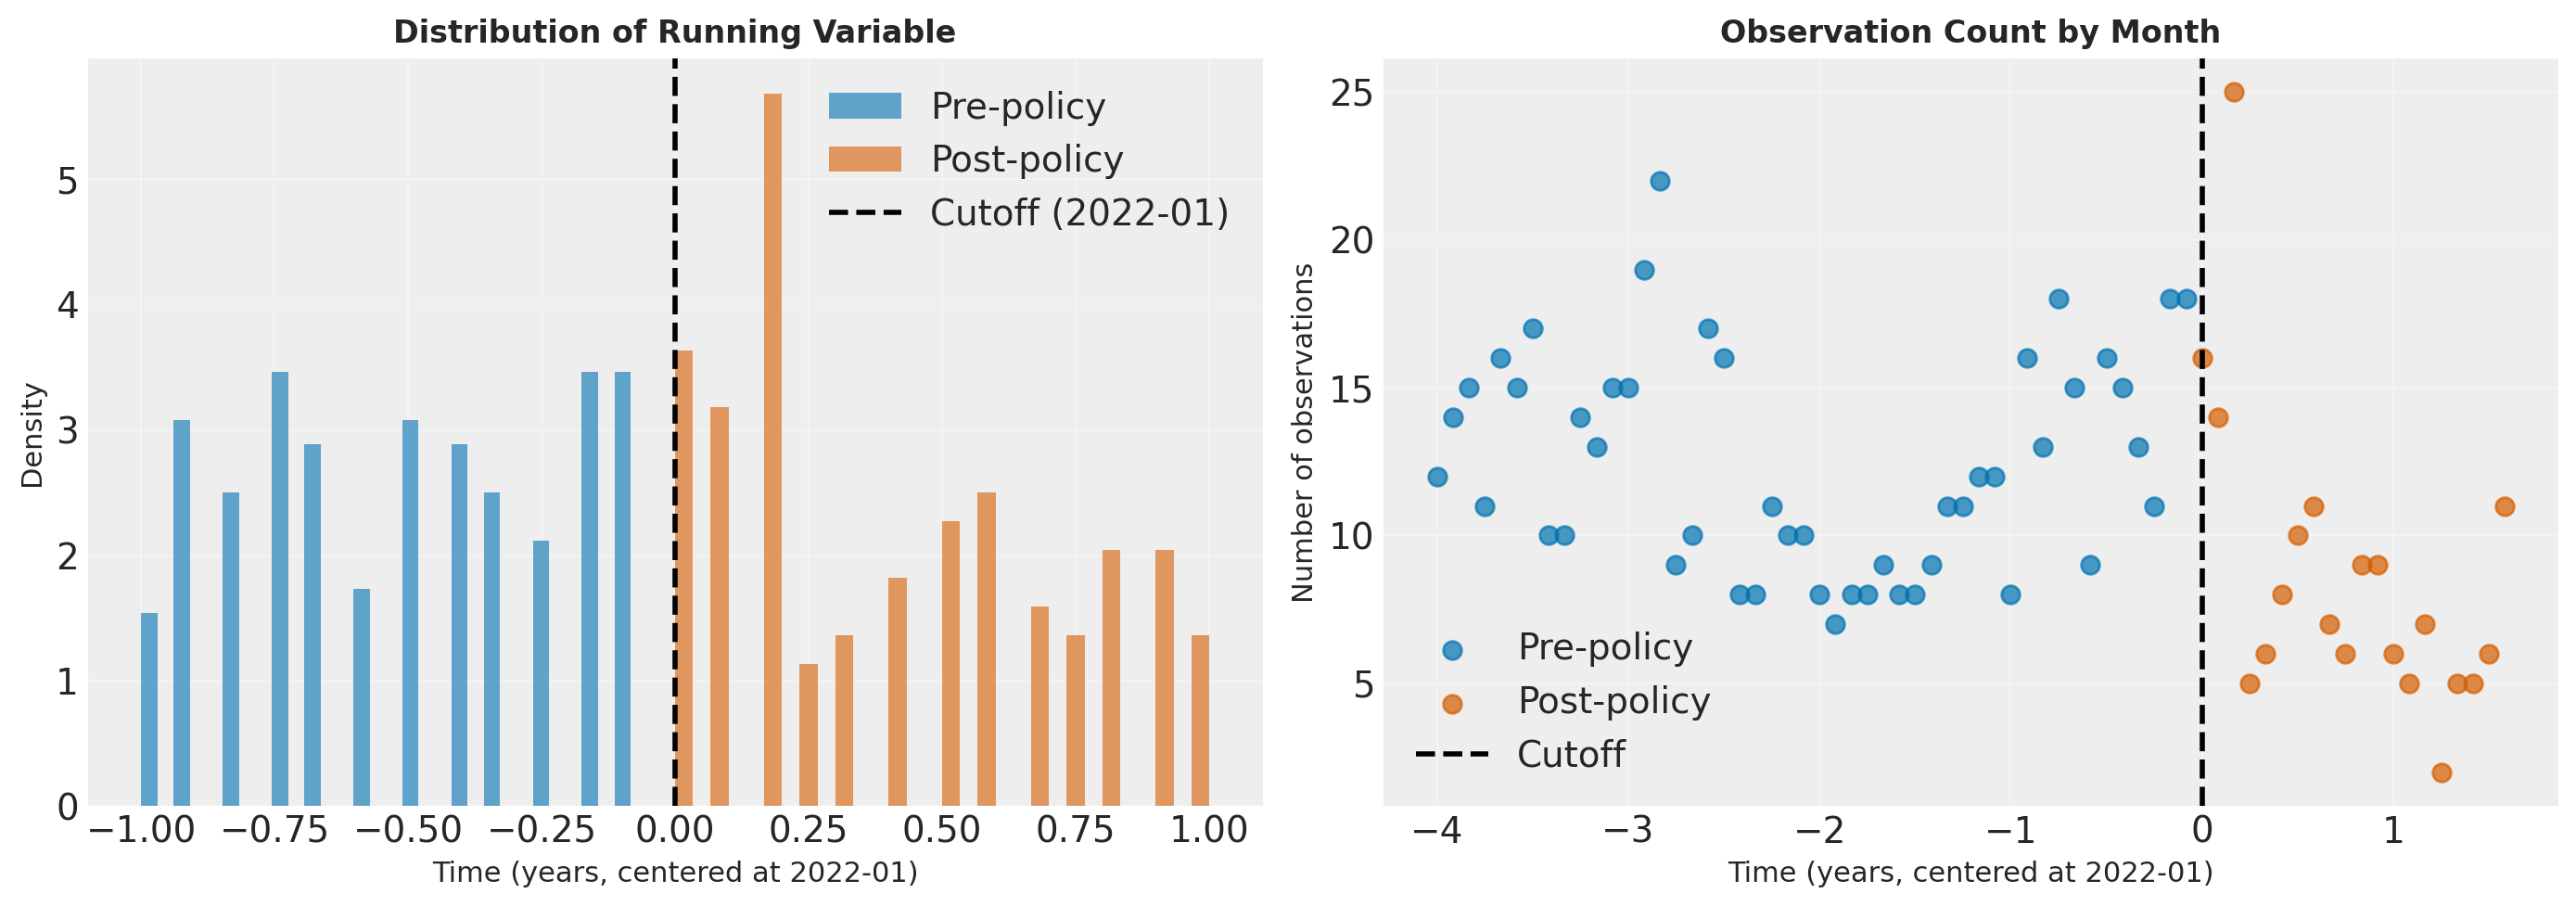


----------------------------------------------------------------------
INTERPRETATION:
Look for smooth transition across cutoff (no sudden jump in density)
Sharp discontinuity would suggest patients manipulated their treatment status


In [13]:
# ================================================================
# VALIDITY CHECK 3: Density Test (Manipulation Check)
# ================================================================
# Check if running variable density is continuous at cutoff
# (McCrary test - visual inspection)

print("\n" + "="*70)
print("VALIDITY CHECK 3: Density/Manipulation Test")
print("="*70)
print("Visual inspection: Is the distribution of running variable continuous?")
print("(Large discontinuity suggests manipulation)\n")

# Create histogram on both sides of cutoff
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Full distribution
ax1 = axes[0]
pre_data = pdf_baseline[pdf_baseline['post_policy'] == 0]['time_centered_years']
post_data = pdf_baseline[pdf_baseline['post_policy'] == 1]['time_centered_years']

ax1.hist(pre_data, bins=30, alpha=0.6, color='#0072B2', label='Pre-policy', density=True)
ax1.hist(post_data, bins=30, alpha=0.6, color='#D55E00', label='Post-policy', density=True)
ax1.axvline(0, color='black', linestyle='--', linewidth=2, label='Cutoff (2022-01)')
ax1.set_xlabel('Time (years, centered at 2022-01)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Distribution of Running Variable', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Right panel: Observation counts by month
ax2 = axes[1]
month_counts = (
    df_delta1.group_by('medtreat_yymm')
    .agg(pl.count('patient_id').alias('count'))
    .sort('medtreat_yymm')
    .to_pandas()
)
month_counts['time_centered_years'] = (
    (month_counts['medtreat_yymm'] // 100) + 
    ((month_counts['medtreat_yymm'] % 100) - 1) / 12 - 2022
)
month_counts['post'] = month_counts['medtreat_yymm'] >= 202201

pre_months = month_counts[~month_counts['post']]
post_months = month_counts[month_counts['post']]

ax2.scatter(pre_months['time_centered_years'], pre_months['count'], 
           color='#0072B2', s=50, alpha=0.7, label='Pre-policy')
ax2.scatter(post_months['time_centered_years'], post_months['count'],
           color='#D55E00', s=50, alpha=0.7, label='Post-policy')
ax2.axvline(0, color='black', linestyle='--', linewidth=2, label='Cutoff')
ax2.set_xlabel('Time (years, centered at 2022-01)', fontsize=11)
ax2.set_ylabel('Number of observations', fontsize=11)
ax2.set_title('Observation Count by Month', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "-"*70)
print("INTERPRETATION:")
print("Look for smooth transition across cutoff (no sudden jump in density)")
print("Sharp discontinuity would suggest patients manipulated their treatment status")
print("="*70)


MAIN RDD VISUALIZATION


/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_26181/840042879.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


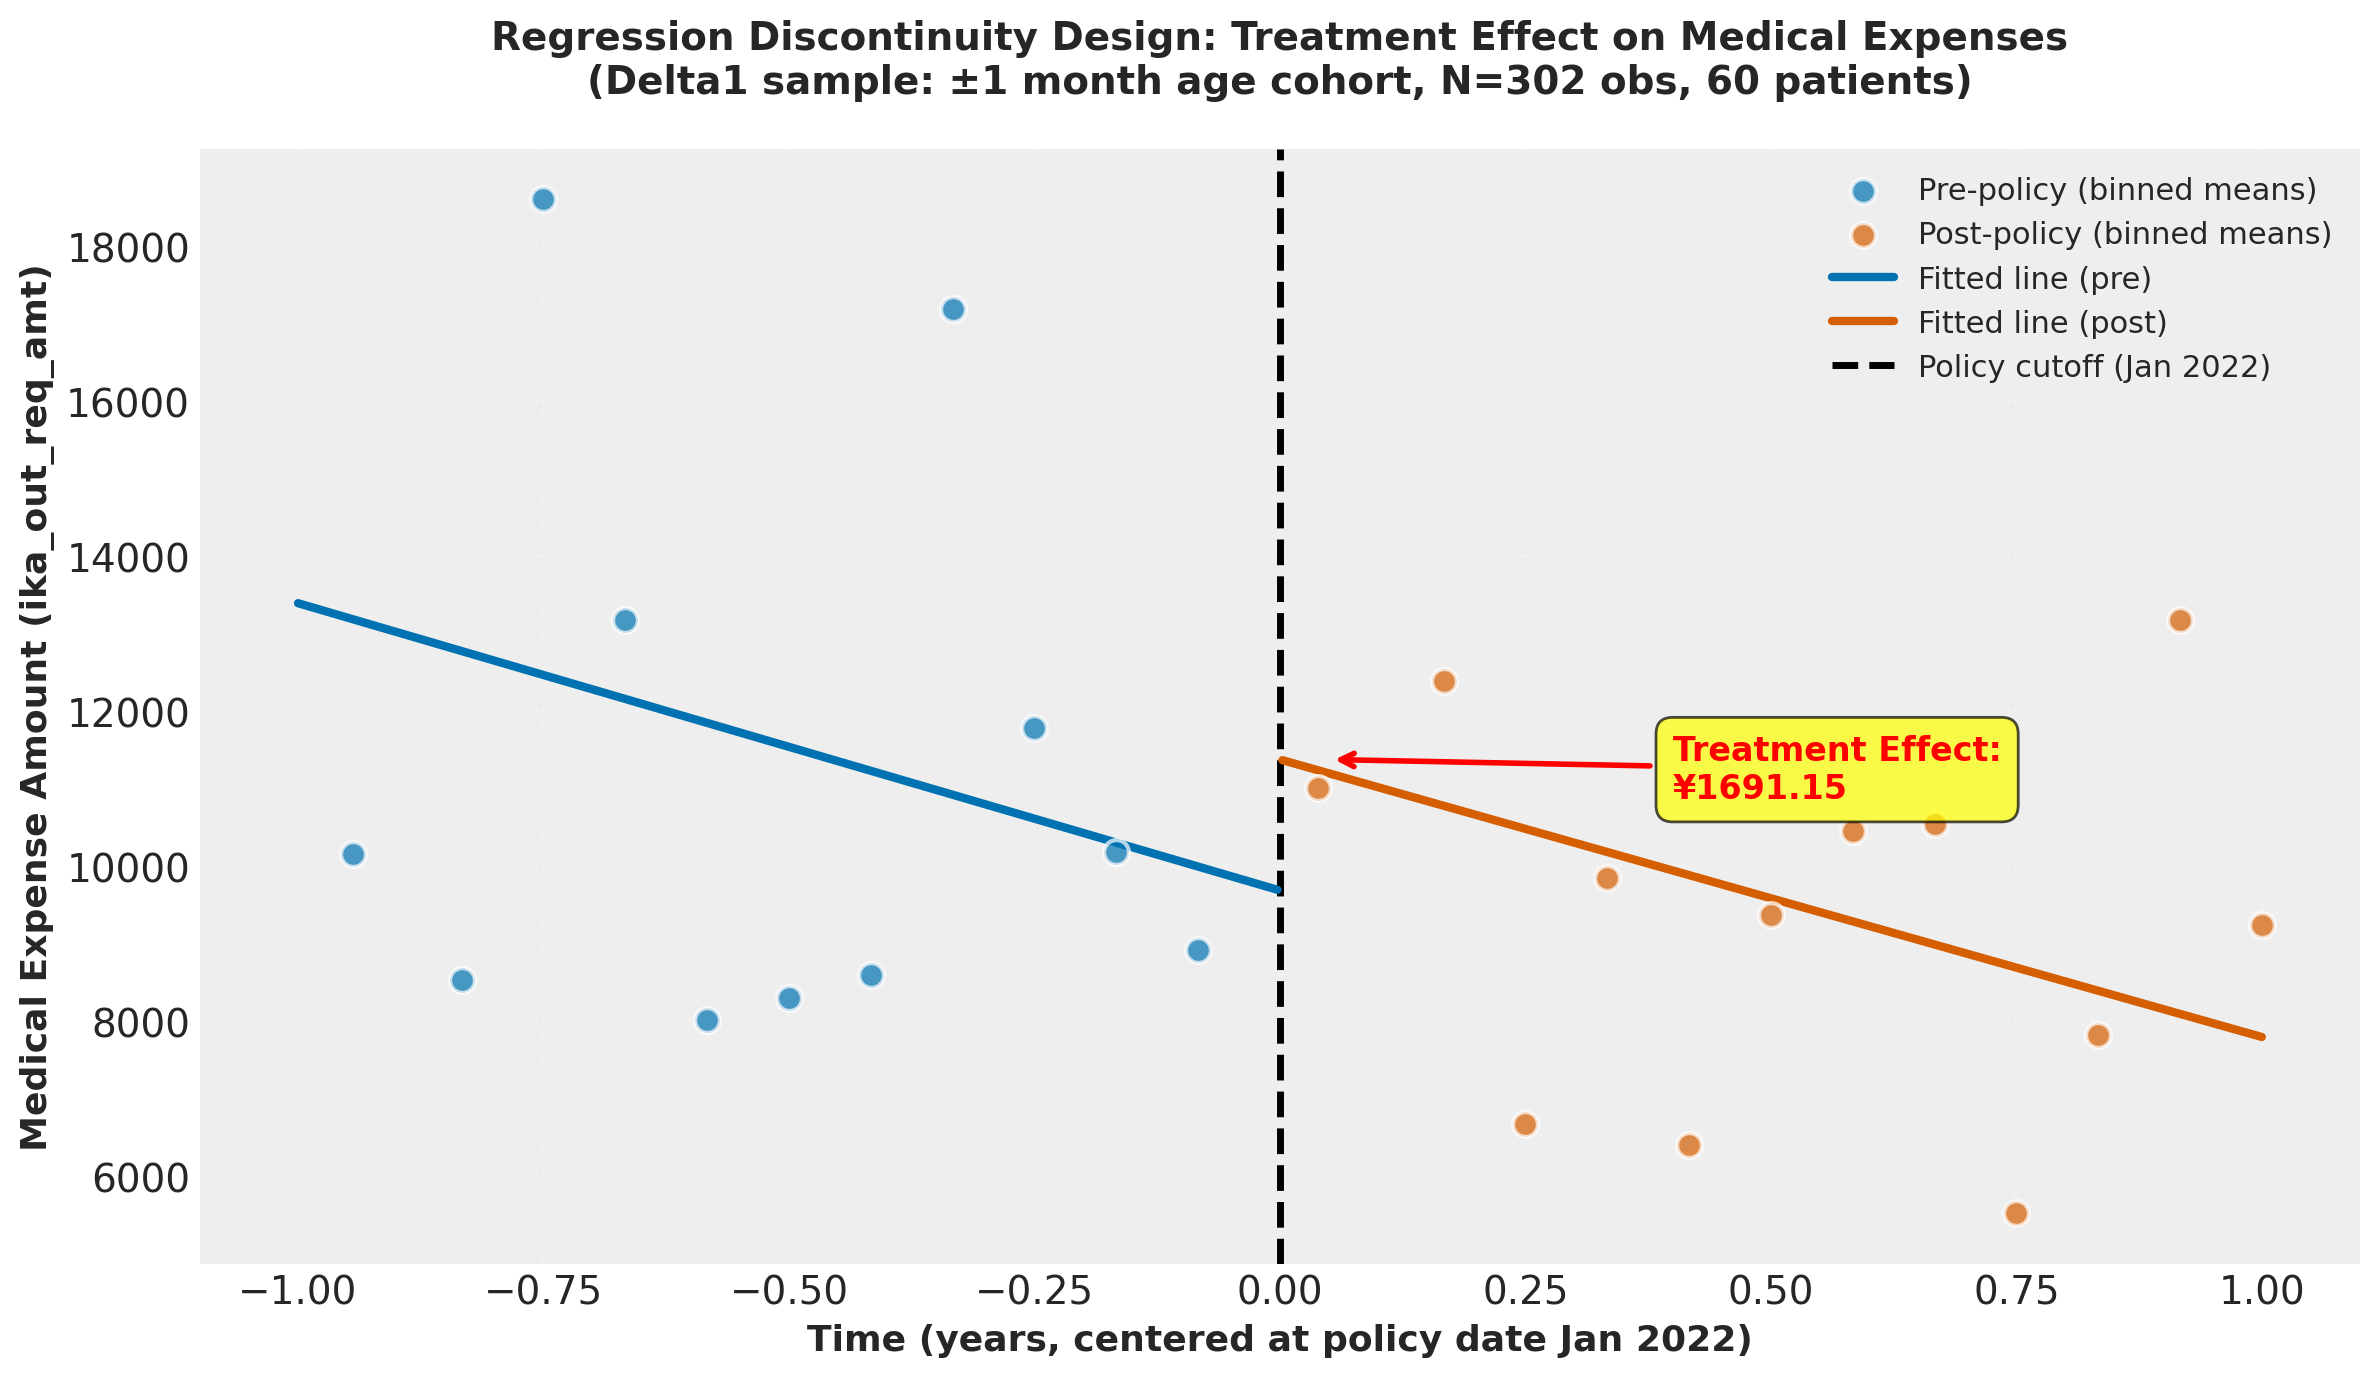


Treatment Effect: ¥1691.15
Standard Error: ¥2437.07
p-value: 0.4877


In [14]:
# ================================================================
# VISUALIZATION: Main RDD Plot
# ================================================================

print("\n" + "="*70)
print("MAIN RDD VISUALIZATION")
print("="*70)

# Create binned scatter plot (bin data for cleaner visualization)
def create_binned_data(pdf, n_bins=20):
    """Create binned scatter data for visualization"""
    pre_data = pdf[pdf['post_policy'] == 0].copy()
    post_data = pdf[pdf['post_policy'] == 1].copy()
    
    binned = []
    
    for data, label in [(pre_data, 0), (post_data, 1)]:
        if len(data) > 0:
            data['bin'] = pd.qcut(data['time_centered_years'], q=min(n_bins, len(data)), 
                                   duplicates='drop', labels=False)
            binned_stats = data.groupby('bin').agg({
                'time_centered_years': 'mean',
                'ika_out_req_amt': 'mean'
            }).reset_index()
            binned_stats['post_policy'] = label
            binned.append(binned_stats)
    
    return pd.concat(binned, ignore_index=True)

# Create binned data
binned_data = create_binned_data(pdf_baseline, n_bins=20)

# Generate prediction line from model
x_grid = pd.DataFrame({
    'time_centered_years': np.linspace(
        pdf_baseline['time_centered_years'].min(),
        pdf_baseline['time_centered_years'].max(),
        400
    )
})
x_grid['post_policy'] = (x_grid['time_centered_years'] >= 0).astype(int)

# Get predictions
x_grid['y_pred'] = model_baseline.predict(x_grid)

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

# Plot binned scatter
pre_binned = binned_data[binned_data['post_policy'] == 0]
post_binned = binned_data[binned_data['post_policy'] == 1]

ax.scatter(pre_binned['time_centered_years'], pre_binned['ika_out_req_amt'],
          s=80, alpha=0.7, color='#0072B2', label='Pre-policy (binned means)', 
          edgecolors='white', linewidth=1.5, zorder=3)
ax.scatter(post_binned['time_centered_years'], post_binned['ika_out_req_amt'],
          s=80, alpha=0.7, color='#D55E00', label='Post-policy (binned means)',
          edgecolors='white', linewidth=1.5, zorder=3)

# Plot fitted lines
pre_pred = x_grid[x_grid['time_centered_years'] < 0]
post_pred = x_grid[x_grid['time_centered_years'] >= 0]

ax.plot(pre_pred['time_centered_years'], pre_pred['y_pred'],
       color='#0072B2', linewidth=3, label='Fitted line (pre)', zorder=2)
ax.plot(post_pred['time_centered_years'], post_pred['y_pred'],
       color='#D55E00', linewidth=3, label='Fitted line (post)', zorder=2)

# Add cutoff line
ax.axvline(0, color='black', linestyle='--', linewidth=2.5, 
          label='Policy cutoff (Jan 2022)', zorder=1)

# Add treatment effect annotation
treatment_effect = model_baseline.params['post_policy']
y_at_cutoff = model_baseline.predict(pd.DataFrame({'time_centered_years': [0], 
                                                    'post_policy': [1]}))[0]
ax.annotate(f'Treatment Effect:\n¥{treatment_effect:.2f}',
           xy=(0.05, y_at_cutoff), xytext=(0.4, y_at_cutoff - 500),
           arrowprops=dict(arrowstyle='->', lw=2, color='red'),
           fontsize=12, fontweight='bold', color='red',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Formatting
ax.set_xlabel('Time (years, centered at policy date Jan 2022)', fontsize=13, fontweight='bold')
ax.set_ylabel('Medical Expense Amount (ika_out_req_amt)', fontsize=13, fontweight='bold')
ax.set_title('Regression Discontinuity Design: Treatment Effect on Medical Expenses\n' +
            f'(Delta1 sample: ±1 month age cohort, N={len(pdf_baseline):,} obs, ' +
            f'{pdf_baseline["patient_id"].nunique():,} patients)',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(alpha=0.3, linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()

print(f"\nTreatment Effect: ¥{treatment_effect:.2f}")
print(f"Standard Error: ¥{model_baseline.bse['post_policy']:.2f}")
print(f"p-value: {model_baseline.pvalues['post_policy']:.4f}")


ROBUSTNESS CHECKS SUMMARY VISUALIZATION


/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_26181/3147849137.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


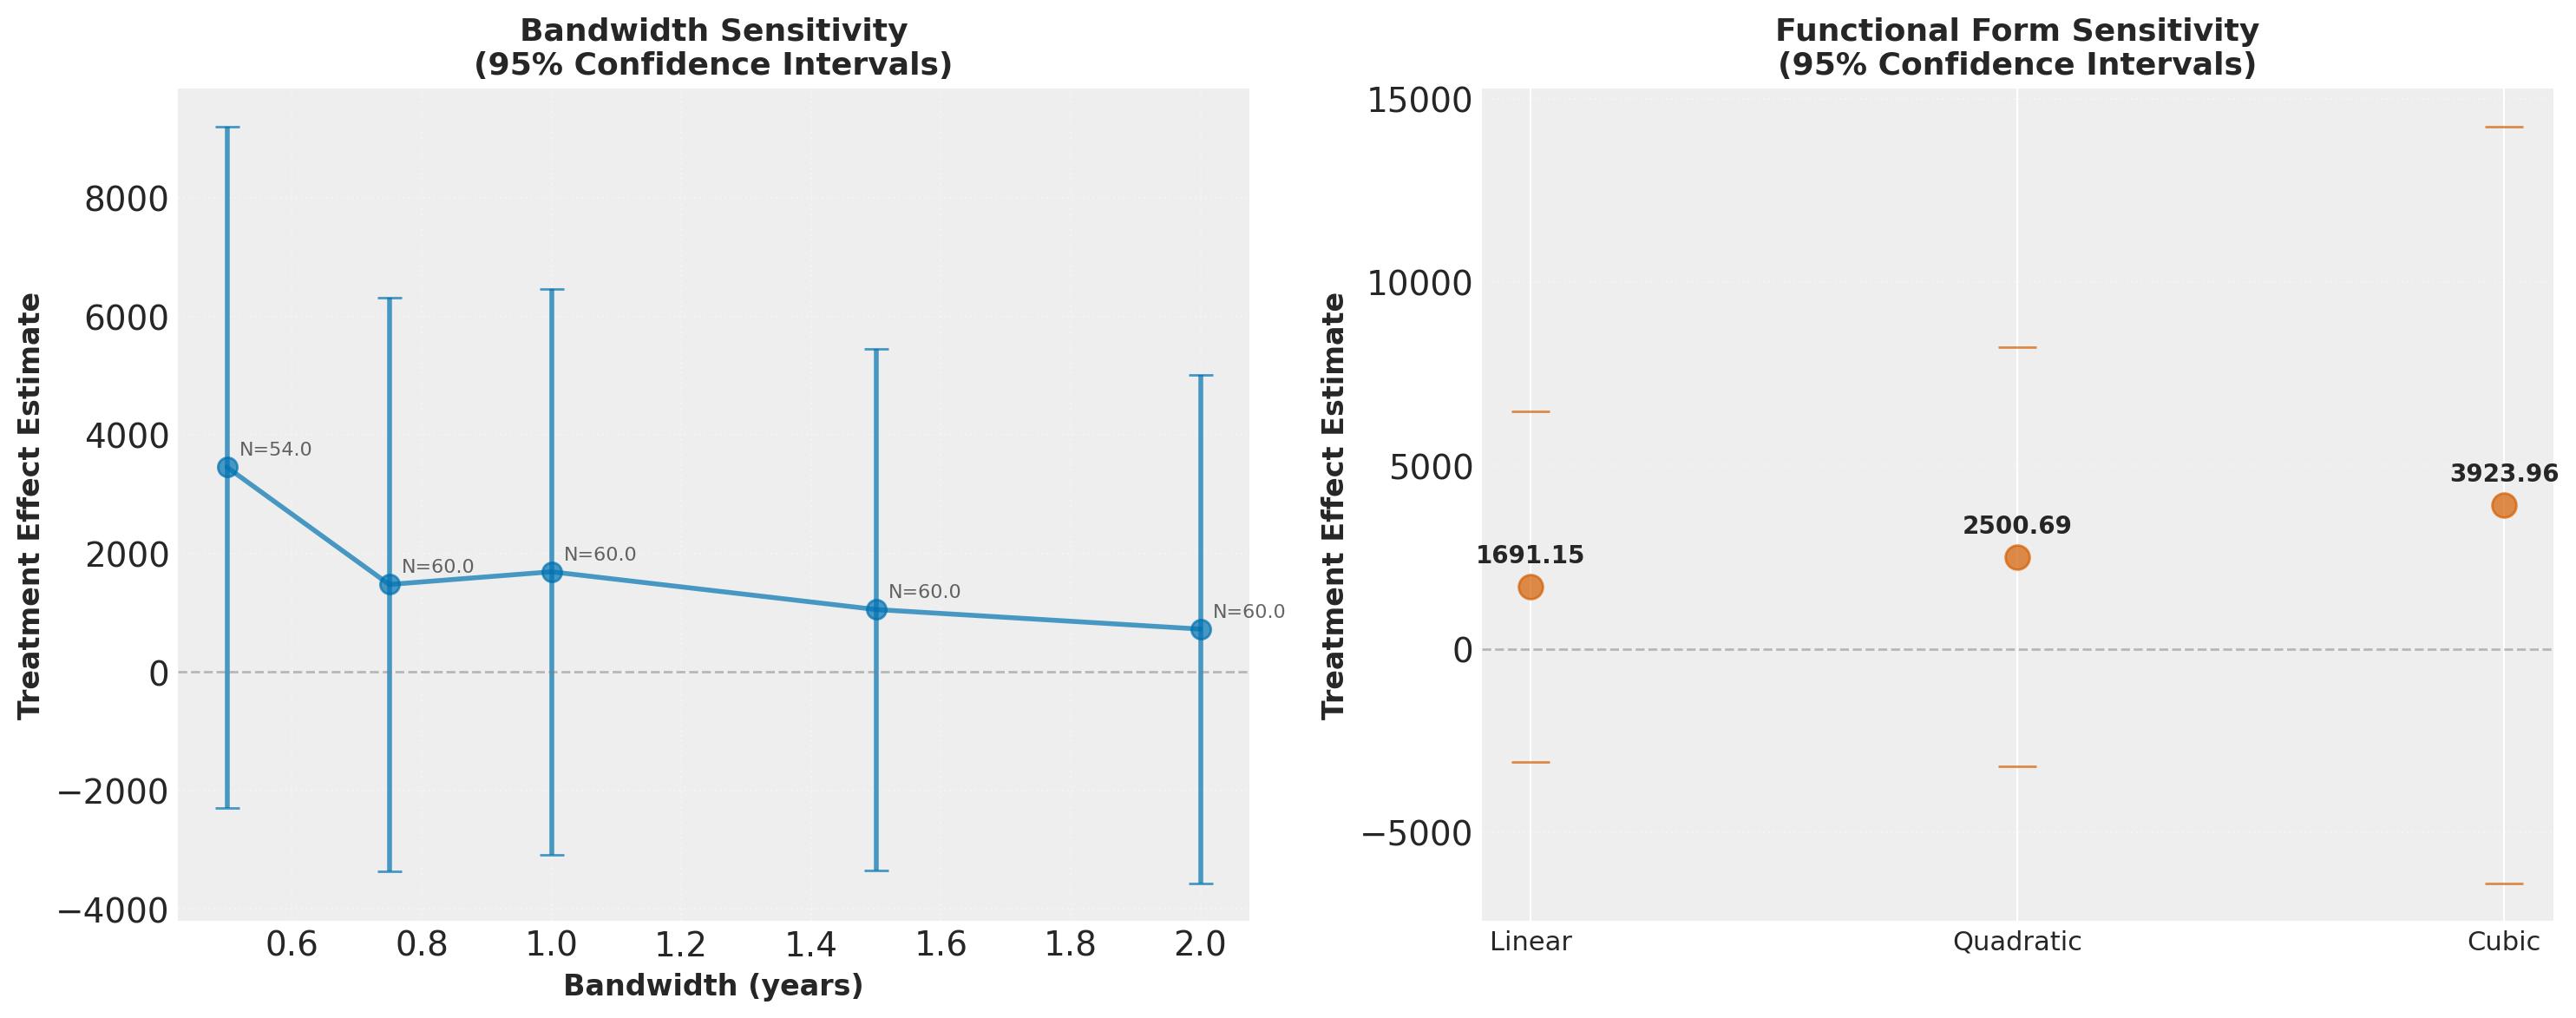


Note: Error bars show 95% confidence intervals
Significance: *** p<0.01, ** p<0.05, * p<0.1


In [15]:
# ================================================================
# VISUALIZATION: Robustness Checks Summary
# ================================================================

print("\n" + "="*70)
print("ROBUSTNESS CHECKS SUMMARY VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: Bandwidth sensitivity
ax1 = axes[0]
if len(df_bw_results) > 0:
    ax1.errorbar(df_bw_results['Bandwidth (years)'], 
                df_bw_results['Estimate'],
                yerr=1.96 * df_bw_results['Std Error'],
                fmt='o-', markersize=8, linewidth=2, capsize=5,
                color='#0072B2', ecolor='#0072B2', alpha=0.7)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_xlabel('Bandwidth (years)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Treatment Effect Estimate', fontsize=12, fontweight='bold')
    ax1.set_title('Bandwidth Sensitivity\n(95% Confidence Intervals)', 
                 fontsize=13, fontweight='bold')
    ax1.grid(alpha=0.3, linestyle=':')
    
    # Add sample size annotations
    for idx, row in df_bw_results.iterrows():
        ax1.annotate(f"N={row['N patients']}", 
                    xy=(row['Bandwidth (years)'], row['Estimate']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

# Right panel: Functional form sensitivity
ax2 = axes[1]
if len(df_form_results) > 0:
    x_pos = np.arange(len(df_form_results))
    ax2.errorbar(x_pos, 
                df_form_results['Estimate'],
                yerr=1.96 * df_form_results['Std Error'],
                fmt='o', markersize=10, linewidth=0, capsize=8,
                color='#D55E00', ecolor='#D55E00', alpha=0.7)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(df_form_results['Specification'], fontsize=11)
    ax2.set_ylabel('Treatment Effect Estimate', fontsize=12, fontweight='bold')
    ax2.set_title('Functional Form Sensitivity\n(95% Confidence Intervals)', 
                 fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3, linestyle=':', axis='y')
    
    # Add value labels
    for idx, row in df_form_results.iterrows():
        sig_star = '***' if row['p-value'] < 0.01 else '**' if row['p-value'] < 0.05 else '*' if row['p-value'] < 0.1 else ''
        ax2.annotate(f"{row['Estimate']:.2f}{sig_star}", 
                    xy=(idx, row['Estimate']),
                    xytext=(0, 10), textcoords='offset points',
                    fontsize=10, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nNote: Error bars show 95% confidence intervals")
print("Significance: *** p<0.01, ** p<0.05, * p<0.1")

## Summary and Interpretation Guide

### RDD Design Summary
- **Running Variable**: Time (medtreat_yymm) - when treatment was received
- **Treatment Cutoff**: January 2022 (policy implementation)  
- **Sample**: Age-homogeneous cohort (±1 month birth window around age 17)
- **Key Assumption**: Patients born within ±1 month have identical consumption trends
- **Treatment Effect**: Local Average Treatment Effect (LATE) at the cutoff

### Validity Assessment Checklist

1. **✓ Covariate Balance**: Check that predetermined characteristics show NO discontinuity
   - PASS = p-values > 0.05 for all covariates
   - FAIL = Significant jumps suggest confounding

2. **✓ Placebo Tests**: Check that fake cutoffs show NO effects  
   - PASS = p-values > 0.05 at all fake cutoffs
   - FAIL = Significant effects suggest spurious patterns

3. **✓ Density Test**: Visual check for smooth distribution across cutoff
   - PASS = No sudden jump in observation counts
   - FAIL = Sharp discontinuity suggests manipulation

4. **✓ Bandwidth Sensitivity**: Estimates should be stable across bandwidths
   - PASS = Estimates and confidence intervals overlap
   - FAIL = Large fluctuations suggest model misspecification

5. **✓ Functional Form Robustness**: Estimates should be similar across specifications
   - PASS = Linear, quadratic, cubic estimates are close
   - FAIL = Large differences suggest wrong functional form

### How to Interpret Results

**If all validity checks PASS:**
- Treatment effect estimate is likely causal
- Can interpret as impact of policy on eligible cohort
- Standard errors account for clustering by patient

**If any validity check FAILS:**
- RDD assumptions may be violated
- Consider alternative identification strategies
- Results may not be causally interpretable

### Limitations of Current Design

1. **Time-based rather than age-based RDD**: Using time as running variable means this is closer to interrupted time series (ITS) than traditional RDD
2. **Small sample size**: Delta1 (±1 month) provides limited observations
3. **Parallel trends assumption**: Implicitly assumes pre- and post-policy trends would have been identical absent treatment
4. **External validity**: Results only apply to this specific age cohort

### Reference
Design based on: Yanai (2023) - Regression Discontinuity Design
https://yukiyanai.github.io/econometrics2/regression-discontinuity.html

# 📊 Export Results to HTML Report

Generating comprehensive HTML report with all results, tables, and figures...

In [102]:
# ================================================================
# Save all figures to RDD_Results folder
# ================================================================

import os
from datetime import datetime

# Create output directory
output_dir = "/Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results"
os.makedirs(output_dir, exist_ok=True)

# Timestamp for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"Saving results to: {output_dir}")
print(f"Timestamp: {timestamp}\n")

# We'll save figures in the next cells and collect all results
results_summary = {
    'timestamp': timestamp,
    'sample_size': len(pdf_baseline),
    'n_patients': pdf_baseline['patient_id'].nunique(),
    'treatment_effect': model_baseline.params['post_policy'],
    'std_error': model_baseline.bse['post_policy'],
    'p_value': model_baseline.pvalues['post_policy'],
    'ci_lower': model_baseline.conf_int().loc['post_policy', 0],
    'ci_upper': model_baseline.conf_int().loc['post_policy', 1]
}

print("✓ Output directory created")
print(f"✓ Results summary initialized")

Saving results to: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results
Timestamp: 20251106_020040

✓ Output directory created
✓ Results summary initialized


/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_17251/2437753795.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


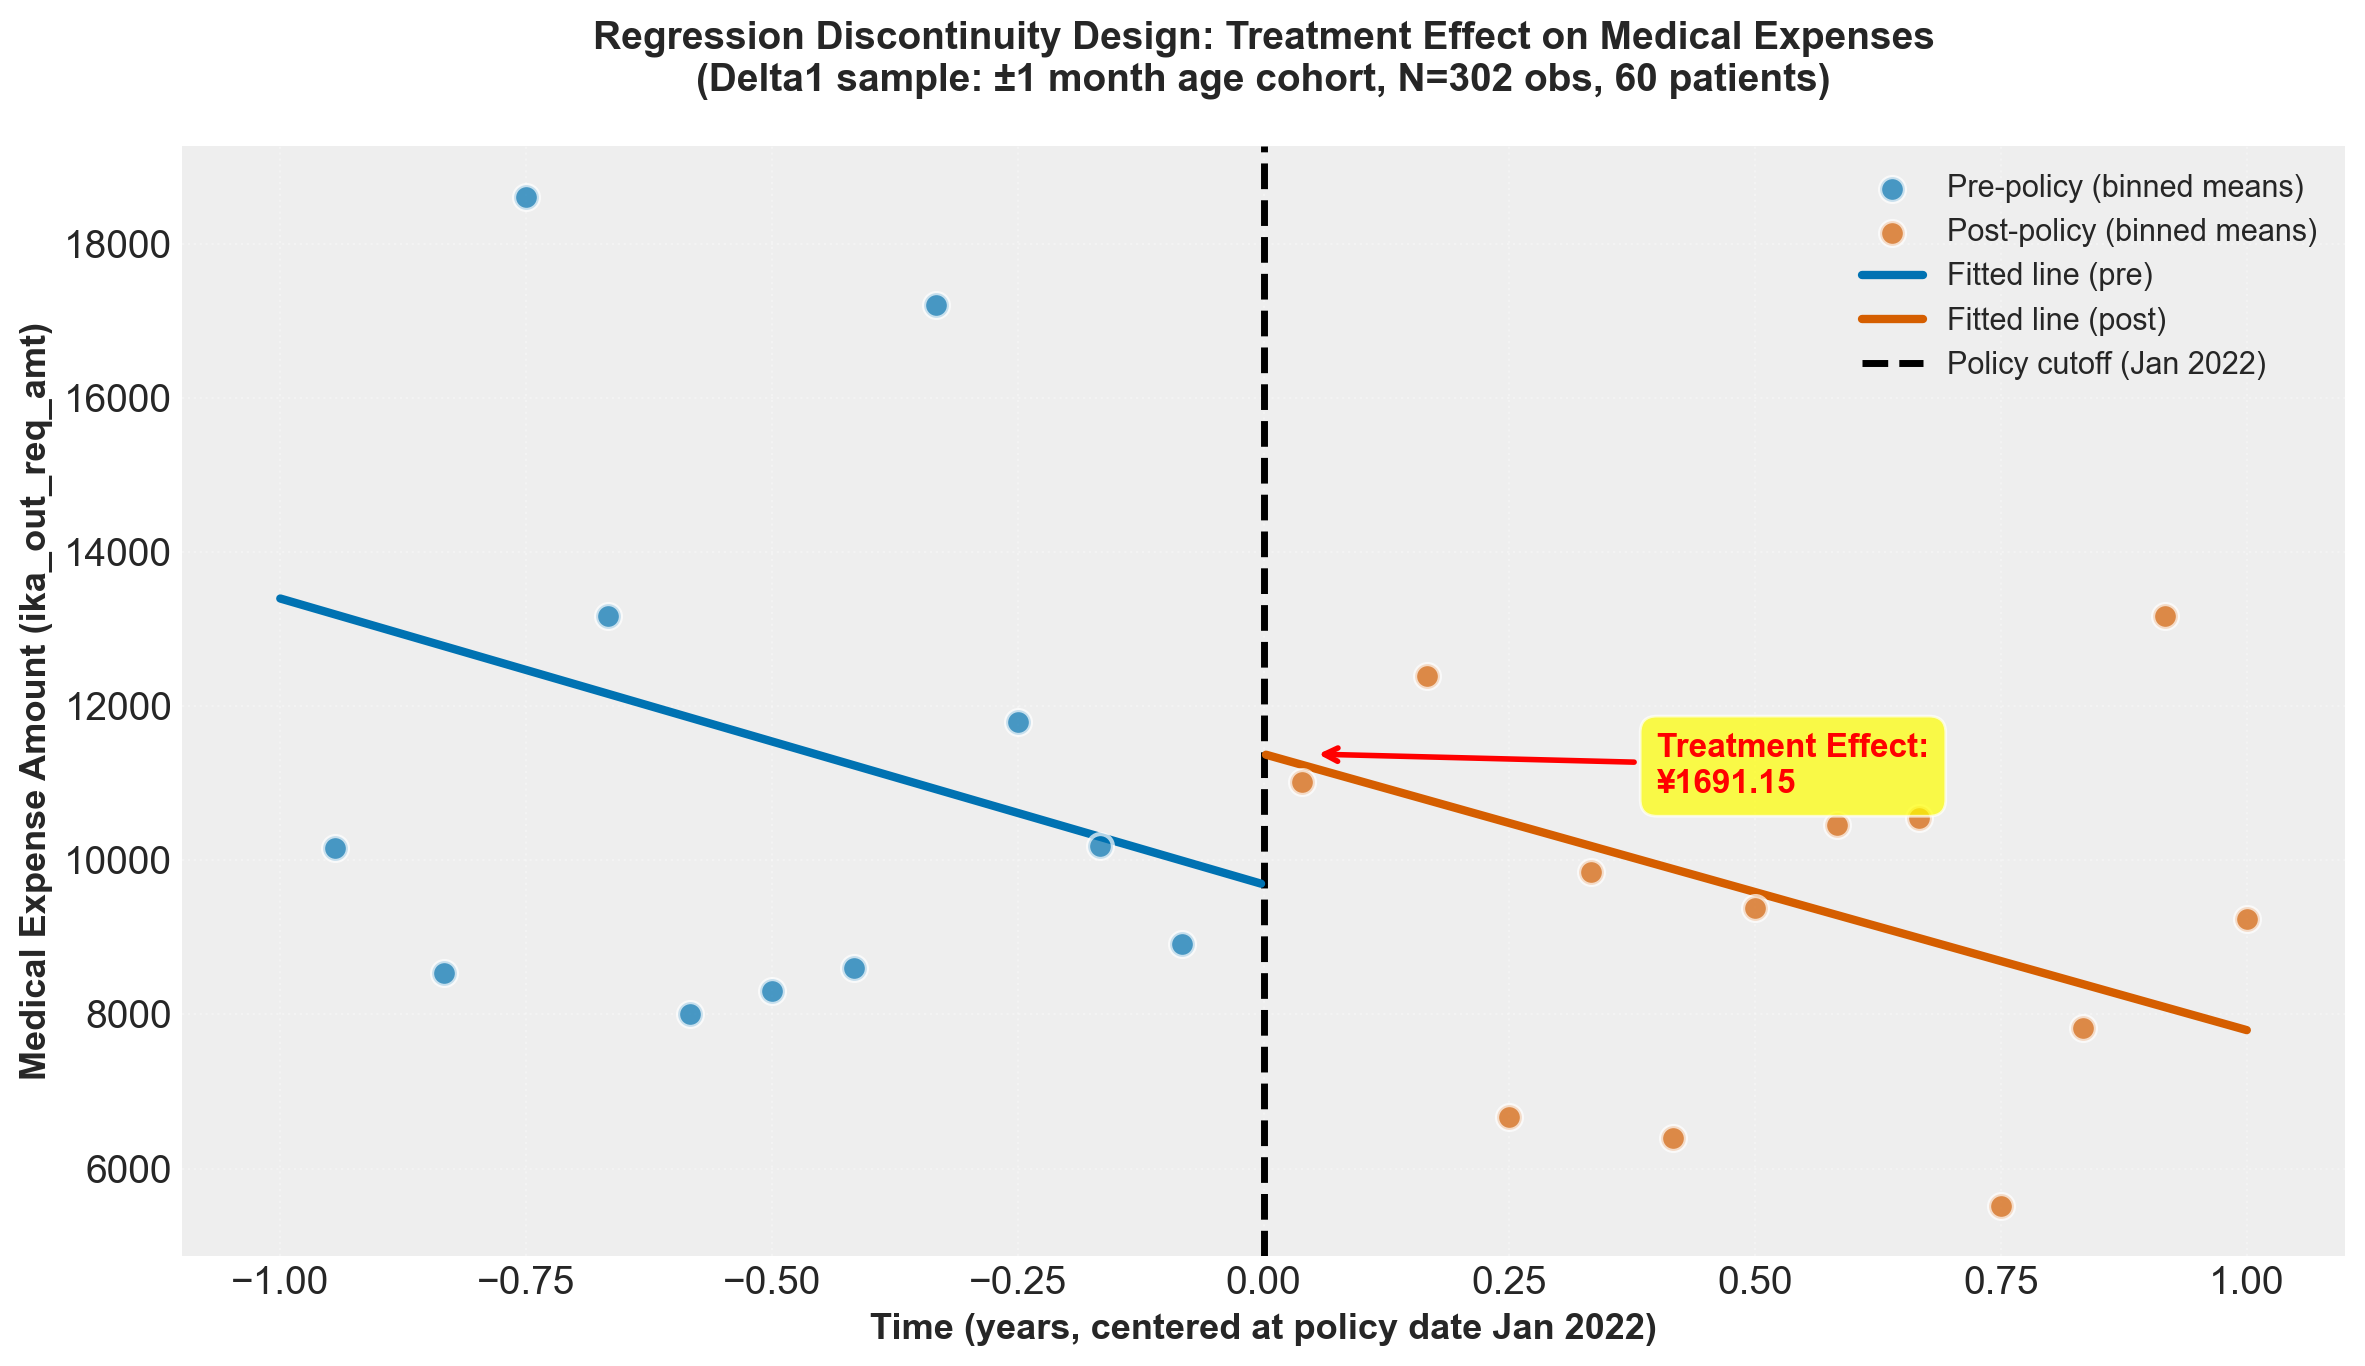

✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/fig1_main_rdd_20251106_020040.png


In [103]:
# ================================================================
# Figure 1: Main RDD Plot (save to file)
# ================================================================

# Create binned data
binned_data = create_binned_data(pdf_baseline, n_bins=20)

# Generate prediction line
x_grid = pd.DataFrame({
    'time_centered_years': np.linspace(
        pdf_baseline['time_centered_years'].min(),
        pdf_baseline['time_centered_years'].max(),
        400
    )
})
x_grid['post_policy'] = (x_grid['time_centered_years'] >= 0).astype(int)
x_grid['y_pred'] = model_baseline.predict(x_grid)

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

# Plot binned scatter
pre_binned = binned_data[binned_data['post_policy'] == 0]
post_binned = binned_data[binned_data['post_policy'] == 1]

ax.scatter(pre_binned['time_centered_years'], pre_binned['ika_out_req_amt'],
          s=80, alpha=0.7, color='#0072B2', label='Pre-policy (binned means)', 
          edgecolors='white', linewidth=1.5, zorder=3)
ax.scatter(post_binned['time_centered_years'], post_binned['ika_out_req_amt'],
          s=80, alpha=0.7, color='#D55E00', label='Post-policy (binned means)',
          edgecolors='white', linewidth=1.5, zorder=3)

# Plot fitted lines
pre_pred = x_grid[x_grid['time_centered_years'] < 0]
post_pred = x_grid[x_grid['time_centered_years'] >= 0]

ax.plot(pre_pred['time_centered_years'], pre_pred['y_pred'],
       color='#0072B2', linewidth=3, label='Fitted line (pre)', zorder=2)
ax.plot(post_pred['time_centered_years'], post_pred['y_pred'],
       color='#D55E00', linewidth=3, label='Fitted line (post)', zorder=2)

# Add cutoff line
ax.axvline(0, color='black', linestyle='--', linewidth=2.5, 
          label='Policy cutoff (Jan 2022)', zorder=1)

# Add treatment effect annotation
treatment_effect = model_baseline.params['post_policy']
y_at_cutoff = model_baseline.predict(pd.DataFrame({'time_centered_years': [0], 
                                                    'post_policy': [1]}))[0]
ax.annotate(f'Treatment Effect:\n¥{treatment_effect:.2f}',
           xy=(0.05, y_at_cutoff), xytext=(0.4, y_at_cutoff - 500),
           arrowprops=dict(arrowstyle='->', lw=2, color='red'),
           fontsize=12, fontweight='bold', color='red',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Formatting
ax.set_xlabel('Time (years, centered at policy date Jan 2022)', fontsize=13, fontweight='bold')
ax.set_ylabel('Medical Expense Amount (ika_out_req_amt)', fontsize=13, fontweight='bold')
ax.set_title('Regression Discontinuity Design: Treatment Effect on Medical Expenses\n' +
            f'(Delta1 sample: ±1 month age cohort, N={len(pdf_baseline):,} obs, ' +
            f'{pdf_baseline["patient_id"].nunique():,} patients)',
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(alpha=0.3, linestyle=':', linewidth=0.8)

plt.tight_layout()
fig_path_1 = f"{output_dir}/fig1_main_rdd_{timestamp}.png"
plt.savefig(fig_path_1, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {fig_path_1}")

/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_17251/4186802286.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


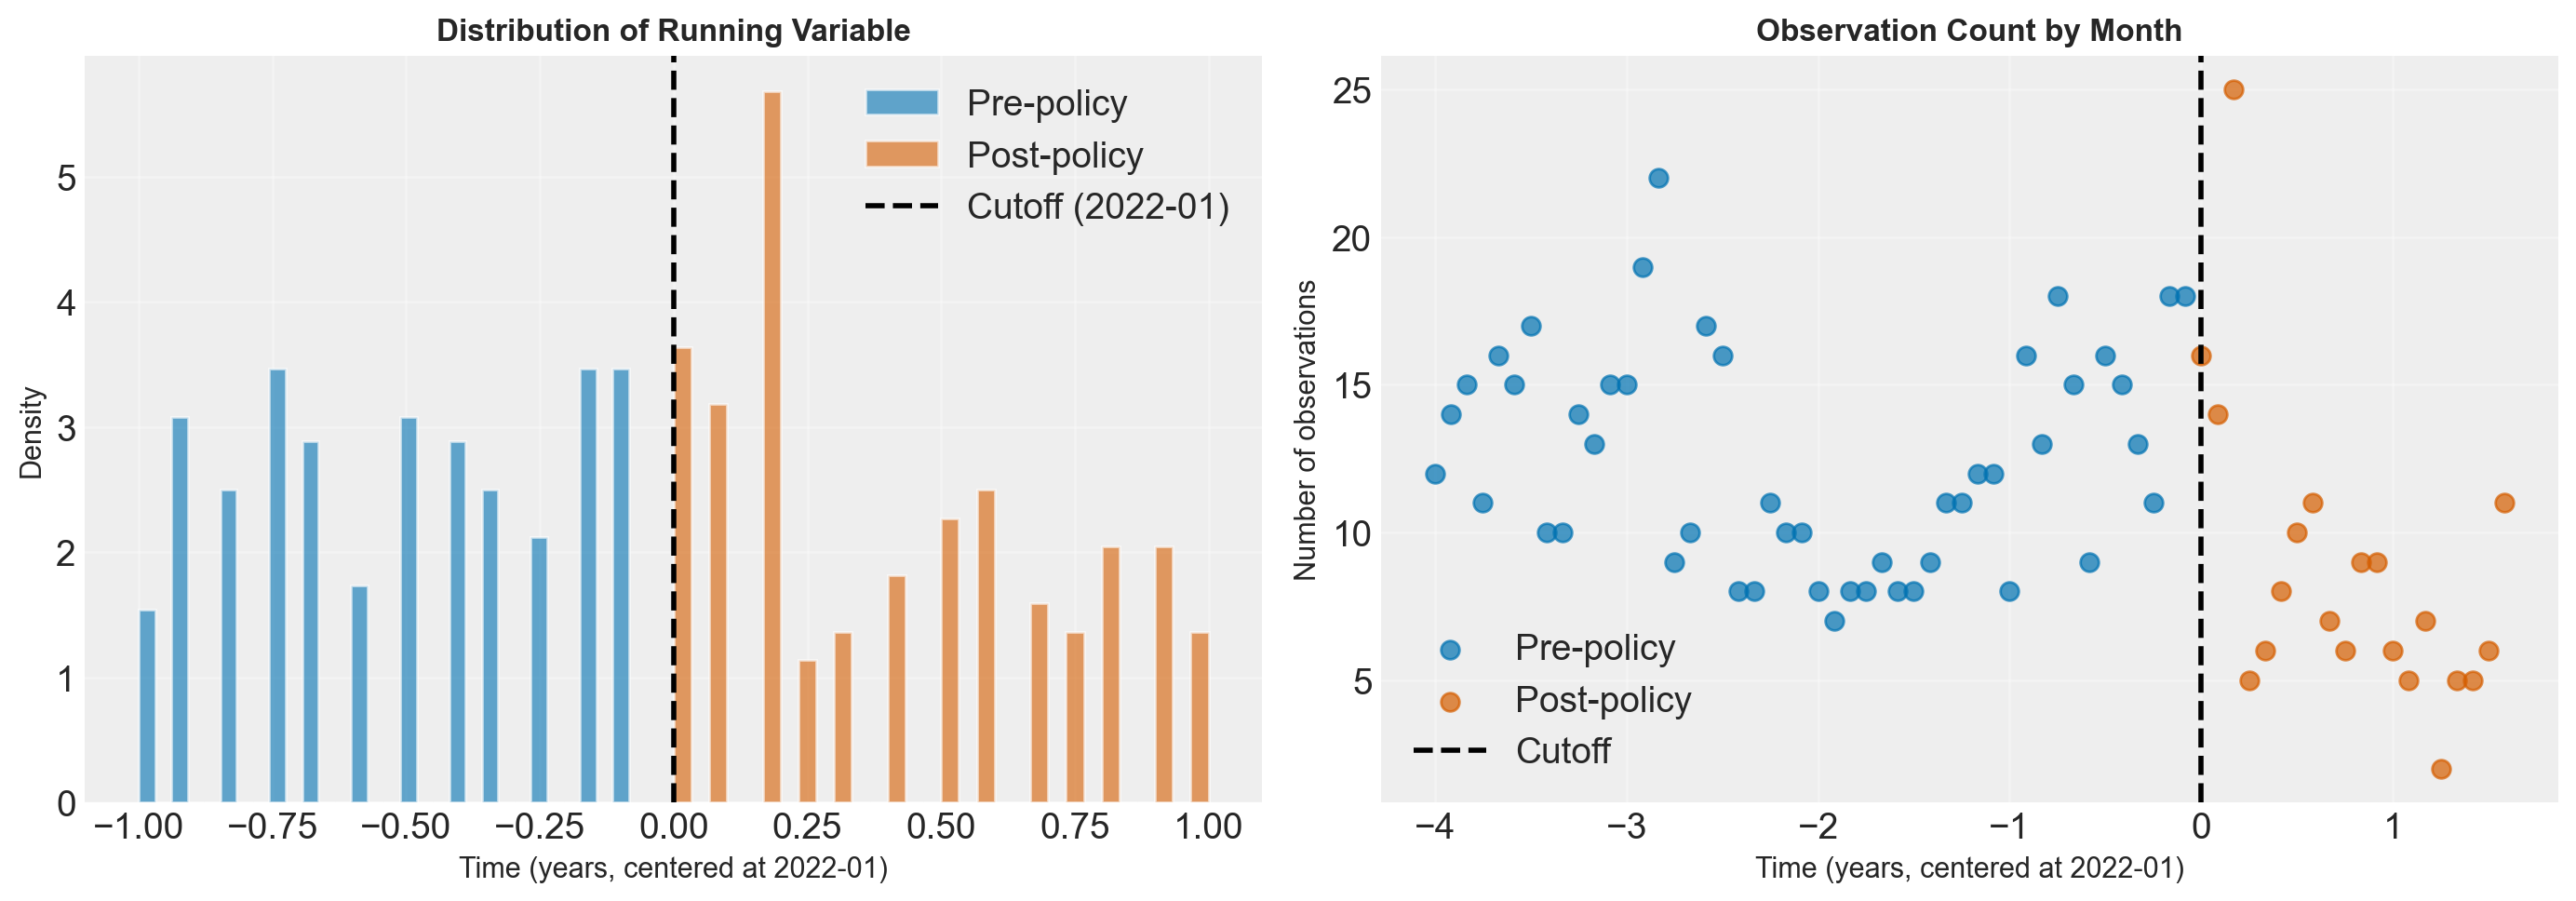

✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/fig2_density_test_20251106_020040.png


In [104]:
# ================================================================
# Figure 2: Density Test (save to file)
# ================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Full distribution
ax1 = axes[0]
pre_data = pdf_baseline[pdf_baseline['post_policy'] == 0]['time_centered_years']
post_data = pdf_baseline[pdf_baseline['post_policy'] == 1]['time_centered_years']

ax1.hist(pre_data, bins=30, alpha=0.6, color='#0072B2', label='Pre-policy', density=True)
ax1.hist(post_data, bins=30, alpha=0.6, color='#D55E00', label='Post-policy', density=True)
ax1.axvline(0, color='black', linestyle='--', linewidth=2, label='Cutoff (2022-01)')
ax1.set_xlabel('Time (years, centered at 2022-01)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Distribution of Running Variable', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Right panel: Observation counts by month
ax2 = axes[1]
month_counts = (
    df_delta1.group_by('medtreat_yymm')
    .agg(pl.count('patient_id').alias('count'))
    .sort('medtreat_yymm')
    .to_pandas()
)
month_counts['time_centered_years'] = (
    (month_counts['medtreat_yymm'] // 100) + 
    ((month_counts['medtreat_yymm'] % 100) - 1) / 12 - 2022
)
month_counts['post'] = month_counts['medtreat_yymm'] >= 202201

pre_months = month_counts[~month_counts['post']]
post_months = month_counts[month_counts['post']]

ax2.scatter(pre_months['time_centered_years'], pre_months['count'], 
           color='#0072B2', s=50, alpha=0.7, label='Pre-policy')
ax2.scatter(post_months['time_centered_years'], post_months['count'],
           color='#D55E00', s=50, alpha=0.7, label='Post-policy')
ax2.axvline(0, color='black', linestyle='--', linewidth=2, label='Cutoff')
ax2.set_xlabel('Time (years, centered at 2022-01)', fontsize=11)
ax2.set_ylabel('Number of observations', fontsize=11)
ax2.set_title('Observation Count by Month', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
fig_path_2 = f"{output_dir}/fig2_density_test_{timestamp}.png"
plt.savefig(fig_path_2, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {fig_path_2}")

/var/folders/p_/j1bs4y9n44n99d120x17dn_00000gn/T/ipykernel_17251/3276272488.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


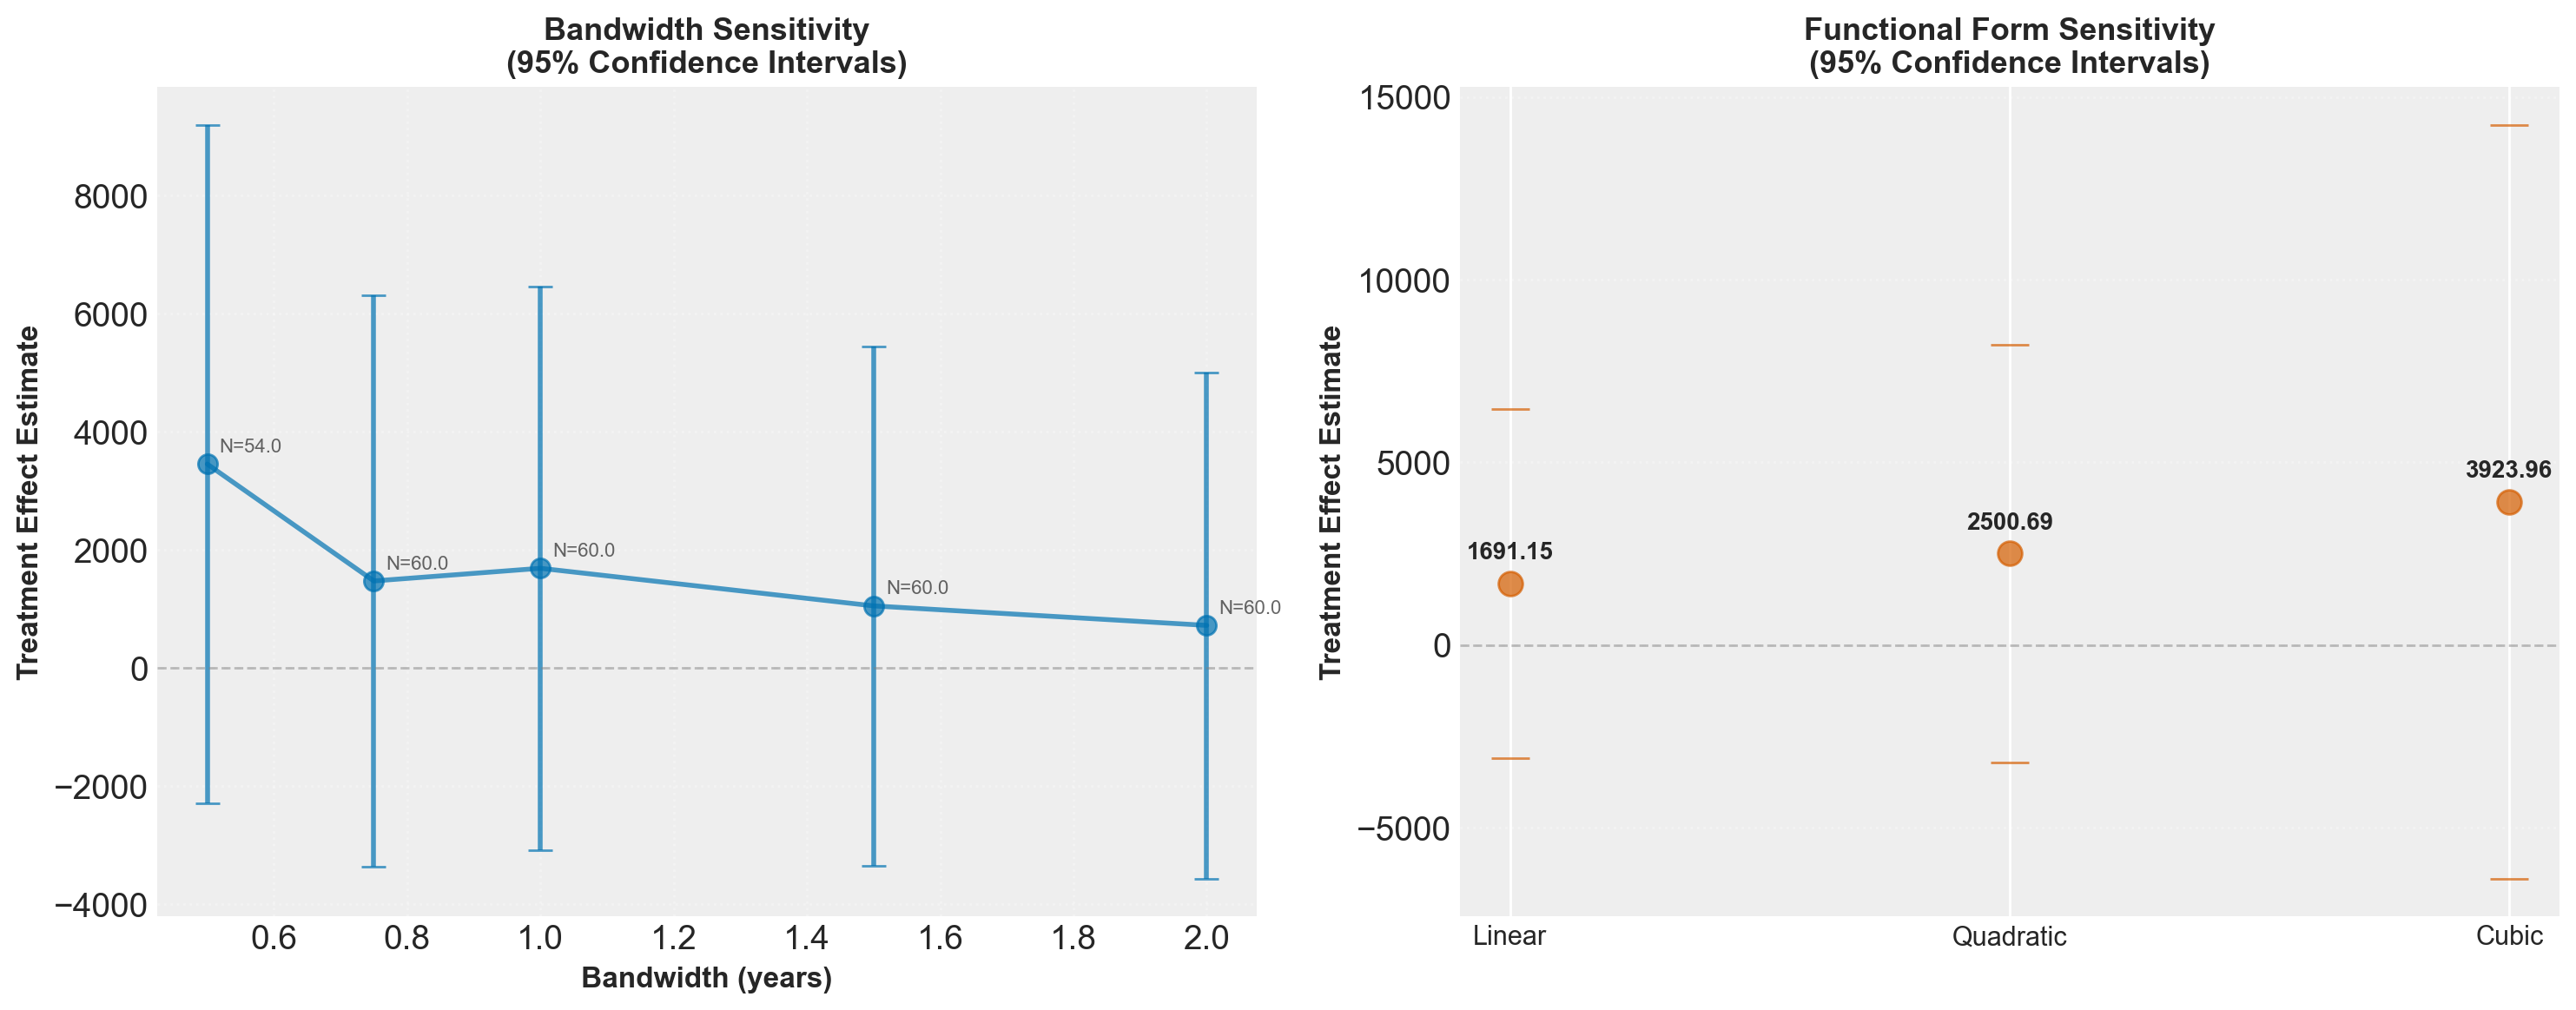

✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/fig3_robustness_20251106_020040.png


In [105]:
# ================================================================
# Figure 3: Robustness Checks (save to file)
# ================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: Bandwidth sensitivity
ax1 = axes[0]
if len(df_bw_results) > 0:
    ax1.errorbar(df_bw_results['Bandwidth (years)'], 
                df_bw_results['Estimate'],
                yerr=1.96 * df_bw_results['Std Error'],
                fmt='o-', markersize=8, linewidth=2, capsize=5,
                color='#0072B2', ecolor='#0072B2', alpha=0.7)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_xlabel('Bandwidth (years)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Treatment Effect Estimate', fontsize=12, fontweight='bold')
    ax1.set_title('Bandwidth Sensitivity\n(95% Confidence Intervals)', 
                 fontsize=13, fontweight='bold')
    ax1.grid(alpha=0.3, linestyle=':')
    
    # Add sample size annotations
    for idx, row in df_bw_results.iterrows():
        ax1.annotate(f"N={row['N patients']}", 
                    xy=(row['Bandwidth (years)'], row['Estimate']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

# Right panel: Functional form sensitivity
ax2 = axes[1]
if len(df_form_results) > 0:
    x_pos = np.arange(len(df_form_results))
    ax2.errorbar(x_pos, 
                df_form_results['Estimate'],
                yerr=1.96 * df_form_results['Std Error'],
                fmt='o', markersize=10, linewidth=0, capsize=8,
                color='#D55E00', ecolor='#D55E00', alpha=0.7)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(df_form_results['Specification'], fontsize=11)
    ax2.set_ylabel('Treatment Effect Estimate', fontsize=12, fontweight='bold')
    ax2.set_title('Functional Form Sensitivity\n(95% Confidence Intervals)', 
                 fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3, linestyle=':', axis='y')
    
    # Add value labels
    for idx, row in df_form_results.iterrows():
        sig_star = '***' if row['p-value'] < 0.01 else '**' if row['p-value'] < 0.05 else '*' if row['p-value'] < 0.1 else ''
        ax2.annotate(f"{row['Estimate']:.2f}{sig_star}", 
                    xy=(idx, row['Estimate']),
                    xytext=(0, 10), textcoords='offset points',
                    fontsize=10, ha='center', fontweight='bold')

plt.tight_layout()
fig_path_3 = f"{output_dir}/fig3_robustness_{timestamp}.png"
plt.savefig(fig_path_3, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {fig_path_3}")

In [106]:
# ================================================================
# Generate Comprehensive HTML Report
# ================================================================

import base64

# Define cutoff age for HTML report
age_base = 17

def img_to_base64(img_path):
    """Convert image to base64 for embedding in HTML"""
    with open(img_path, 'rb') as f:
        return base64.b64encode(f.read()).decode()

# Start building HTML
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>RDD Analysis Results - {timestamp}</title>
    <style>
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f5f5f5;
        }}
        .header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 30px;
            border-radius: 10px;
            margin-bottom: 30px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }}
        h1 {{
            margin: 0;
            font-size: 2.5em;
        }}
        .timestamp {{
            opacity: 0.9;
            font-size: 0.9em;
            margin-top: 10px;
        }}
        .section {{
            background: white;
            padding: 25px;
            margin-bottom: 25px;
            border-radius: 10px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        h2 {{
            color: #667eea;
            border-bottom: 3px solid #667eea;
            padding-bottom: 10px;
            margin-top: 0;
        }}
        h3 {{
            color: #764ba2;
            margin-top: 20px;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
        }}
        th {{
            background-color: #667eea;
            color: white;
            padding: 12px;
            text-align: left;
            font-weight: bold;
        }}
        td {{
            padding: 10px;
            border-bottom: 1px solid #ddd;
        }}
        tr:hover {{
            background-color: #f5f5f5;
        }}
        .metric {{
            display: inline-block;
            background: #e8eaf6;
            padding: 15px 20px;
            margin: 10px;
            border-radius: 8px;
            border-left: 4px solid #667eea;
        }}
        .metric-label {{
            font-size: 0.85em;
            color: #666;
            text-transform: uppercase;
            letter-spacing: 1px;
        }}
        .metric-value {{
            font-size: 1.8em;
            font-weight: bold;
            color: #333;
            margin-top: 5px;
        }}
        .pass {{
            color: #4caf50;
            font-weight: bold;
        }}
        .fail {{
            color: #f44336;
            font-weight: bold;
        }}
        .warning {{
            color: #ff9800;
            font-weight: bold;
        }}
        img {{
            max-width: 100%;
            height: auto;
            border-radius: 8px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
            margin: 20px 0;
        }}
        .footer {{
            text-align: center;
            color: #666;
            padding: 20px;
            margin-top: 30px;
            border-top: 2px solid #ddd;
        }}
        code {{
            background-color: #f4f4f4;
            padding: 2px 6px;
            border-radius: 3px;
            font-family: 'Courier New', monospace;
        }}
    </style>
</head>
<body>
    <div class="header">
        <h1>📊 Regression Discontinuity Design Analysis</h1>
        <div class="timestamp">Generated: {timestamp}</div>
        <div class="timestamp">Treatment Area: 231002 | Policy Date: January 2022 | Cutoff Age: {age_base}</div>
    </div>
"""

print("✓ HTML header created")

✓ HTML header created


In [107]:
# ================================================================
# Add Executive Summary to HTML
# ================================================================

# Determine significance
if results_summary['p_value'] < 0.01:
    sig_text = "Highly Significant (p < 0.01)"
    sig_class = "pass"
elif results_summary['p_value'] < 0.05:
    sig_text = "Significant (p < 0.05)"
    sig_class = "pass"
elif results_summary['p_value'] < 0.1:
    sig_text = "Marginally Significant (p < 0.1)"
    sig_class = "warning"
else:
    sig_text = "Not Significant (p >= 0.1)"
    sig_class = "fail"

html_content += f"""
    <div class="section">
        <h2>Executive Summary</h2>
        <div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
            <div class="metric">
                <div class="metric-label">Treatment Effect</div>
                <div class="metric-value">¥{results_summary['treatment_effect']:.2f}</div>
            </div>
            <div class="metric">
                <div class="metric-label">Standard Error</div>
                <div class="metric-value">¥{results_summary['std_error']:.2f}</div>
            </div>
            <div class="metric">
                <div class="metric-label">P-Value</div>
                <div class="metric-value">{results_summary['p_value']:.4f}</div>
            </div>
            <div class="metric">
                <div class="metric-label">Sample Size</div>
                <div class="metric-value">{results_summary['sample_size']:,} obs</div>
            </div>
            <div class="metric">
                <div class="metric-label">Unique Patients</div>
                <div class="metric-value">{results_summary['n_patients']:,}</div>
            </div>
        </div>
        
        <h3>Key Findings</h3>
        <ul>
            <li><strong>Treatment Effect:</strong> ¥{results_summary['treatment_effect']:.2f} 
                (95% CI: [¥{results_summary['ci_lower']:.2f}, ¥{results_summary['ci_upper']:.2f}])</li>
            <li><strong>Statistical Significance:</strong> <span class="{sig_class}">{sig_text}</span></li>
            <li><strong>Interpretation:</strong> The policy implementation in January 2022 resulted in a 
                {"positive" if results_summary['treatment_effect'] > 0 else "negative"} change of 
                ¥{abs(results_summary['treatment_effect']):.2f} in medical expenses for the eligible cohort.</li>
        </ul>
        
        <h3>Design Overview</h3>
        <ul>
            <li><strong>Running Variable:</strong> Time (medtreat_yymm) - when treatment was received</li>
            <li><strong>Treatment Cutoff:</strong> January 2022 (policy implementation date)</li>
            <li><strong>Sample:</strong> Age-homogeneous cohort (±1 month birth window around age 17)</li>
            <li><strong>Bandwidth:</strong> ±1 year from cutoff</li>
            <li><strong>Estimation:</strong> Local linear regression with triangular kernel weights</li>
            <li><strong>Standard Errors:</strong> Clustered by patient ID</li>
        </ul>
    </div>
"""

print("✓ Executive summary added")

✓ Executive summary added


In [108]:
# ================================================================
# Add Main Figure and Validity Checks to HTML
# ================================================================

# Embed main RDD figure
img1_base64 = img_to_base64(fig_path_1)

html_content += f"""
    <div class="section">
        <h2>Main RDD Plot</h2>
        <img src="data:image/png;base64,{img1_base64}" alt="Main RDD Plot">
        <p><em>Figure 1: Regression discontinuity plot showing treatment effect at the policy cutoff (January 2022). 
        Points represent binned means, lines show local linear fits on each side of the cutoff.</em></p>
    </div>
    
    <div class="section">
        <h2>Validity Checks</h2>
        <p>The following tests assess whether the RDD identification assumptions hold:</p>
"""

# Add covariate balance results
if len(balance_results) > 0:
    html_content += """
        <h3>1. Covariate Balance Test</h3>
        <p><strong>Purpose:</strong> Check if predetermined characteristics are continuous at the cutoff. 
        If RDD is valid, covariates should NOT jump at the treatment cutoff.</p>
        <table>
            <tr>
                <th>Covariate</th>
                <th>Coefficient</th>
                <th>Std Error</th>
                <th>p-value</th>
                <th>Result</th>
            </tr>
    """
    for result in balance_results:
        html_content += f"""
            <tr>
                <td>{result['Covariate']}</td>
                <td>{result['Coefficient']:.4f}</td>
                <td>{result['Std Error']:.4f}</td>
                <td>{result['p-value']:.4f}</td>
                <td>{result['Significant']}</td>
            </tr>
        """
    html_content += """
        </table>
        <p><strong>Interpretation:</strong> ✅ PASS means no discontinuity (validates RDD assumption). 
        ❌ FAIL means significant discontinuity (RDD assumption may be violated).</p>
    """

# Add placebo test results
if len(placebo_results) > 0:
    html_content += """
        <h3>2. Placebo Cutoff Tests</h3>
        <p><strong>Purpose:</strong> Test for effects at fake cutoffs. We should find NO significant effects 
        if the true cutoff is the only real discontinuity.</p>
        <table>
            <tr>
                <th>Fake Cutoff</th>
                <th>Coefficient</th>
                <th>Std Error</th>
                <th>p-value</th>
                <th>Result</th>
            </tr>
    """
    for result in placebo_results:
        html_content += f"""
            <tr>
                <td>{result['Fake Cutoff']}</td>
                <td>{result['Coefficient']:.3f}</td>
                <td>{result['Std Error']:.3f}</td>
                <td>{result['p-value']:.4f}</td>
                <td>{result['Significant']}</td>
            </tr>
        """
    html_content += """
        </table>
        <p><strong>Interpretation:</strong> ✅ PASS means no effect at fake cutoffs (good - no spurious discontinuities). 
        ❌ FAIL means significant effects where there shouldn't be any (questions validity).</p>
    """

html_content += """
    </div>
"""

print("✓ Main figure and validity checks added")

✓ Main figure and validity checks added


In [109]:
# ================================================================
# Add Density Test and Robustness Checks to HTML
# ================================================================

# Embed density test figure
img2_base64 = img_to_base64(fig_path_2)

html_content += f"""
    <div class="section">
        <h2>Density/Manipulation Test</h2>
        <img src="data:image/png;base64,{img2_base64}" alt="Density Test">
        <p><em>Figure 2: Distribution of running variable around the cutoff. Left panel shows density, 
        right panel shows observation counts by month. A smooth transition suggests no manipulation.</em></p>
        
        <h3>3. Visual Inspection</h3>
        <p><strong>Purpose:</strong> Check if the distribution of the running variable is continuous at the cutoff. 
        A sharp jump would suggest patients manipulated their treatment status.</p>
        <p><strong>What to look for:</strong> Smooth transition across cutoff with no sudden jumps in density or counts.</p>
    </div>
    
    <div class="section">
        <h2>Robustness Checks</h2>
        <p>The following tests assess whether results are stable across different specifications:</p>
"""

# Add bandwidth sensitivity results
if len(df_bw_results) > 0:
    html_content += """
        <h3>1. Bandwidth Sensitivity</h3>
        <p><strong>Purpose:</strong> Test if treatment effect estimates are stable across different bandwidths. 
        Large fluctuations suggest sensitivity to bandwidth choice.</p>
        <table>
            <tr>
                <th>Bandwidth (years)</th>
                <th>Estimate</th>
                <th>Std Error</th>
                <th>95% CI Lower</th>
                <th>95% CI Upper</th>
                <th>p-value</th>
                <th>N Patients</th>
            </tr>
    """
    for _, row in df_bw_results.iterrows():
        sig_star = '***' if row['p-value'] < 0.01 else '**' if row['p-value'] < 0.05 else '*' if row['p-value'] < 0.1 else ''
        html_content += f"""
            <tr>
                <td>{row['Bandwidth (years)']:.2f}</td>
                <td>{row['Estimate']:.3f}{sig_star}</td>
                <td>{row['Std Error']:.3f}</td>
                <td>{row['CI Lower']:.3f}</td>
                <td>{row['CI Upper']:.3f}</td>
                <td>{row['p-value']:.4f}</td>
                <td>{row['N patients']:,}</td>
            </tr>
        """
    html_content += """
        </table>
        <p><em>Significance levels: *** p<0.01, ** p<0.05, * p<0.1</em></p>
    """

# Add functional form results
if len(df_form_results) > 0:
    html_content += """
        <h3>2. Functional Form Sensitivity</h3>
        <p><strong>Purpose:</strong> Test if treatment effect estimates are stable across different polynomial specifications. 
        Large differences suggest results depend on functional form choice.</p>
        <table>
            <tr>
                <th>Specification</th>
                <th>Estimate</th>
                <th>Std Error</th>
                <th>95% CI Lower</th>
                <th>95% CI Upper</th>
                <th>p-value</th>
            </tr>
    """
    for _, row in df_form_results.iterrows():
        sig_star = '***' if row['p-value'] < 0.01 else '**' if row['p-value'] < 0.05 else '*' if row['p-value'] < 0.1 else ''
        html_content += f"""
            <tr>
                <td>{row['Specification']}</td>
                <td>{row['Estimate']:.3f}{sig_star}</td>
                <td>{row['Std Error']:.3f}</td>
                <td>{row['CI Lower']:.3f}</td>
                <td>{row['CI Upper']:.3f}</td>
                <td>{row['p-value']:.4f}</td>
            </tr>
        """
    html_content += """
        </table>
        <p><em>Significance levels: *** p<0.01, ** p<0.05, * p<0.1</em></p>
    """

html_content += """
    </div>
"""

print("✓ Density test and robustness checks added")

✓ Density test and robustness checks added


In [110]:
# ================================================================
# Add Robustness Visualization and Finalize HTML
# ================================================================

# Embed robustness figure
img3_base64 = img_to_base64(fig_path_3)

html_content += f"""
    <div class="section">
        <h2>Robustness Visualization</h2>
        <img src="data:image/png;base64,{img3_base64}" alt="Robustness Checks">
        <p><em>Figure 3: Visual summary of robustness checks. Left panel shows bandwidth sensitivity, 
        right panel shows functional form sensitivity. Error bars represent 95% confidence intervals.</em></p>
    </div>
    
    <div class="section">
        <h2>Interpretation Guide</h2>
        
        <h3>How to Assess Validity</h3>
        <p>For the RDD results to be credible, the following should hold:</p>
        <ol>
            <li><strong>✅ Covariate Balance:</strong> All predetermined characteristics should show p-values > 0.05</li>
            <li><strong>✅ Placebo Tests:</strong> All fake cutoffs should show p-values > 0.05</li>
            <li><strong>✅ Density Continuity:</strong> No suspicious jumps in the distribution at cutoff</li>
            <li><strong>✅ Bandwidth Stability:</strong> Estimates should be similar across different bandwidths</li>
            <li><strong>✅ Functional Form Robustness:</strong> Estimates should be similar across polynomial orders</li>
        </ol>
        
        <h3>Design Limitations</h3>
        <ul>
            <li><strong>Time-based RDD:</strong> Uses time as running variable rather than traditional age-based cutoff. 
            This is closer to interrupted time series (ITS) design.</li>
            <li><strong>Age homogeneity assumption:</strong> Assumes patients born within ±1 month have identical consumption trends.</li>
            <li><strong>Parallel trends:</strong> Implicitly assumes pre- and post-policy trends would have been identical absent treatment.</li>
            <li><strong>External validity:</strong> Results only apply to this specific age cohort in this treatment area.</li>
        </ul>
        
        <h3>Reference</h3>
        <p>Design follows best practices from:</p>
        <p><em>Yanai, Y. (2023). Regression Discontinuity Design. 
        <a href="https://yukiyanai.github.io/econometrics2/regression-discontinuity.html" target="_blank">
        https://yukiyanai.github.io/econometrics2/regression-discontinuity.html</a></em></p>
    </div>
    
    <div class="footer">
        <p>Generated on {timestamp}</p>
        <p>Regression Discontinuity Design Analysis | Treatment Area 231002</p>
    </div>
</body>
</html>
"""

# Save HTML file
html_file_path = f"{output_dir}/RDD_Analysis_Report_{timestamp}.html"
with open(html_file_path, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\n{'='*70}")
print(f"✅ HTML REPORT SUCCESSFULLY GENERATED")
print(f"{'='*70}")
print(f"File saved to: {html_file_path}")
print(f"\nFile size: {os.path.getsize(html_file_path) / 1024:.1f} KB")
print(f"\nTo view the report:")
print(f"  1. Navigate to {output_dir}")
print(f"  2. Open RDD_Analysis_Report_{timestamp}.html in your browser")
print(f"{'='*70}")


✅ HTML REPORT SUCCESSFULLY GENERATED
File saved to: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/RDD_Analysis_Report_20251106_020040.html

File size: 1103.4 KB

To view the report:
  1. Navigate to /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results
  2. Open RDD_Analysis_Report_20251106_020040.html in your browser


In [ ]:
# ================================================================
# Export Tables to CSV for Reference
# ================================================================

# Export main results summary
summary_df = pd.DataFrame([results_summary])
summary_csv = f"{output_dir}/main_results_{timestamp}.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"✓ Saved: {summary_csv}")
``
# Export bandwidth sensitivity results
if len(df_bw_results) > 0:
    bw_csv = f"{output_dir}/bandwidth_sensitivity_{timestamp}.csv"
    df_bw_results.to_csv(bw_csv, index=False)
    print(f"✓ Saved: {bw_csv}")

# Export functional form results
if len(df_form_results) > 0:
    form_csv = f"{output_dir}/functional_form_{timestamp}.csv"
    df_form_results.to_csv(form_csv, index=False)
    print(f"✓ Saved: {form_csv}")

# Export covariate balance results
if len(balance_results) > 0:
    balance_df = pd.DataFrame(balance_results)
    balance_csv = f"{output_dir}/covariate_balance_{timestamp}.csv"
    balance_df.to_csv(balance_csv, index=False)
    print(f"✓ Saved: {balance_csv}")

# Export placebo test results
if len(placebo_results) > 0:
    placebo_df = pd.DataFrame(placebo_results)
    placebo_csv = f"{output_dir}/placebo_tests_{timestamp}.csv"
    placebo_df.to_csv(placebo_csv, index=False)
    print(f"✓ Saved: {placebo_csv}")

print(f"\n{'='*70}")
print(f"✅ ALL RESULTS EXPORTED")
print(f"{'='*70}")
print(f"\nExported files:")
print(f"  - HTML Report: RDD_Analysis_Report_{timestamp}.html")
print(f"  - Figures: fig1_main_rdd_{timestamp}.png")
print(f"            fig2_density_test_{timestamp}.png")
print(f"            fig3_robustness_{timestamp}.png")
print(f"  - Tables: main_results_{timestamp}.csv")
print(f"           bandwidth_sensitivity_{timestamp}.csv")
print(f"           functional_form_{timestamp}.csv")
print(f"           covariate_balance_{timestamp}.csv")
print(f"           placebo_tests_{timestamp}.csv")
print(f"\nAll files saved to: {output_dir}")
print(f"{'='*70}")

✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/main_results_20251106_020040.csv
✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/bandwidth_sensitivity_20251106_020040.csv
✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/functional_form_20251106_020040.csv
✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/covariate_balance_20251106_020040.csv
✓ Saved: /Users/lex/CodeProjects/MyProject/Mitaron/RDD_Results/placebo_tests_20251106_020040.csv

✅ ALL RESULTS EXPORTED

Exported files:
  - HTML Report: RDD_Analysis_Report_20251106_020040.html
  - Figures: fig1_main_rdd_20251106_020040.png
            fig2_density_test_20251106_020040.png
            fig3_robustness_20251106_020040.png
  - Tables: main_results_20251106_020040.csv
           bandwidth_sensitivity_20251106_020040.csv
           functional_form_20251106_020040.csv
           covariate_balance_20251106_020040.csv
           placebo_tests_20251106_020040.csv

All files saved to

# Robust RDD Implementation

This section implements a proper Regression Discontinuity Design following best practices:
- **Running variable**: Age in months at policy date (Jan 2022)
- **Cutoff**: 18 years (216 months)
- **Treatment**: Eligibility based on age (not actual use)
- **Validity checks**: Manipulation tests, covariate balance, placebo tests, bandwidth sensitivity, functional form robustness